##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 使用 TF-Hub 对孟加拉语文章进行分类

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/hub/tutorials/bangla_article_classifier"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看 </a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

小心：除了使用 pip 安装 Python 软件包外，此笔记本还使用 `sudo apt install` 安装系统软件包：`unzip`。

此 Colab 演示了如何使用 [Tensorflow Hub](https://tensorflow.google.cn/hub/) 对非英语/本地语言进行文本分类。在这里，我们选择[孟加拉语](https://en.wikipedia.org/wiki/Bengali_language)作为本地语言并使用预训练的单词嵌入向量解决多类分类任务，在这个任务中我们将孟加拉语的新闻文章分为 5 类。针对孟加拉语进行预训练的嵌入向量来自 [FastText](https://fasttext.cc/docs/en/crawl-vectors.html)，这是一个由 Facebook 创建的库，其中包含 157 种语言的预训练单词向量。

我们将使用 TF-Hub 的预训练嵌入向量导出程序先将单词嵌入向量转换为文本嵌入向量模块，然后使用该模块通过 [tf.keras](https://tensorflow.google.cn/api_docs/python/tf/keras)（Tensorflow 的高级用户友好 API）训练分类器来构建深度学习模型。即使我们在这里使用 fastText 嵌入向量，您也可以导出任何通过其他任务预训练的其他嵌入向量，并使用 Tensorflow Hub 快速获得结果。 

## 设置

In [2]:
%%bash
# https://github.com/pypa/setuptools/issues/1694#issuecomment-466010982
pip install gdown --no-use-pep517

  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)


Using cached filelock-3.13.1-py3-none-any.whl (11 kB)


In [3]:
%%bash
sudo apt-get install -y unzip

Reading package lists...


Building dependency tree...


Reading state information...


unzip is already the newest version (6.0-25ubuntu1.1).


The following packages were automatically installed and are no longer required:


  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2


  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2


  libparted-fs-resize0 libxmlb2


Use 'sudo apt autoremove' to remove them.


0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.


In [4]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

2023-11-07 18:39:54.234017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 18:39:54.234093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 18:39:54.235746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 数据集

我们将使用 [BARD](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset)（孟加拉语文章数据集），内含从不同孟加拉语新闻门户收集的约 3,76,226 篇文章，并标记为 5 个类别：经济、国内、国际、体育和娱乐。我们从 Google 云端硬盘下载这个文件，此 ([bit.ly/BARD_DATASET](https://bit.ly/BARD_DATASET)) 链接指向[此](https://github.com/tanvirfahim15/BARD-Bangla-Article-Classifier) GitHub 仓库。


In [5]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [6]:
%%bash
unzip -qo bard.zip

# 将预训练的单词向量导出到 TF-Hub 模块

TF-Hub 提供了一些有用的脚本将单词嵌入向量转换为 TF-Hub 文本嵌入向量模块，详见[这里](https://github.com/tensorflow/hub/tree/master/examples/text_embeddings_v2)。要使模块适用于孟加拉语或其他语言，我们只需将单词嵌入向量 `.txt` 或 `.vec` 文件下载到与 `export_v2.py` 相同的目录中，然后运行脚本。

导出程序会读取嵌入向量，并将其导出为 Tensorflow [SavedModel](https://tensorflow.google.cn/beta/guide/saved_model)。SavedModel 包含完整的 TensorFlow 程序，包括权重和计算图。TF-Hub 可以将 SavedModel 作为[模块](https://tensorflow.google.cn/hub/api_docs/python/hub/Module)进行加载，我们将用它来构建文本分类模型。由于我们使用 `tf.keras` 来构建模型，因此我们将使用 [hub.KerasLayer](https://tensorflow.google.cn/hub/api_docs/python/hub/KerasLayer)，它为 TF-Hub 模块提供用作 Keras 层的封装容器。

首先，我们从 fastText 获得单词嵌入向量，并从 TF-Hub [仓库](https://github.com/tensorflow/hub)获得嵌入向量导出程序。


In [7]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100  840M  100  840M    0     0  20.5M      0  0:00:40  0:00:40 --:--:-- 22.3M


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100  7500  100  7500    0     0  50335      0 --:--:-- --:--:-- --:--:-- 50335


然后，我们在嵌入向量文件上运行导出程序脚本。由于 fastText 嵌入向量具有标题行并且相当大（转换为模块后，孟加拉语文件大约有 3.3 GB），因此我们忽略第一行，仅将前 100, 000 个词例导入文本嵌入向量模块。

In [8]:
%%bash
python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2023-11-07 18:41:34.887280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered


2023-11-07 18:41:34.887329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


2023-11-07 18:41:34.888985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


INFO:tensorflow:Assets written to: text_module/assets


I1107 18:41:50.590195 140024288720704 builder_impl.py:801] Assets written to: text_module/assets


I1107 18:41:50.593667 140024288720704 fingerprinting_utils.py:49] Writing fingerprint to text_module/fingerprint.pb


In [9]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

文本嵌入向量模块以一维字符串张量中的句子批次作为输入，并输出与句子相对应的形状 (batch_size, embedding_dim) 的嵌入向量。它通过按空格拆分来对输入进行预处理。我们使用 `sqrtn` 组合程序（请参阅[此处](https://tensorflow.google.cn/api_docs/python/tf/nn/embedding_lookup_sparse)）将单词嵌入向量组合到句子嵌入向量。为了演示，我们传递一个孟加拉语单词的列表作为输入，并获得相应的嵌入向量。

In [10]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

# 转换为 TensorFlow 数据集


由于数据集确实很大，因此我们使用生成器通过 [Tensorflow 数据集](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset)函数在运行时批量生成样本，而不是将整个数据集加载到内存中。数据集也非常不平衡，因此在使用生成器之前，我们将打乱数据集的顺序。


In [11]:
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))
  
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

打乱顺序后，我们可以查看标签在训练和验证样本中的分布。

In [12]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

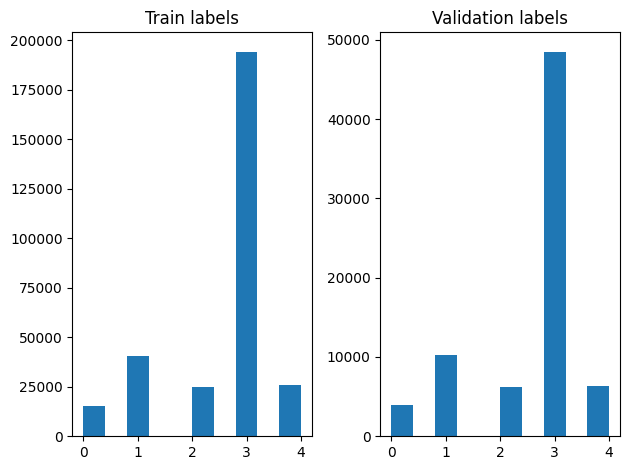

In [13]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

要使用生成器创建[数据集](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset)，我们首先编写一个生成器函数，该函数会从 `file_paths` 读取文章，从标签数组中读取标签，并在每个步骤生成一个训练样本。我们将此生成器函数传递到 [`tf.data.Dataset.from_generator`](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset#from_generator) 方法，并指定输出类型。每个训练样本都是一个元组，其中包含 `tf.string` 数据类型的文章和独热编码标签。我们使用 [`tf.data.Dataset.skip`](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset#skip) 和 [`tf.data.Dataset.take`](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset#take) 方法以 80-20 的比例将数据集拆分为训练集和验证集。

In [14]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [15]:
def make_datasets(train_size):
  batch_size = 256

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


  return train_ds, test_ds

In [16]:
train_data, validation_data = make_datasets(train_size)

# 模型训练和评估

由于我们已经在模块周围添加了封装容器，使其可以像 Keras 中的任何其他层一样使用，因此我们可以创建一个小的[序贯](https://tensorflow.google.cn/api_docs/python/tf/keras/Sequential)模型，此模型是层的线性堆叠。我们可以像使用任何其他层一样，使用 `model.add` 添加文本嵌入向量模块。我们通过指定损失和优化器来编译模型，并对其进行 10 个周期的训练。`tf.keras` API 可以将 TensorFlow 数据集作为输入进行处理，因此我们可以将数据集实例传递给用于模型训练的拟合方法。由于我们使用的是生成器函数，`tf.data` 将负责生成样本，对其进行批处理，并将其馈送给模型。

## 模型

In [17]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model

In [18]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

## 训练

In [19]:
history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5


I0000 00:00:1699382517.693312   63594 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1/1176 [..............................] - ETA: 31:47 - loss: 1.6002 - accuracy: 0.1094

   3/1176 [..............................] - ETA: 29s - loss: 1.5511 - accuracy: 0.1914  

   6/1176 [..............................] - ETA: 27s - loss: 1.4909 - accuracy: 0.3444

   9/1176 [..............................] - ETA: 26s - loss: 1.4253 - accuracy: 0.4648

  12/1176 [..............................] - ETA: 25s - loss: 1.3685 - accuracy: 0.5186

  15/1176 [..............................] - ETA: 25s - loss: 1.3044 - accuracy: 0.5505

  18/1176 [..............................] - ETA: 25s - loss: 1.2566 - accuracy: 0.5675

  21/1176 [..............................] - ETA: 24s - loss: 1.2179 - accuracy: 0.5785

  24/1176 [..............................] - ETA: 24s - loss: 1.1848 - accuracy: 0.5887

  27/1176 [..............................] - ETA: 24s - loss: 1.1515 - accuracy: 0.6033

  30/1176 [..............................] - ETA: 24s - loss: 1.1268 - accuracy: 0.6151

  33/1176 [..............................] - ETA: 24s - loss: 1.0970 - accuracy: 0.6295

  36/1176 [..............................] - ETA: 23s - loss: 1.0624 - accuracy: 0.6455

  39/1176 [..............................] - ETA: 23s - loss: 1.0346 - accuracy: 0.6566

  42/1176 [>.............................] - ETA: 23s - loss: 1.0101 - accuracy: 0.6653

  45/1176 [>.............................] - ETA: 23s - loss: 0.9891 - accuracy: 0.6722

  48/1176 [>.............................] - ETA: 23s - loss: 0.9678 - accuracy: 0.6810

  51/1176 [>.............................] - ETA: 23s - loss: 0.9447 - accuracy: 0.6914

  54/1176 [>.............................] - ETA: 23s - loss: 0.9214 - accuracy: 0.7003

  57/1176 [>.............................] - ETA: 23s - loss: 0.9038 - accuracy: 0.7060

  60/1176 [>.............................] - ETA: 23s - loss: 0.8853 - accuracy: 0.7124

  63/1176 [>.............................] - ETA: 23s - loss: 0.8652 - accuracy: 0.7199

  66/1176 [>.............................] - ETA: 23s - loss: 0.8471 - accuracy: 0.7269

  69/1176 [>.............................] - ETA: 23s - loss: 0.8306 - accuracy: 0.7320

  72/1176 [>.............................] - ETA: 22s - loss: 0.8139 - accuracy: 0.7378

  75/1176 [>.............................] - ETA: 22s - loss: 0.7994 - accuracy: 0.7430

  78/1176 [>.............................] - ETA: 22s - loss: 0.7833 - accuracy: 0.7487

  81/1176 [=>............................] - ETA: 22s - loss: 0.7685 - accuracy: 0.7539

  84/1176 [=>............................] - ETA: 22s - loss: 0.7536 - accuracy: 0.7594

  87/1176 [=>............................] - ETA: 22s - loss: 0.7399 - accuracy: 0.7641

  90/1176 [=>............................] - ETA: 22s - loss: 0.7269 - accuracy: 0.7683

  93/1176 [=>............................] - ETA: 22s - loss: 0.7147 - accuracy: 0.7722

  96/1176 [=>............................] - ETA: 22s - loss: 0.7026 - accuracy: 0.7763

  99/1176 [=>............................] - ETA: 22s - loss: 0.6903 - accuracy: 0.7803

 102/1176 [=>............................] - ETA: 22s - loss: 0.6798 - accuracy: 0.7832

 105/1176 [=>............................] - ETA: 22s - loss: 0.6694 - accuracy: 0.7861

 108/1176 [=>............................] - ETA: 22s - loss: 0.6586 - accuracy: 0.7897

 111/1176 [=>............................] - ETA: 22s - loss: 0.6493 - accuracy: 0.7928

 114/1176 [=>............................] - ETA: 21s - loss: 0.6397 - accuracy: 0.7960

 117/1176 [=>............................] - ETA: 21s - loss: 0.6309 - accuracy: 0.7989

 120/1176 [==>...........................] - ETA: 21s - loss: 0.6222 - accuracy: 0.8017

 123/1176 [==>...........................] - ETA: 21s - loss: 0.6137 - accuracy: 0.8045

 126/1176 [==>...........................] - ETA: 21s - loss: 0.6058 - accuracy: 0.8073

 129/1176 [==>...........................] - ETA: 21s - loss: 0.5987 - accuracy: 0.8094

 132/1176 [==>...........................] - ETA: 21s - loss: 0.5909 - accuracy: 0.8123

 135/1176 [==>...........................] - ETA: 21s - loss: 0.5834 - accuracy: 0.8145

 138/1176 [==>...........................] - ETA: 21s - loss: 0.5760 - accuracy: 0.8169

 141/1176 [==>...........................] - ETA: 21s - loss: 0.5693 - accuracy: 0.8190

 144/1176 [==>...........................] - ETA: 21s - loss: 0.5624 - accuracy: 0.8213

 147/1176 [==>...........................] - ETA: 21s - loss: 0.5558 - accuracy: 0.8234

 150/1176 [==>...........................] - ETA: 21s - loss: 0.5499 - accuracy: 0.8252

 153/1176 [==>...........................] - ETA: 21s - loss: 0.5445 - accuracy: 0.8268

 156/1176 [==>...........................] - ETA: 21s - loss: 0.5393 - accuracy: 0.8284

 159/1176 [===>..........................] - ETA: 21s - loss: 0.5340 - accuracy: 0.8302

 162/1176 [===>..........................] - ETA: 21s - loss: 0.5292 - accuracy: 0.8317

 165/1176 [===>..........................] - ETA: 20s - loss: 0.5239 - accuracy: 0.8335

 167/1176 [===>..........................] - ETA: 21s - loss: 0.5201 - accuracy: 0.8348

 170/1176 [===>..........................] - ETA: 20s - loss: 0.5161 - accuracy: 0.8359

 173/1176 [===>..........................] - ETA: 20s - loss: 0.5100 - accuracy: 0.8378

 176/1176 [===>..........................] - ETA: 20s - loss: 0.5054 - accuracy: 0.8392

 179/1176 [===>..........................] - ETA: 20s - loss: 0.5013 - accuracy: 0.8405

 182/1176 [===>..........................] - ETA: 20s - loss: 0.4973 - accuracy: 0.8418

 185/1176 [===>..........................] - ETA: 20s - loss: 0.4925 - accuracy: 0.8432

 188/1176 [===>..........................] - ETA: 20s - loss: 0.4879 - accuracy: 0.8447

 191/1176 [===>..........................] - ETA: 20s - loss: 0.4835 - accuracy: 0.8463

 194/1176 [===>..........................] - ETA: 20s - loss: 0.4801 - accuracy: 0.8473

 197/1176 [====>.........................] - ETA: 20s - loss: 0.4761 - accuracy: 0.8485

 200/1176 [====>.........................] - ETA: 20s - loss: 0.4722 - accuracy: 0.8497

 203/1176 [====>.........................] - ETA: 20s - loss: 0.4688 - accuracy: 0.8507

 206/1176 [====>.........................] - ETA: 20s - loss: 0.4652 - accuracy: 0.8518

 209/1176 [====>.........................] - ETA: 20s - loss: 0.4616 - accuracy: 0.8528

 212/1176 [====>.........................] - ETA: 20s - loss: 0.4581 - accuracy: 0.8539

 215/1176 [====>.........................] - ETA: 20s - loss: 0.4547 - accuracy: 0.8548

 218/1176 [====>.........................] - ETA: 19s - loss: 0.4518 - accuracy: 0.8558

 221/1176 [====>.........................] - ETA: 19s - loss: 0.4482 - accuracy: 0.8569

 224/1176 [====>.........................] - ETA: 19s - loss: 0.4453 - accuracy: 0.8579

 227/1176 [====>.........................] - ETA: 19s - loss: 0.4422 - accuracy: 0.8588

 230/1176 [====>.........................] - ETA: 19s - loss: 0.4391 - accuracy: 0.8597

 233/1176 [====>.........................] - ETA: 19s - loss: 0.4364 - accuracy: 0.8604

 236/1176 [=====>........................] - ETA: 19s - loss: 0.4332 - accuracy: 0.8614

 239/1176 [=====>........................] - ETA: 19s - loss: 0.4309 - accuracy: 0.8620

 242/1176 [=====>........................] - ETA: 19s - loss: 0.4279 - accuracy: 0.8630

 245/1176 [=====>........................] - ETA: 19s - loss: 0.4250 - accuracy: 0.8640

 248/1176 [=====>........................] - ETA: 19s - loss: 0.4219 - accuracy: 0.8650

 251/1176 [=====>........................] - ETA: 19s - loss: 0.4190 - accuracy: 0.8658

 254/1176 [=====>........................] - ETA: 19s - loss: 0.4165 - accuracy: 0.8666

 257/1176 [=====>........................] - ETA: 19s - loss: 0.4141 - accuracy: 0.8672

 260/1176 [=====>........................] - ETA: 19s - loss: 0.4115 - accuracy: 0.8679

 263/1176 [=====>........................] - ETA: 19s - loss: 0.4092 - accuracy: 0.8686

 266/1176 [=====>........................] - ETA: 18s - loss: 0.4073 - accuracy: 0.8692

 269/1176 [=====>........................] - ETA: 18s - loss: 0.4049 - accuracy: 0.8699

 272/1176 [=====>........................] - ETA: 18s - loss: 0.4023 - accuracy: 0.8707

 275/1176 [======>.......................] - ETA: 18s - loss: 0.4000 - accuracy: 0.8715

 278/1176 [======>.......................] - ETA: 18s - loss: 0.3981 - accuracy: 0.8721

 281/1176 [======>.......................] - ETA: 18s - loss: 0.3962 - accuracy: 0.8726

 284/1176 [======>.......................] - ETA: 18s - loss: 0.3940 - accuracy: 0.8733

 287/1176 [======>.......................] - ETA: 18s - loss: 0.3919 - accuracy: 0.8740

 290/1176 [======>.......................] - ETA: 18s - loss: 0.3900 - accuracy: 0.8745

 293/1176 [======>.......................] - ETA: 18s - loss: 0.3880 - accuracy: 0.8752

 296/1176 [======>.......................] - ETA: 18s - loss: 0.3860 - accuracy: 0.8758

 299/1176 [======>.......................] - ETA: 18s - loss: 0.3840 - accuracy: 0.8765

 302/1176 [======>.......................] - ETA: 18s - loss: 0.3816 - accuracy: 0.8772

 305/1176 [======>.......................] - ETA: 18s - loss: 0.3797 - accuracy: 0.8778

 308/1176 [======>.......................] - ETA: 18s - loss: 0.3776 - accuracy: 0.8784

 311/1176 [======>.......................] - ETA: 17s - loss: 0.3758 - accuracy: 0.8790

 314/1176 [=======>......................] - ETA: 17s - loss: 0.3745 - accuracy: 0.8794

 317/1176 [=======>......................] - ETA: 17s - loss: 0.3728 - accuracy: 0.8800

 320/1176 [=======>......................] - ETA: 17s - loss: 0.3711 - accuracy: 0.8806

 323/1176 [=======>......................] - ETA: 17s - loss: 0.3698 - accuracy: 0.8810

 326/1176 [=======>......................] - ETA: 17s - loss: 0.3680 - accuracy: 0.8816

 329/1176 [=======>......................] - ETA: 17s - loss: 0.3662 - accuracy: 0.8821

 332/1176 [=======>......................] - ETA: 17s - loss: 0.3644 - accuracy: 0.8826

 335/1176 [=======>......................] - ETA: 17s - loss: 0.3628 - accuracy: 0.8831

 338/1176 [=======>......................] - ETA: 17s - loss: 0.3615 - accuracy: 0.8836

 341/1176 [=======>......................] - ETA: 17s - loss: 0.3598 - accuracy: 0.8841

 344/1176 [=======>......................] - ETA: 17s - loss: 0.3578 - accuracy: 0.8848

 347/1176 [=======>......................] - ETA: 17s - loss: 0.3562 - accuracy: 0.8851

 350/1176 [=======>......................] - ETA: 17s - loss: 0.3546 - accuracy: 0.8857

 353/1176 [========>.....................] - ETA: 17s - loss: 0.3530 - accuracy: 0.8863

 356/1176 [========>.....................] - ETA: 17s - loss: 0.3514 - accuracy: 0.8867

 359/1176 [========>.....................] - ETA: 16s - loss: 0.3498 - accuracy: 0.8872

 362/1176 [========>.....................] - ETA: 16s - loss: 0.3485 - accuracy: 0.8875

 365/1176 [========>.....................] - ETA: 16s - loss: 0.3472 - accuracy: 0.8880

 368/1176 [========>.....................] - ETA: 16s - loss: 0.3460 - accuracy: 0.8884

 371/1176 [========>.....................] - ETA: 16s - loss: 0.3446 - accuracy: 0.8889

 374/1176 [========>.....................] - ETA: 16s - loss: 0.3435 - accuracy: 0.8891

 377/1176 [========>.....................] - ETA: 16s - loss: 0.3420 - accuracy: 0.8896

 380/1176 [========>.....................] - ETA: 16s - loss: 0.3408 - accuracy: 0.8900

 383/1176 [========>.....................] - ETA: 16s - loss: 0.3396 - accuracy: 0.8904

 386/1176 [========>.....................] - ETA: 16s - loss: 0.3381 - accuracy: 0.8908

 389/1176 [========>.....................] - ETA: 16s - loss: 0.3368 - accuracy: 0.8913

 392/1176 [=========>....................] - ETA: 16s - loss: 0.3360 - accuracy: 0.8917

 395/1176 [=========>....................] - ETA: 16s - loss: 0.3347 - accuracy: 0.8920

 398/1176 [=========>....................] - ETA: 16s - loss: 0.3334 - accuracy: 0.8925

 401/1176 [=========>....................] - ETA: 16s - loss: 0.3323 - accuracy: 0.8927

 404/1176 [=========>....................] - ETA: 16s - loss: 0.3314 - accuracy: 0.8931

 407/1176 [=========>....................] - ETA: 15s - loss: 0.3302 - accuracy: 0.8935

 410/1176 [=========>....................] - ETA: 15s - loss: 0.3293 - accuracy: 0.8938

 413/1176 [=========>....................] - ETA: 15s - loss: 0.3284 - accuracy: 0.8940

 416/1176 [=========>....................] - ETA: 15s - loss: 0.3274 - accuracy: 0.8944

 419/1176 [=========>....................] - ETA: 15s - loss: 0.3265 - accuracy: 0.8946

 422/1176 [=========>....................] - ETA: 15s - loss: 0.3253 - accuracy: 0.8950

 425/1176 [=========>....................] - ETA: 15s - loss: 0.3242 - accuracy: 0.8953

 428/1176 [=========>....................] - ETA: 15s - loss: 0.3233 - accuracy: 0.8955

 431/1176 [=========>....................] - ETA: 15s - loss: 0.3222 - accuracy: 0.8958

 434/1176 [==========>...................] - ETA: 15s - loss: 0.3213 - accuracy: 0.8960

 437/1176 [==========>...................] - ETA: 15s - loss: 0.3202 - accuracy: 0.8964

 440/1176 [==========>...................] - ETA: 15s - loss: 0.3191 - accuracy: 0.8967

 443/1176 [==========>...................] - ETA: 15s - loss: 0.3180 - accuracy: 0.8971

 446/1176 [==========>...................] - ETA: 15s - loss: 0.3172 - accuracy: 0.8973

 449/1176 [==========>...................] - ETA: 15s - loss: 0.3165 - accuracy: 0.8975

 452/1176 [==========>...................] - ETA: 15s - loss: 0.3155 - accuracy: 0.8978

 455/1176 [==========>...................] - ETA: 14s - loss: 0.3145 - accuracy: 0.8982

 458/1176 [==========>...................] - ETA: 14s - loss: 0.3136 - accuracy: 0.8985

 461/1176 [==========>...................] - ETA: 14s - loss: 0.3124 - accuracy: 0.8989

 464/1176 [==========>...................] - ETA: 14s - loss: 0.3116 - accuracy: 0.8991

 467/1176 [==========>...................] - ETA: 14s - loss: 0.3105 - accuracy: 0.8994

 470/1176 [==========>...................] - ETA: 14s - loss: 0.3095 - accuracy: 0.8998

 473/1176 [===========>..................] - ETA: 14s - loss: 0.3084 - accuracy: 0.9001

 476/1176 [===========>..................] - ETA: 14s - loss: 0.3078 - accuracy: 0.9003

 479/1176 [===========>..................] - ETA: 14s - loss: 0.3071 - accuracy: 0.9005

 482/1176 [===========>..................] - ETA: 14s - loss: 0.3063 - accuracy: 0.9007

 485/1176 [===========>..................] - ETA: 14s - loss: 0.3058 - accuracy: 0.9009

 488/1176 [===========>..................] - ETA: 14s - loss: 0.3050 - accuracy: 0.9011

 491/1176 [===========>..................] - ETA: 14s - loss: 0.3042 - accuracy: 0.9013

 494/1176 [===========>..................] - ETA: 14s - loss: 0.3032 - accuracy: 0.9016

 497/1176 [===========>..................] - ETA: 14s - loss: 0.3024 - accuracy: 0.9019

 500/1176 [===========>..................] - ETA: 14s - loss: 0.3016 - accuracy: 0.9020

 503/1176 [===========>..................] - ETA: 13s - loss: 0.3012 - accuracy: 0.9022

 506/1176 [===========>..................] - ETA: 13s - loss: 0.3004 - accuracy: 0.9024

 509/1176 [===========>..................] - ETA: 13s - loss: 0.2997 - accuracy: 0.9026

 512/1176 [============>.................] - ETA: 13s - loss: 0.2989 - accuracy: 0.9028

 515/1176 [============>.................] - ETA: 13s - loss: 0.2982 - accuracy: 0.9031

 518/1176 [============>.................] - ETA: 13s - loss: 0.2974 - accuracy: 0.9033

 521/1176 [============>.................] - ETA: 13s - loss: 0.2967 - accuracy: 0.9035

 524/1176 [============>.................] - ETA: 13s - loss: 0.2962 - accuracy: 0.9037

 527/1176 [============>.................] - ETA: 13s - loss: 0.2953 - accuracy: 0.9040

 530/1176 [============>.................] - ETA: 13s - loss: 0.2948 - accuracy: 0.9041

 533/1176 [============>.................] - ETA: 13s - loss: 0.2940 - accuracy: 0.9044

 536/1176 [============>.................] - ETA: 13s - loss: 0.2935 - accuracy: 0.9046

 539/1176 [============>.................] - ETA: 13s - loss: 0.2930 - accuracy: 0.9047

 542/1176 [============>.................] - ETA: 13s - loss: 0.2924 - accuracy: 0.9049

 545/1176 [============>.................] - ETA: 13s - loss: 0.2917 - accuracy: 0.9050

 548/1176 [============>.................] - ETA: 13s - loss: 0.2911 - accuracy: 0.9052

 551/1176 [=============>................] - ETA: 12s - loss: 0.2904 - accuracy: 0.9054

 554/1176 [=============>................] - ETA: 12s - loss: 0.2897 - accuracy: 0.9057

 557/1176 [=============>................] - ETA: 12s - loss: 0.2890 - accuracy: 0.9059

 560/1176 [=============>................] - ETA: 12s - loss: 0.2884 - accuracy: 0.9061

 563/1176 [=============>................] - ETA: 12s - loss: 0.2878 - accuracy: 0.9063

 566/1176 [=============>................] - ETA: 12s - loss: 0.2871 - accuracy: 0.9065

 569/1176 [=============>................] - ETA: 12s - loss: 0.2865 - accuracy: 0.9066

 572/1176 [=============>................] - ETA: 12s - loss: 0.2860 - accuracy: 0.9068

 575/1176 [=============>................] - ETA: 12s - loss: 0.2854 - accuracy: 0.9070

 578/1176 [=============>................] - ETA: 12s - loss: 0.2848 - accuracy: 0.9071

 581/1176 [=============>................] - ETA: 12s - loss: 0.2845 - accuracy: 0.9072

 584/1176 [=============>................] - ETA: 12s - loss: 0.2839 - accuracy: 0.9074

 587/1176 [=============>................] - ETA: 12s - loss: 0.2834 - accuracy: 0.9075

 590/1176 [==============>...............] - ETA: 12s - loss: 0.2828 - accuracy: 0.9077

 593/1176 [==============>...............] - ETA: 12s - loss: 0.2824 - accuracy: 0.9079

 596/1176 [==============>...............] - ETA: 12s - loss: 0.2819 - accuracy: 0.9080

 599/1176 [==============>...............] - ETA: 11s - loss: 0.2813 - accuracy: 0.9082

 602/1176 [==============>...............] - ETA: 11s - loss: 0.2808 - accuracy: 0.9083

 605/1176 [==============>...............] - ETA: 11s - loss: 0.2801 - accuracy: 0.9086

 608/1176 [==============>...............] - ETA: 11s - loss: 0.2795 - accuracy: 0.9088

 611/1176 [==============>...............] - ETA: 11s - loss: 0.2790 - accuracy: 0.9089

 614/1176 [==============>...............] - ETA: 11s - loss: 0.2785 - accuracy: 0.9091

 617/1176 [==============>...............] - ETA: 11s - loss: 0.2778 - accuracy: 0.9093

 620/1176 [==============>...............] - ETA: 11s - loss: 0.2775 - accuracy: 0.9094

 623/1176 [==============>...............] - ETA: 11s - loss: 0.2769 - accuracy: 0.9096

 626/1176 [==============>...............] - ETA: 11s - loss: 0.2763 - accuracy: 0.9098

 629/1176 [===============>..............] - ETA: 11s - loss: 0.2756 - accuracy: 0.9100

 632/1176 [===============>..............] - ETA: 11s - loss: 0.2750 - accuracy: 0.9102

 635/1176 [===============>..............] - ETA: 11s - loss: 0.2746 - accuracy: 0.9103

 638/1176 [===============>..............] - ETA: 11s - loss: 0.2741 - accuracy: 0.9105

 641/1176 [===============>..............] - ETA: 11s - loss: 0.2736 - accuracy: 0.9106

 644/1176 [===============>..............] - ETA: 11s - loss: 0.2731 - accuracy: 0.9108

 647/1176 [===============>..............] - ETA: 10s - loss: 0.2726 - accuracy: 0.9109

 650/1176 [===============>..............] - ETA: 10s - loss: 0.2722 - accuracy: 0.9111

 653/1176 [===============>..............] - ETA: 10s - loss: 0.2717 - accuracy: 0.9113

 656/1176 [===============>..............] - ETA: 10s - loss: 0.2712 - accuracy: 0.9114

 659/1176 [===============>..............] - ETA: 10s - loss: 0.2707 - accuracy: 0.9115

 662/1176 [===============>..............] - ETA: 10s - loss: 0.2701 - accuracy: 0.9117

 665/1176 [===============>..............] - ETA: 10s - loss: 0.2696 - accuracy: 0.9118

 668/1176 [================>.............] - ETA: 10s - loss: 0.2691 - accuracy: 0.9119

 671/1176 [================>.............] - ETA: 10s - loss: 0.2685 - accuracy: 0.9121

 674/1176 [================>.............] - ETA: 10s - loss: 0.2682 - accuracy: 0.9122

 677/1176 [================>.............] - ETA: 10s - loss: 0.2678 - accuracy: 0.9123

 680/1176 [================>.............] - ETA: 10s - loss: 0.2674 - accuracy: 0.9124

 683/1176 [================>.............] - ETA: 10s - loss: 0.2668 - accuracy: 0.9126

 686/1176 [================>.............] - ETA: 10s - loss: 0.2664 - accuracy: 0.9128

 689/1176 [================>.............] - ETA: 10s - loss: 0.2659 - accuracy: 0.9129

 692/1176 [================>.............] - ETA: 10s - loss: 0.2655 - accuracy: 0.9131

 695/1176 [================>.............] - ETA: 9s - loss: 0.2649 - accuracy: 0.9132 

 698/1176 [================>.............] - ETA: 9s - loss: 0.2645 - accuracy: 0.9134

 701/1176 [================>.............] - ETA: 9s - loss: 0.2640 - accuracy: 0.9136

 704/1176 [================>.............] - ETA: 9s - loss: 0.2635 - accuracy: 0.9137

 707/1176 [=================>............] - ETA: 9s - loss: 0.2630 - accuracy: 0.9138

 710/1176 [=================>............] - ETA: 9s - loss: 0.2625 - accuracy: 0.9140

 713/1176 [=================>............] - ETA: 9s - loss: 0.2621 - accuracy: 0.9141

 716/1176 [=================>............] - ETA: 9s - loss: 0.2617 - accuracy: 0.9142

 719/1176 [=================>............] - ETA: 9s - loss: 0.2613 - accuracy: 0.9144

 722/1176 [=================>............] - ETA: 9s - loss: 0.2609 - accuracy: 0.9145

 725/1176 [=================>............] - ETA: 9s - loss: 0.2605 - accuracy: 0.9146

 728/1176 [=================>............] - ETA: 9s - loss: 0.2600 - accuracy: 0.9148

 731/1176 [=================>............] - ETA: 9s - loss: 0.2595 - accuracy: 0.9149

 734/1176 [=================>............] - ETA: 9s - loss: 0.2591 - accuracy: 0.9151

 737/1176 [=================>............] - ETA: 9s - loss: 0.2587 - accuracy: 0.9151

 740/1176 [=================>............] - ETA: 9s - loss: 0.2583 - accuracy: 0.9152

 743/1176 [=================>............] - ETA: 8s - loss: 0.2579 - accuracy: 0.9153

 746/1176 [==================>...........] - ETA: 8s - loss: 0.2576 - accuracy: 0.9155

 749/1176 [==================>...........] - ETA: 8s - loss: 0.2573 - accuracy: 0.9155

 752/1176 [==================>...........] - ETA: 8s - loss: 0.2570 - accuracy: 0.9157

 755/1176 [==================>...........] - ETA: 8s - loss: 0.2566 - accuracy: 0.9158

 758/1176 [==================>...........] - ETA: 8s - loss: 0.2562 - accuracy: 0.9159

 761/1176 [==================>...........] - ETA: 8s - loss: 0.2557 - accuracy: 0.9160

 764/1176 [==================>...........] - ETA: 8s - loss: 0.2553 - accuracy: 0.9161

 767/1176 [==================>...........] - ETA: 8s - loss: 0.2548 - accuracy: 0.9162

 770/1176 [==================>...........] - ETA: 8s - loss: 0.2545 - accuracy: 0.9163

 773/1176 [==================>...........] - ETA: 8s - loss: 0.2542 - accuracy: 0.9164

 776/1176 [==================>...........] - ETA: 8s - loss: 0.2538 - accuracy: 0.9166

 779/1176 [==================>...........] - ETA: 8s - loss: 0.2535 - accuracy: 0.9167

 782/1176 [==================>...........] - ETA: 8s - loss: 0.2532 - accuracy: 0.9168

 785/1176 [===================>..........] - ETA: 8s - loss: 0.2527 - accuracy: 0.9169

 788/1176 [===================>..........] - ETA: 8s - loss: 0.2525 - accuracy: 0.9169

 791/1176 [===================>..........] - ETA: 7s - loss: 0.2521 - accuracy: 0.9170

 794/1176 [===================>..........] - ETA: 7s - loss: 0.2518 - accuracy: 0.9171

 797/1176 [===================>..........] - ETA: 7s - loss: 0.2514 - accuracy: 0.9172

 800/1176 [===================>..........] - ETA: 7s - loss: 0.2513 - accuracy: 0.9173

 803/1176 [===================>..........] - ETA: 7s - loss: 0.2508 - accuracy: 0.9174

 806/1176 [===================>..........] - ETA: 7s - loss: 0.2504 - accuracy: 0.9176

 809/1176 [===================>..........] - ETA: 7s - loss: 0.2501 - accuracy: 0.9176

 812/1176 [===================>..........] - ETA: 7s - loss: 0.2498 - accuracy: 0.9177

 815/1176 [===================>..........] - ETA: 7s - loss: 0.2494 - accuracy: 0.9178

 818/1176 [===================>..........] - ETA: 7s - loss: 0.2492 - accuracy: 0.9179

 821/1176 [===================>..........] - ETA: 7s - loss: 0.2489 - accuracy: 0.9181

 824/1176 [====================>.........] - ETA: 7s - loss: 0.2486 - accuracy: 0.9182

 827/1176 [====================>.........] - ETA: 7s - loss: 0.2482 - accuracy: 0.9183

 830/1176 [====================>.........] - ETA: 7s - loss: 0.2478 - accuracy: 0.9184

 833/1176 [====================>.........] - ETA: 7s - loss: 0.2475 - accuracy: 0.9185

 836/1176 [====================>.........] - ETA: 7s - loss: 0.2472 - accuracy: 0.9186

 839/1176 [====================>.........] - ETA: 6s - loss: 0.2468 - accuracy: 0.9187

 842/1176 [====================>.........] - ETA: 6s - loss: 0.2465 - accuracy: 0.9188

 845/1176 [====================>.........] - ETA: 6s - loss: 0.2462 - accuracy: 0.9189

 848/1176 [====================>.........] - ETA: 6s - loss: 0.2458 - accuracy: 0.9190

 851/1176 [====================>.........] - ETA: 6s - loss: 0.2454 - accuracy: 0.9192

 854/1176 [====================>.........] - ETA: 6s - loss: 0.2451 - accuracy: 0.9192

 857/1176 [====================>.........] - ETA: 6s - loss: 0.2449 - accuracy: 0.9193

 860/1176 [====================>.........] - ETA: 6s - loss: 0.2445 - accuracy: 0.9194

 863/1176 [=====================>........] - ETA: 6s - loss: 0.2442 - accuracy: 0.9195

 866/1176 [=====================>........] - ETA: 6s - loss: 0.2439 - accuracy: 0.9196

 869/1176 [=====================>........] - ETA: 6s - loss: 0.2436 - accuracy: 0.9197

 872/1176 [=====================>........] - ETA: 6s - loss: 0.2433 - accuracy: 0.9198

 875/1176 [=====================>........] - ETA: 6s - loss: 0.2430 - accuracy: 0.9199

 878/1176 [=====================>........] - ETA: 6s - loss: 0.2428 - accuracy: 0.9199

 881/1176 [=====================>........] - ETA: 6s - loss: 0.2425 - accuracy: 0.9200

 884/1176 [=====================>........] - ETA: 6s - loss: 0.2422 - accuracy: 0.9201

 887/1176 [=====================>........] - ETA: 5s - loss: 0.2420 - accuracy: 0.9202

 890/1176 [=====================>........] - ETA: 5s - loss: 0.2417 - accuracy: 0.9203

 893/1176 [=====================>........] - ETA: 5s - loss: 0.2414 - accuracy: 0.9203

 896/1176 [=====================>........] - ETA: 5s - loss: 0.2411 - accuracy: 0.9205

 899/1176 [=====================>........] - ETA: 5s - loss: 0.2409 - accuracy: 0.9205

 902/1176 [======================>.......] - ETA: 5s - loss: 0.2406 - accuracy: 0.9206

 905/1176 [======================>.......] - ETA: 5s - loss: 0.2405 - accuracy: 0.9207

 908/1176 [======================>.......] - ETA: 5s - loss: 0.2402 - accuracy: 0.9208

 911/1176 [======================>.......] - ETA: 5s - loss: 0.2399 - accuracy: 0.9209

 914/1176 [======================>.......] - ETA: 5s - loss: 0.2396 - accuracy: 0.9210

 917/1176 [======================>.......] - ETA: 5s - loss: 0.2394 - accuracy: 0.9211

 920/1176 [======================>.......] - ETA: 5s - loss: 0.2391 - accuracy: 0.9211

 923/1176 [======================>.......] - ETA: 5s - loss: 0.2389 - accuracy: 0.9212

 926/1176 [======================>.......] - ETA: 5s - loss: 0.2386 - accuracy: 0.9213

 929/1176 [======================>.......] - ETA: 5s - loss: 0.2384 - accuracy: 0.9213

 932/1176 [======================>.......] - ETA: 5s - loss: 0.2381 - accuracy: 0.9214

 935/1176 [======================>.......] - ETA: 4s - loss: 0.2379 - accuracy: 0.9215

 938/1176 [======================>.......] - ETA: 4s - loss: 0.2376 - accuracy: 0.9216

 941/1176 [=======================>......] - ETA: 4s - loss: 0.2372 - accuracy: 0.9217

 944/1176 [=======================>......] - ETA: 4s - loss: 0.2369 - accuracy: 0.9218

 947/1176 [=======================>......] - ETA: 4s - loss: 0.2368 - accuracy: 0.9218

 950/1176 [=======================>......] - ETA: 4s - loss: 0.2366 - accuracy: 0.9218

 953/1176 [=======================>......] - ETA: 4s - loss: 0.2363 - accuracy: 0.9219

 956/1176 [=======================>......] - ETA: 4s - loss: 0.2360 - accuracy: 0.9220

 959/1176 [=======================>......] - ETA: 4s - loss: 0.2358 - accuracy: 0.9221

 962/1176 [=======================>......] - ETA: 4s - loss: 0.2356 - accuracy: 0.9221

 965/1176 [=======================>......] - ETA: 4s - loss: 0.2353 - accuracy: 0.9222

 968/1176 [=======================>......] - ETA: 4s - loss: 0.2351 - accuracy: 0.9222

 971/1176 [=======================>......] - ETA: 4s - loss: 0.2349 - accuracy: 0.9223

 974/1176 [=======================>......] - ETA: 4s - loss: 0.2346 - accuracy: 0.9224

 977/1176 [=======================>......] - ETA: 4s - loss: 0.2344 - accuracy: 0.9225

 980/1176 [========================>.....] - ETA: 4s - loss: 0.2342 - accuracy: 0.9226

 983/1176 [========================>.....] - ETA: 3s - loss: 0.2339 - accuracy: 0.9226

 986/1176 [========================>.....] - ETA: 3s - loss: 0.2337 - accuracy: 0.9227

 989/1176 [========================>.....] - ETA: 3s - loss: 0.2336 - accuracy: 0.9227

 992/1176 [========================>.....] - ETA: 3s - loss: 0.2333 - accuracy: 0.9228

 995/1176 [========================>.....] - ETA: 3s - loss: 0.2331 - accuracy: 0.9229

 998/1176 [========================>.....] - ETA: 3s - loss: 0.2328 - accuracy: 0.9230

1001/1176 [========================>.....] - ETA: 3s - loss: 0.2325 - accuracy: 0.9230

1004/1176 [========================>.....] - ETA: 3s - loss: 0.2324 - accuracy: 0.9231

1007/1176 [========================>.....] - ETA: 3s - loss: 0.2322 - accuracy: 0.9231

1010/1176 [========================>.....] - ETA: 3s - loss: 0.2319 - accuracy: 0.9232

1013/1176 [========================>.....] - ETA: 3s - loss: 0.2317 - accuracy: 0.9233

1016/1176 [========================>.....] - ETA: 3s - loss: 0.2314 - accuracy: 0.9234

1019/1176 [========================>.....] - ETA: 3s - loss: 0.2312 - accuracy: 0.9235

1022/1176 [=========================>....] - ETA: 3s - loss: 0.2309 - accuracy: 0.9235

1025/1176 [=========================>....] - ETA: 3s - loss: 0.2306 - accuracy: 0.9236

1028/1176 [=========================>....] - ETA: 3s - loss: 0.2304 - accuracy: 0.9237

1031/1176 [=========================>....] - ETA: 2s - loss: 0.2302 - accuracy: 0.9238

1034/1176 [=========================>....] - ETA: 2s - loss: 0.2298 - accuracy: 0.9239

1037/1176 [=========================>....] - ETA: 2s - loss: 0.2297 - accuracy: 0.9239

1040/1176 [=========================>....] - ETA: 2s - loss: 0.2294 - accuracy: 0.9240

1043/1176 [=========================>....] - ETA: 2s - loss: 0.2294 - accuracy: 0.9240

1046/1176 [=========================>....] - ETA: 2s - loss: 0.2291 - accuracy: 0.9241

1049/1176 [=========================>....] - ETA: 2s - loss: 0.2289 - accuracy: 0.9242

1052/1176 [=========================>....] - ETA: 2s - loss: 0.2286 - accuracy: 0.9242

1055/1176 [=========================>....] - ETA: 2s - loss: 0.2285 - accuracy: 0.9243

1058/1176 [=========================>....] - ETA: 2s - loss: 0.2284 - accuracy: 0.9243

1061/1176 [==========================>...] - ETA: 2s - loss: 0.2282 - accuracy: 0.9244

1064/1176 [==========================>...] - ETA: 2s - loss: 0.2279 - accuracy: 0.9245

1067/1176 [==========================>...] - ETA: 2s - loss: 0.2277 - accuracy: 0.9246

1070/1176 [==========================>...] - ETA: 2s - loss: 0.2274 - accuracy: 0.9247

1073/1176 [==========================>...] - ETA: 2s - loss: 0.2272 - accuracy: 0.9248

1076/1176 [==========================>...] - ETA: 2s - loss: 0.2271 - accuracy: 0.9248

1079/1176 [==========================>...] - ETA: 2s - loss: 0.2268 - accuracy: 0.9249

1082/1176 [==========================>...] - ETA: 1s - loss: 0.2267 - accuracy: 0.9249

1085/1176 [==========================>...] - ETA: 1s - loss: 0.2266 - accuracy: 0.9250

1088/1176 [==========================>...] - ETA: 1s - loss: 0.2263 - accuracy: 0.9251

1091/1176 [==========================>...] - ETA: 1s - loss: 0.2262 - accuracy: 0.9251

1094/1176 [==========================>...] - ETA: 1s - loss: 0.2260 - accuracy: 0.9252

1097/1176 [==========================>...] - ETA: 1s - loss: 0.2258 - accuracy: 0.9252

1100/1176 [===========================>..] - ETA: 1s - loss: 0.2256 - accuracy: 0.9253

1103/1176 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9253

1106/1176 [===========================>..] - ETA: 1s - loss: 0.2251 - accuracy: 0.9254

1109/1176 [===========================>..] - ETA: 1s - loss: 0.2250 - accuracy: 0.9254

1112/1176 [===========================>..] - ETA: 1s - loss: 0.2248 - accuracy: 0.9255

1115/1176 [===========================>..] - ETA: 1s - loss: 0.2246 - accuracy: 0.9255

1118/1176 [===========================>..] - ETA: 1s - loss: 0.2244 - accuracy: 0.9256

1121/1176 [===========================>..] - ETA: 1s - loss: 0.2243 - accuracy: 0.9257

1124/1176 [===========================>..] - ETA: 1s - loss: 0.2241 - accuracy: 0.9257

1127/1176 [===========================>..] - ETA: 1s - loss: 0.2239 - accuracy: 0.9258

1130/1176 [===========================>..] - ETA: 0s - loss: 0.2236 - accuracy: 0.9259

1133/1176 [===========================>..] - ETA: 0s - loss: 0.2235 - accuracy: 0.9259

1136/1176 [===========================>..] - ETA: 0s - loss: 0.2233 - accuracy: 0.9260

1139/1176 [============================>.] - ETA: 0s - loss: 0.2230 - accuracy: 0.9261

1142/1176 [============================>.] - ETA: 0s - loss: 0.2230 - accuracy: 0.9261

1145/1176 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9261

1148/1176 [============================>.] - ETA: 0s - loss: 0.2227 - accuracy: 0.9262

1151/1176 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9262

1154/1176 [============================>.] - ETA: 0s - loss: 0.2223 - accuracy: 0.9263

1157/1176 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.9263

1160/1176 [============================>.] - ETA: 0s - loss: 0.2219 - accuracy: 0.9263

1163/1176 [============================>.] - ETA: 0s - loss: 0.2217 - accuracy: 0.9264

1166/1176 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9265

1169/1176 [============================>.] - ETA: 0s - loss: 0.2213 - accuracy: 0.9265

1172/1176 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9266

1175/1176 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.9266

1176/1176 [==============================] - 32s 26ms/step - loss: 0.2210 - accuracy: 0.9266 - val_loss: 0.1573 - val_accuracy: 0.9463


Epoch 2/5


   1/1176 [..............................] - ETA: 2:17 - loss: 0.1332 - accuracy: 0.9648

   4/1176 [..............................] - ETA: 24s - loss: 0.1343 - accuracy: 0.9551 

   7/1176 [..............................] - ETA: 26s - loss: 0.1455 - accuracy: 0.9520

  10/1176 [..............................] - ETA: 25s - loss: 0.1463 - accuracy: 0.9520

  13/1176 [..............................] - ETA: 25s - loss: 0.1442 - accuracy: 0.9522

  16/1176 [..............................] - ETA: 24s - loss: 0.1429 - accuracy: 0.9517

  19/1176 [..............................] - ETA: 24s - loss: 0.1386 - accuracy: 0.9523

  22/1176 [..............................] - ETA: 24s - loss: 0.1385 - accuracy: 0.9540

  25/1176 [..............................] - ETA: 24s - loss: 0.1418 - accuracy: 0.9533

  28/1176 [..............................] - ETA: 24s - loss: 0.1398 - accuracy: 0.9528

  31/1176 [..............................] - ETA: 24s - loss: 0.1399 - accuracy: 0.9522

  34/1176 [..............................] - ETA: 24s - loss: 0.1416 - accuracy: 0.9521

  37/1176 [..............................] - ETA: 23s - loss: 0.1443 - accuracy: 0.9515

  40/1176 [>.............................] - ETA: 23s - loss: 0.1434 - accuracy: 0.9522

  43/1176 [>.............................] - ETA: 23s - loss: 0.1446 - accuracy: 0.9513

  46/1176 [>.............................] - ETA: 23s - loss: 0.1460 - accuracy: 0.9511

  49/1176 [>.............................] - ETA: 23s - loss: 0.1439 - accuracy: 0.9513

  52/1176 [>.............................] - ETA: 23s - loss: 0.1438 - accuracy: 0.9513

  55/1176 [>.............................] - ETA: 23s - loss: 0.1434 - accuracy: 0.9515

  58/1176 [>.............................] - ETA: 23s - loss: 0.1430 - accuracy: 0.9515

  61/1176 [>.............................] - ETA: 23s - loss: 0.1444 - accuracy: 0.9510

  64/1176 [>.............................] - ETA: 23s - loss: 0.1442 - accuracy: 0.9507

  67/1176 [>.............................] - ETA: 23s - loss: 0.1429 - accuracy: 0.9509

  70/1176 [>.............................] - ETA: 23s - loss: 0.1441 - accuracy: 0.9504

  73/1176 [>.............................] - ETA: 23s - loss: 0.1439 - accuracy: 0.9506

  76/1176 [>.............................] - ETA: 23s - loss: 0.1434 - accuracy: 0.9507

  79/1176 [=>............................] - ETA: 22s - loss: 0.1437 - accuracy: 0.9502

  82/1176 [=>............................] - ETA: 22s - loss: 0.1433 - accuracy: 0.9503

  85/1176 [=>............................] - ETA: 22s - loss: 0.1445 - accuracy: 0.9496

  88/1176 [=>............................] - ETA: 22s - loss: 0.1454 - accuracy: 0.9494

  91/1176 [=>............................] - ETA: 22s - loss: 0.1446 - accuracy: 0.9496

  94/1176 [=>............................] - ETA: 22s - loss: 0.1447 - accuracy: 0.9494

  97/1176 [=>............................] - ETA: 22s - loss: 0.1452 - accuracy: 0.9490

 100/1176 [=>............................] - ETA: 22s - loss: 0.1453 - accuracy: 0.9490

 103/1176 [=>............................] - ETA: 22s - loss: 0.1461 - accuracy: 0.9487

 106/1176 [=>............................] - ETA: 22s - loss: 0.1456 - accuracy: 0.9489

 108/1176 [=>............................] - ETA: 22s - loss: 0.1457 - accuracy: 0.9493

 111/1176 [=>............................] - ETA: 22s - loss: 0.1458 - accuracy: 0.9491

 114/1176 [=>............................] - ETA: 22s - loss: 0.1455 - accuracy: 0.9492

 117/1176 [=>............................] - ETA: 22s - loss: 0.1463 - accuracy: 0.9490

 120/1176 [==>...........................] - ETA: 22s - loss: 0.1479 - accuracy: 0.9484

 123/1176 [==>...........................] - ETA: 22s - loss: 0.1473 - accuracy: 0.9486

 126/1176 [==>...........................] - ETA: 21s - loss: 0.1472 - accuracy: 0.9488

 129/1176 [==>...........................] - ETA: 21s - loss: 0.1477 - accuracy: 0.9486

 132/1176 [==>...........................] - ETA: 21s - loss: 0.1470 - accuracy: 0.9487

 135/1176 [==>...........................] - ETA: 21s - loss: 0.1476 - accuracy: 0.9487

 138/1176 [==>...........................] - ETA: 21s - loss: 0.1481 - accuracy: 0.9485

 141/1176 [==>...........................] - ETA: 21s - loss: 0.1480 - accuracy: 0.9483

 144/1176 [==>...........................] - ETA: 21s - loss: 0.1483 - accuracy: 0.9483

 147/1176 [==>...........................] - ETA: 21s - loss: 0.1478 - accuracy: 0.9484

 150/1176 [==>...........................] - ETA: 21s - loss: 0.1478 - accuracy: 0.9485

 153/1176 [==>...........................] - ETA: 21s - loss: 0.1474 - accuracy: 0.9487

 156/1176 [==>...........................] - ETA: 21s - loss: 0.1477 - accuracy: 0.9488

 159/1176 [===>..........................] - ETA: 21s - loss: 0.1473 - accuracy: 0.9490

 162/1176 [===>..........................] - ETA: 21s - loss: 0.1474 - accuracy: 0.9490

 165/1176 [===>..........................] - ETA: 21s - loss: 0.1475 - accuracy: 0.9491

 168/1176 [===>..........................] - ETA: 20s - loss: 0.1476 - accuracy: 0.9489

 171/1176 [===>..........................] - ETA: 20s - loss: 0.1483 - accuracy: 0.9490

 174/1176 [===>..........................] - ETA: 20s - loss: 0.1487 - accuracy: 0.9489

 177/1176 [===>..........................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9490

 180/1176 [===>..........................] - ETA: 20s - loss: 0.1480 - accuracy: 0.9490

 183/1176 [===>..........................] - ETA: 20s - loss: 0.1482 - accuracy: 0.9490

 186/1176 [===>..........................] - ETA: 20s - loss: 0.1488 - accuracy: 0.9489

 189/1176 [===>..........................] - ETA: 20s - loss: 0.1485 - accuracy: 0.9490

 192/1176 [===>..........................] - ETA: 20s - loss: 0.1490 - accuracy: 0.9488

 195/1176 [===>..........................] - ETA: 20s - loss: 0.1493 - accuracy: 0.9488

 198/1176 [====>.........................] - ETA: 20s - loss: 0.1499 - accuracy: 0.9486

 201/1176 [====>.........................] - ETA: 20s - loss: 0.1496 - accuracy: 0.9487

 204/1176 [====>.........................] - ETA: 20s - loss: 0.1494 - accuracy: 0.9487

 207/1176 [====>.........................] - ETA: 20s - loss: 0.1497 - accuracy: 0.9486

 210/1176 [====>.........................] - ETA: 20s - loss: 0.1493 - accuracy: 0.9487

 213/1176 [====>.........................] - ETA: 20s - loss: 0.1490 - accuracy: 0.9487

 216/1176 [====>.........................] - ETA: 20s - loss: 0.1489 - accuracy: 0.9485

 219/1176 [====>.........................] - ETA: 19s - loss: 0.1491 - accuracy: 0.9485

 222/1176 [====>.........................] - ETA: 19s - loss: 0.1490 - accuracy: 0.9486

 225/1176 [====>.........................] - ETA: 19s - loss: 0.1492 - accuracy: 0.9485

 228/1176 [====>.........................] - ETA: 19s - loss: 0.1490 - accuracy: 0.9484

 231/1176 [====>.........................] - ETA: 19s - loss: 0.1492 - accuracy: 0.9484

 234/1176 [====>.........................] - ETA: 19s - loss: 0.1490 - accuracy: 0.9484

 237/1176 [=====>........................] - ETA: 19s - loss: 0.1487 - accuracy: 0.9484

 240/1176 [=====>........................] - ETA: 19s - loss: 0.1486 - accuracy: 0.9485

 243/1176 [=====>........................] - ETA: 19s - loss: 0.1484 - accuracy: 0.9485

 246/1176 [=====>........................] - ETA: 19s - loss: 0.1487 - accuracy: 0.9485

 249/1176 [=====>........................] - ETA: 19s - loss: 0.1488 - accuracy: 0.9483

 252/1176 [=====>........................] - ETA: 19s - loss: 0.1486 - accuracy: 0.9484

 255/1176 [=====>........................] - ETA: 19s - loss: 0.1486 - accuracy: 0.9484

 258/1176 [=====>........................] - ETA: 19s - loss: 0.1486 - accuracy: 0.9484

 261/1176 [=====>........................] - ETA: 19s - loss: 0.1489 - accuracy: 0.9483

 264/1176 [=====>........................] - ETA: 19s - loss: 0.1488 - accuracy: 0.9483

 267/1176 [=====>........................] - ETA: 18s - loss: 0.1488 - accuracy: 0.9482

 270/1176 [=====>........................] - ETA: 18s - loss: 0.1487 - accuracy: 0.9483

 273/1176 [=====>........................] - ETA: 18s - loss: 0.1488 - accuracy: 0.9483

 276/1176 [======>.......................] - ETA: 18s - loss: 0.1490 - accuracy: 0.9481

 279/1176 [======>.......................] - ETA: 18s - loss: 0.1490 - accuracy: 0.9481

 282/1176 [======>.......................] - ETA: 18s - loss: 0.1488 - accuracy: 0.9481

 285/1176 [======>.......................] - ETA: 18s - loss: 0.1487 - accuracy: 0.9481

 288/1176 [======>.......................] - ETA: 18s - loss: 0.1485 - accuracy: 0.9482

 291/1176 [======>.......................] - ETA: 18s - loss: 0.1484 - accuracy: 0.9483

 294/1176 [======>.......................] - ETA: 18s - loss: 0.1482 - accuracy: 0.9484

 297/1176 [======>.......................] - ETA: 18s - loss: 0.1477 - accuracy: 0.9487

 300/1176 [======>.......................] - ETA: 18s - loss: 0.1479 - accuracy: 0.9486

 303/1176 [======>.......................] - ETA: 18s - loss: 0.1479 - accuracy: 0.9485

 306/1176 [======>.......................] - ETA: 18s - loss: 0.1478 - accuracy: 0.9486

 309/1176 [======>.......................] - ETA: 18s - loss: 0.1478 - accuracy: 0.9487

 312/1176 [======>.......................] - ETA: 18s - loss: 0.1477 - accuracy: 0.9486

 315/1176 [=======>......................] - ETA: 17s - loss: 0.1476 - accuracy: 0.9486

 318/1176 [=======>......................] - ETA: 17s - loss: 0.1477 - accuracy: 0.9486

 321/1176 [=======>......................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9485

 324/1176 [=======>......................] - ETA: 17s - loss: 0.1477 - accuracy: 0.9486

 327/1176 [=======>......................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9486

 330/1176 [=======>......................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9486

 333/1176 [=======>......................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9486

 336/1176 [=======>......................] - ETA: 17s - loss: 0.1477 - accuracy: 0.9486

 339/1176 [=======>......................] - ETA: 17s - loss: 0.1476 - accuracy: 0.9487

 342/1176 [=======>......................] - ETA: 17s - loss: 0.1475 - accuracy: 0.9487

 345/1176 [=======>......................] - ETA: 17s - loss: 0.1470 - accuracy: 0.9489

 348/1176 [=======>......................] - ETA: 17s - loss: 0.1469 - accuracy: 0.9489

 351/1176 [=======>......................] - ETA: 17s - loss: 0.1466 - accuracy: 0.9490

 354/1176 [========>.....................] - ETA: 17s - loss: 0.1465 - accuracy: 0.9490

 357/1176 [========>.....................] - ETA: 17s - loss: 0.1463 - accuracy: 0.9491

 360/1176 [========>.....................] - ETA: 17s - loss: 0.1463 - accuracy: 0.9492

 363/1176 [========>.....................] - ETA: 16s - loss: 0.1460 - accuracy: 0.9493

 366/1176 [========>.....................] - ETA: 16s - loss: 0.1457 - accuracy: 0.9494

 369/1176 [========>.....................] - ETA: 16s - loss: 0.1458 - accuracy: 0.9494

 372/1176 [========>.....................] - ETA: 16s - loss: 0.1456 - accuracy: 0.9494

 375/1176 [========>.....................] - ETA: 16s - loss: 0.1459 - accuracy: 0.9494

 378/1176 [========>.....................] - ETA: 16s - loss: 0.1458 - accuracy: 0.9494

 381/1176 [========>.....................] - ETA: 16s - loss: 0.1459 - accuracy: 0.9495

 384/1176 [========>.....................] - ETA: 16s - loss: 0.1458 - accuracy: 0.9495

 387/1176 [========>.....................] - ETA: 16s - loss: 0.1459 - accuracy: 0.9494

 390/1176 [========>.....................] - ETA: 16s - loss: 0.1462 - accuracy: 0.9493

 393/1176 [=========>....................] - ETA: 16s - loss: 0.1462 - accuracy: 0.9493

 396/1176 [=========>....................] - ETA: 16s - loss: 0.1461 - accuracy: 0.9494

 399/1176 [=========>....................] - ETA: 16s - loss: 0.1464 - accuracy: 0.9494

 402/1176 [=========>....................] - ETA: 16s - loss: 0.1463 - accuracy: 0.9494

 405/1176 [=========>....................] - ETA: 16s - loss: 0.1464 - accuracy: 0.9494

 408/1176 [=========>....................] - ETA: 16s - loss: 0.1462 - accuracy: 0.9495

 411/1176 [=========>....................] - ETA: 15s - loss: 0.1461 - accuracy: 0.9494

 414/1176 [=========>....................] - ETA: 15s - loss: 0.1464 - accuracy: 0.9495

 417/1176 [=========>....................] - ETA: 15s - loss: 0.1462 - accuracy: 0.9496

 420/1176 [=========>....................] - ETA: 15s - loss: 0.1465 - accuracy: 0.9495

 423/1176 [=========>....................] - ETA: 15s - loss: 0.1464 - accuracy: 0.9495

 426/1176 [=========>....................] - ETA: 15s - loss: 0.1466 - accuracy: 0.9494

 429/1176 [=========>....................] - ETA: 15s - loss: 0.1466 - accuracy: 0.9493

 432/1176 [==========>...................] - ETA: 15s - loss: 0.1468 - accuracy: 0.9493

 435/1176 [==========>...................] - ETA: 15s - loss: 0.1467 - accuracy: 0.9493

 438/1176 [==========>...................] - ETA: 15s - loss: 0.1465 - accuracy: 0.9493

 441/1176 [==========>...................] - ETA: 15s - loss: 0.1464 - accuracy: 0.9493

 444/1176 [==========>...................] - ETA: 15s - loss: 0.1463 - accuracy: 0.9493

 447/1176 [==========>...................] - ETA: 15s - loss: 0.1462 - accuracy: 0.9493

 450/1176 [==========>...................] - ETA: 15s - loss: 0.1462 - accuracy: 0.9493

 453/1176 [==========>...................] - ETA: 15s - loss: 0.1462 - accuracy: 0.9494

 456/1176 [==========>...................] - ETA: 14s - loss: 0.1461 - accuracy: 0.9494

 459/1176 [==========>...................] - ETA: 14s - loss: 0.1460 - accuracy: 0.9495

 462/1176 [==========>...................] - ETA: 14s - loss: 0.1461 - accuracy: 0.9494

 465/1176 [==========>...................] - ETA: 14s - loss: 0.1460 - accuracy: 0.9494

 468/1176 [==========>...................] - ETA: 14s - loss: 0.1460 - accuracy: 0.9495

 471/1176 [===========>..................] - ETA: 14s - loss: 0.1456 - accuracy: 0.9496

 474/1176 [===========>..................] - ETA: 14s - loss: 0.1456 - accuracy: 0.9496

 477/1176 [===========>..................] - ETA: 14s - loss: 0.1456 - accuracy: 0.9496

 480/1176 [===========>..................] - ETA: 14s - loss: 0.1457 - accuracy: 0.9497

 483/1176 [===========>..................] - ETA: 14s - loss: 0.1457 - accuracy: 0.9496

 486/1176 [===========>..................] - ETA: 14s - loss: 0.1456 - accuracy: 0.9496

 489/1176 [===========>..................] - ETA: 14s - loss: 0.1458 - accuracy: 0.9496

 492/1176 [===========>..................] - ETA: 14s - loss: 0.1459 - accuracy: 0.9495

 495/1176 [===========>..................] - ETA: 14s - loss: 0.1459 - accuracy: 0.9495

 498/1176 [===========>..................] - ETA: 14s - loss: 0.1459 - accuracy: 0.9495

 501/1176 [===========>..................] - ETA: 14s - loss: 0.1459 - accuracy: 0.9495

 504/1176 [===========>..................] - ETA: 13s - loss: 0.1460 - accuracy: 0.9494

 507/1176 [===========>..................] - ETA: 13s - loss: 0.1460 - accuracy: 0.9494

 510/1176 [============>.................] - ETA: 13s - loss: 0.1459 - accuracy: 0.9494

 513/1176 [============>.................] - ETA: 13s - loss: 0.1458 - accuracy: 0.9495

 516/1176 [============>.................] - ETA: 13s - loss: 0.1458 - accuracy: 0.9495

 519/1176 [============>.................] - ETA: 13s - loss: 0.1457 - accuracy: 0.9494

 522/1176 [============>.................] - ETA: 13s - loss: 0.1454 - accuracy: 0.9495

 525/1176 [============>.................] - ETA: 13s - loss: 0.1453 - accuracy: 0.9496

 528/1176 [============>.................] - ETA: 13s - loss: 0.1454 - accuracy: 0.9495

 531/1176 [============>.................] - ETA: 13s - loss: 0.1455 - accuracy: 0.9495

 534/1176 [============>.................] - ETA: 13s - loss: 0.1456 - accuracy: 0.9494

 537/1176 [============>.................] - ETA: 13s - loss: 0.1456 - accuracy: 0.9493

 540/1176 [============>.................] - ETA: 13s - loss: 0.1456 - accuracy: 0.9493

 543/1176 [============>.................] - ETA: 13s - loss: 0.1455 - accuracy: 0.9493

 546/1176 [============>.................] - ETA: 13s - loss: 0.1455 - accuracy: 0.9493

 549/1176 [=============>................] - ETA: 13s - loss: 0.1454 - accuracy: 0.9493

 552/1176 [=============>................] - ETA: 12s - loss: 0.1454 - accuracy: 0.9493

 555/1176 [=============>................] - ETA: 12s - loss: 0.1456 - accuracy: 0.9492

 558/1176 [=============>................] - ETA: 12s - loss: 0.1456 - accuracy: 0.9492

 561/1176 [=============>................] - ETA: 12s - loss: 0.1457 - accuracy: 0.9492

 564/1176 [=============>................] - ETA: 12s - loss: 0.1458 - accuracy: 0.9491

 567/1176 [=============>................] - ETA: 12s - loss: 0.1458 - accuracy: 0.9492

 570/1176 [=============>................] - ETA: 12s - loss: 0.1458 - accuracy: 0.9491

 573/1176 [=============>................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9491

 576/1176 [=============>................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9490

 579/1176 [=============>................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9491

 582/1176 [=============>................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9490

 585/1176 [=============>................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9490

 588/1176 [==============>...............] - ETA: 12s - loss: 0.1459 - accuracy: 0.9491

 591/1176 [==============>...............] - ETA: 12s - loss: 0.1460 - accuracy: 0.9490

 594/1176 [==============>...............] - ETA: 12s - loss: 0.1459 - accuracy: 0.9490

 597/1176 [==============>...............] - ETA: 12s - loss: 0.1459 - accuracy: 0.9491

 600/1176 [==============>...............] - ETA: 11s - loss: 0.1459 - accuracy: 0.9491

 603/1176 [==============>...............] - ETA: 11s - loss: 0.1460 - accuracy: 0.9491

 606/1176 [==============>...............] - ETA: 11s - loss: 0.1460 - accuracy: 0.9491

 609/1176 [==============>...............] - ETA: 11s - loss: 0.1461 - accuracy: 0.9491

 612/1176 [==============>...............] - ETA: 11s - loss: 0.1461 - accuracy: 0.9491

 615/1176 [==============>...............] - ETA: 11s - loss: 0.1463 - accuracy: 0.9490

 618/1176 [==============>...............] - ETA: 11s - loss: 0.1462 - accuracy: 0.9490

 621/1176 [==============>...............] - ETA: 11s - loss: 0.1464 - accuracy: 0.9490

 624/1176 [==============>...............] - ETA: 11s - loss: 0.1463 - accuracy: 0.9490

 627/1176 [==============>...............] - ETA: 11s - loss: 0.1462 - accuracy: 0.9490

 630/1176 [===============>..............] - ETA: 11s - loss: 0.1461 - accuracy: 0.9491

 633/1176 [===============>..............] - ETA: 11s - loss: 0.1462 - accuracy: 0.9490

 636/1176 [===============>..............] - ETA: 11s - loss: 0.1462 - accuracy: 0.9490

 639/1176 [===============>..............] - ETA: 11s - loss: 0.1462 - accuracy: 0.9490

 642/1176 [===============>..............] - ETA: 11s - loss: 0.1461 - accuracy: 0.9490

 645/1176 [===============>..............] - ETA: 11s - loss: 0.1461 - accuracy: 0.9490

 648/1176 [===============>..............] - ETA: 10s - loss: 0.1462 - accuracy: 0.9490

 651/1176 [===============>..............] - ETA: 10s - loss: 0.1460 - accuracy: 0.9490

 654/1176 [===============>..............] - ETA: 10s - loss: 0.1461 - accuracy: 0.9490

 657/1176 [===============>..............] - ETA: 10s - loss: 0.1460 - accuracy: 0.9490

 660/1176 [===============>..............] - ETA: 10s - loss: 0.1461 - accuracy: 0.9490

 663/1176 [===============>..............] - ETA: 10s - loss: 0.1461 - accuracy: 0.9490

 666/1176 [===============>..............] - ETA: 10s - loss: 0.1460 - accuracy: 0.9490

 669/1176 [================>.............] - ETA: 10s - loss: 0.1459 - accuracy: 0.9490

 672/1176 [================>.............] - ETA: 10s - loss: 0.1459 - accuracy: 0.9491

 675/1176 [================>.............] - ETA: 10s - loss: 0.1458 - accuracy: 0.9491

 678/1176 [================>.............] - ETA: 10s - loss: 0.1457 - accuracy: 0.9491

 681/1176 [================>.............] - ETA: 10s - loss: 0.1458 - accuracy: 0.9491

 684/1176 [================>.............] - ETA: 10s - loss: 0.1458 - accuracy: 0.9491

 687/1176 [================>.............] - ETA: 10s - loss: 0.1457 - accuracy: 0.9491

 690/1176 [================>.............] - ETA: 10s - loss: 0.1457 - accuracy: 0.9491

 693/1176 [================>.............] - ETA: 10s - loss: 0.1456 - accuracy: 0.9492

 696/1176 [================>.............] - ETA: 9s - loss: 0.1456 - accuracy: 0.9492 

 699/1176 [================>.............] - ETA: 9s - loss: 0.1456 - accuracy: 0.9492

 702/1176 [================>.............] - ETA: 9s - loss: 0.1456 - accuracy: 0.9492

 705/1176 [================>.............] - ETA: 9s - loss: 0.1456 - accuracy: 0.9492

 708/1176 [=================>............] - ETA: 9s - loss: 0.1454 - accuracy: 0.9492

 711/1176 [=================>............] - ETA: 9s - loss: 0.1453 - accuracy: 0.9493

 714/1176 [=================>............] - ETA: 9s - loss: 0.1452 - accuracy: 0.9493

 717/1176 [=================>............] - ETA: 9s - loss: 0.1453 - accuracy: 0.9492

 720/1176 [=================>............] - ETA: 9s - loss: 0.1451 - accuracy: 0.9493

 723/1176 [=================>............] - ETA: 9s - loss: 0.1451 - accuracy: 0.9493

 726/1176 [=================>............] - ETA: 9s - loss: 0.1452 - accuracy: 0.9492

 729/1176 [=================>............] - ETA: 9s - loss: 0.1452 - accuracy: 0.9492

 732/1176 [=================>............] - ETA: 9s - loss: 0.1452 - accuracy: 0.9492

 735/1176 [=================>............] - ETA: 9s - loss: 0.1452 - accuracy: 0.9492

 738/1176 [=================>............] - ETA: 9s - loss: 0.1451 - accuracy: 0.9492

 741/1176 [=================>............] - ETA: 9s - loss: 0.1451 - accuracy: 0.9492

 744/1176 [=================>............] - ETA: 8s - loss: 0.1449 - accuracy: 0.9493

 747/1176 [==================>...........] - ETA: 8s - loss: 0.1449 - accuracy: 0.9493

 750/1176 [==================>...........] - ETA: 8s - loss: 0.1449 - accuracy: 0.9493

 753/1176 [==================>...........] - ETA: 8s - loss: 0.1448 - accuracy: 0.9493

 756/1176 [==================>...........] - ETA: 8s - loss: 0.1448 - accuracy: 0.9493

 759/1176 [==================>...........] - ETA: 8s - loss: 0.1448 - accuracy: 0.9494

 762/1176 [==================>...........] - ETA: 8s - loss: 0.1447 - accuracy: 0.9494

 765/1176 [==================>...........] - ETA: 8s - loss: 0.1447 - accuracy: 0.9494

 768/1176 [==================>...........] - ETA: 8s - loss: 0.1446 - accuracy: 0.9494

 771/1176 [==================>...........] - ETA: 8s - loss: 0.1445 - accuracy: 0.9494

 774/1176 [==================>...........] - ETA: 8s - loss: 0.1445 - accuracy: 0.9494

 777/1176 [==================>...........] - ETA: 8s - loss: 0.1444 - accuracy: 0.9493

 780/1176 [==================>...........] - ETA: 8s - loss: 0.1445 - accuracy: 0.9493

 783/1176 [==================>...........] - ETA: 8s - loss: 0.1443 - accuracy: 0.9494

 786/1176 [===================>..........] - ETA: 8s - loss: 0.1443 - accuracy: 0.9494

 789/1176 [===================>..........] - ETA: 8s - loss: 0.1443 - accuracy: 0.9494

 791/1176 [===================>..........] - ETA: 8s - loss: 0.1443 - accuracy: 0.9494

 794/1176 [===================>..........] - ETA: 7s - loss: 0.1442 - accuracy: 0.9494

 797/1176 [===================>..........] - ETA: 7s - loss: 0.1442 - accuracy: 0.9494

 800/1176 [===================>..........] - ETA: 7s - loss: 0.1441 - accuracy: 0.9494

 803/1176 [===================>..........] - ETA: 7s - loss: 0.1440 - accuracy: 0.9494

 806/1176 [===================>..........] - ETA: 7s - loss: 0.1441 - accuracy: 0.9494

 809/1176 [===================>..........] - ETA: 7s - loss: 0.1440 - accuracy: 0.9495

 812/1176 [===================>..........] - ETA: 7s - loss: 0.1441 - accuracy: 0.9494

 815/1176 [===================>..........] - ETA: 7s - loss: 0.1440 - accuracy: 0.9494

 818/1176 [===================>..........] - ETA: 7s - loss: 0.1441 - accuracy: 0.9494

 821/1176 [===================>..........] - ETA: 7s - loss: 0.1442 - accuracy: 0.9494

 824/1176 [====================>.........] - ETA: 7s - loss: 0.1442 - accuracy: 0.9494

 827/1176 [====================>.........] - ETA: 7s - loss: 0.1442 - accuracy: 0.9494

 830/1176 [====================>.........] - ETA: 7s - loss: 0.1441 - accuracy: 0.9494

 833/1176 [====================>.........] - ETA: 7s - loss: 0.1441 - accuracy: 0.9494

 836/1176 [====================>.........] - ETA: 7s - loss: 0.1440 - accuracy: 0.9495

 839/1176 [====================>.........] - ETA: 7s - loss: 0.1439 - accuracy: 0.9495

 842/1176 [====================>.........] - ETA: 6s - loss: 0.1438 - accuracy: 0.9495

 845/1176 [====================>.........] - ETA: 6s - loss: 0.1439 - accuracy: 0.9495

 848/1176 [====================>.........] - ETA: 6s - loss: 0.1438 - accuracy: 0.9495

 851/1176 [====================>.........] - ETA: 6s - loss: 0.1437 - accuracy: 0.9495

 854/1176 [====================>.........] - ETA: 6s - loss: 0.1437 - accuracy: 0.9495

 857/1176 [====================>.........] - ETA: 6s - loss: 0.1437 - accuracy: 0.9495

 860/1176 [====================>.........] - ETA: 6s - loss: 0.1436 - accuracy: 0.9495

 863/1176 [=====================>........] - ETA: 6s - loss: 0.1436 - accuracy: 0.9495

 866/1176 [=====================>........] - ETA: 6s - loss: 0.1435 - accuracy: 0.9496

 869/1176 [=====================>........] - ETA: 6s - loss: 0.1435 - accuracy: 0.9496

 872/1176 [=====================>........] - ETA: 6s - loss: 0.1434 - accuracy: 0.9496

 875/1176 [=====================>........] - ETA: 6s - loss: 0.1434 - accuracy: 0.9496

 878/1176 [=====================>........] - ETA: 6s - loss: 0.1434 - accuracy: 0.9496

 881/1176 [=====================>........] - ETA: 6s - loss: 0.1435 - accuracy: 0.9496

 884/1176 [=====================>........] - ETA: 6s - loss: 0.1436 - accuracy: 0.9495

 887/1176 [=====================>........] - ETA: 6s - loss: 0.1436 - accuracy: 0.9495

 890/1176 [=====================>........] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 893/1176 [=====================>........] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 896/1176 [=====================>........] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 899/1176 [=====================>........] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 902/1176 [======================>.......] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 905/1176 [======================>.......] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 908/1176 [======================>.......] - ETA: 5s - loss: 0.1434 - accuracy: 0.9496

 911/1176 [======================>.......] - ETA: 5s - loss: 0.1434 - accuracy: 0.9496

 914/1176 [======================>.......] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 917/1176 [======================>.......] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 920/1176 [======================>.......] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 923/1176 [======================>.......] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 926/1176 [======================>.......] - ETA: 5s - loss: 0.1435 - accuracy: 0.9495

 929/1176 [======================>.......] - ETA: 5s - loss: 0.1436 - accuracy: 0.9495

 932/1176 [======================>.......] - ETA: 5s - loss: 0.1436 - accuracy: 0.9496

 935/1176 [======================>.......] - ETA: 5s - loss: 0.1436 - accuracy: 0.9495

 938/1176 [======================>.......] - ETA: 4s - loss: 0.1435 - accuracy: 0.9495

 941/1176 [=======================>......] - ETA: 4s - loss: 0.1435 - accuracy: 0.9496

 944/1176 [=======================>......] - ETA: 4s - loss: 0.1434 - accuracy: 0.9496

 947/1176 [=======================>......] - ETA: 4s - loss: 0.1435 - accuracy: 0.9495

 950/1176 [=======================>......] - ETA: 4s - loss: 0.1434 - accuracy: 0.9496

 953/1176 [=======================>......] - ETA: 4s - loss: 0.1433 - accuracy: 0.9496

 956/1176 [=======================>......] - ETA: 4s - loss: 0.1433 - accuracy: 0.9496

 959/1176 [=======================>......] - ETA: 4s - loss: 0.1433 - accuracy: 0.9496

 962/1176 [=======================>......] - ETA: 4s - loss: 0.1433 - accuracy: 0.9496

 965/1176 [=======================>......] - ETA: 4s - loss: 0.1433 - accuracy: 0.9496

 968/1176 [=======================>......] - ETA: 4s - loss: 0.1432 - accuracy: 0.9496

 971/1176 [=======================>......] - ETA: 4s - loss: 0.1432 - accuracy: 0.9496

 974/1176 [=======================>......] - ETA: 4s - loss: 0.1431 - accuracy: 0.9497

 977/1176 [=======================>......] - ETA: 4s - loss: 0.1430 - accuracy: 0.9497

 980/1176 [========================>.....] - ETA: 4s - loss: 0.1431 - accuracy: 0.9497

 983/1176 [========================>.....] - ETA: 4s - loss: 0.1431 - accuracy: 0.9497

 986/1176 [========================>.....] - ETA: 3s - loss: 0.1431 - accuracy: 0.9497

 989/1176 [========================>.....] - ETA: 3s - loss: 0.1431 - accuracy: 0.9497

 992/1176 [========================>.....] - ETA: 3s - loss: 0.1431 - accuracy: 0.9496

 995/1176 [========================>.....] - ETA: 3s - loss: 0.1431 - accuracy: 0.9497

 998/1176 [========================>.....] - ETA: 3s - loss: 0.1431 - accuracy: 0.9496

1001/1176 [========================>.....] - ETA: 3s - loss: 0.1431 - accuracy: 0.9497

1004/1176 [========================>.....] - ETA: 3s - loss: 0.1431 - accuracy: 0.9497

1007/1176 [========================>.....] - ETA: 3s - loss: 0.1430 - accuracy: 0.9497

1010/1176 [========================>.....] - ETA: 3s - loss: 0.1430 - accuracy: 0.9497

1013/1176 [========================>.....] - ETA: 3s - loss: 0.1429 - accuracy: 0.9497

1016/1176 [========================>.....] - ETA: 3s - loss: 0.1429 - accuracy: 0.9497

1019/1176 [========================>.....] - ETA: 3s - loss: 0.1429 - accuracy: 0.9497

1022/1176 [=========================>....] - ETA: 3s - loss: 0.1429 - accuracy: 0.9497

1025/1176 [=========================>....] - ETA: 3s - loss: 0.1429 - accuracy: 0.9497

1028/1176 [=========================>....] - ETA: 3s - loss: 0.1429 - accuracy: 0.9497

1031/1176 [=========================>....] - ETA: 3s - loss: 0.1429 - accuracy: 0.9498

1034/1176 [=========================>....] - ETA: 2s - loss: 0.1428 - accuracy: 0.9498

1037/1176 [=========================>....] - ETA: 2s - loss: 0.1428 - accuracy: 0.9498

1040/1176 [=========================>....] - ETA: 2s - loss: 0.1428 - accuracy: 0.9498

1043/1176 [=========================>....] - ETA: 2s - loss: 0.1427 - accuracy: 0.9498

1046/1176 [=========================>....] - ETA: 2s - loss: 0.1427 - accuracy: 0.9498

1049/1176 [=========================>....] - ETA: 2s - loss: 0.1426 - accuracy: 0.9498

1052/1176 [=========================>....] - ETA: 2s - loss: 0.1427 - accuracy: 0.9498

1055/1176 [=========================>....] - ETA: 2s - loss: 0.1427 - accuracy: 0.9498

1058/1176 [=========================>....] - ETA: 2s - loss: 0.1427 - accuracy: 0.9498

1061/1176 [==========================>...] - ETA: 2s - loss: 0.1427 - accuracy: 0.9498

1064/1176 [==========================>...] - ETA: 2s - loss: 0.1426 - accuracy: 0.9498

1067/1176 [==========================>...] - ETA: 2s - loss: 0.1426 - accuracy: 0.9499

1070/1176 [==========================>...] - ETA: 2s - loss: 0.1427 - accuracy: 0.9499

1073/1176 [==========================>...] - ETA: 2s - loss: 0.1426 - accuracy: 0.9499

1076/1176 [==========================>...] - ETA: 2s - loss: 0.1427 - accuracy: 0.9499

1079/1176 [==========================>...] - ETA: 2s - loss: 0.1427 - accuracy: 0.9498

1082/1176 [==========================>...] - ETA: 1s - loss: 0.1427 - accuracy: 0.9499

1085/1176 [==========================>...] - ETA: 1s - loss: 0.1427 - accuracy: 0.9498

1088/1176 [==========================>...] - ETA: 1s - loss: 0.1428 - accuracy: 0.9498

1091/1176 [==========================>...] - ETA: 1s - loss: 0.1427 - accuracy: 0.9498

1094/1176 [==========================>...] - ETA: 1s - loss: 0.1426 - accuracy: 0.9499

1097/1176 [==========================>...] - ETA: 1s - loss: 0.1426 - accuracy: 0.9499

1100/1176 [===========================>..] - ETA: 1s - loss: 0.1427 - accuracy: 0.9499

1103/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9499

1106/1176 [===========================>..] - ETA: 1s - loss: 0.1427 - accuracy: 0.9499

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1427 - accuracy: 0.9499

1112/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9499

1115/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9499

1118/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9499

1121/1176 [===========================>..] - ETA: 1s - loss: 0.1425 - accuracy: 0.9499

1124/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9499

1127/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9499

1130/1176 [===========================>..] - ETA: 0s - loss: 0.1425 - accuracy: 0.9499

1133/1176 [===========================>..] - ETA: 0s - loss: 0.1425 - accuracy: 0.9499

1136/1176 [===========================>..] - ETA: 0s - loss: 0.1425 - accuracy: 0.9499

1139/1176 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.9499

1142/1176 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9500

1145/1176 [============================>.] - ETA: 0s - loss: 0.1424 - accuracy: 0.9499

1148/1176 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9500

1151/1176 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9500

1154/1176 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9500

1157/1176 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9500

1160/1176 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9500

1163/1176 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9500

1166/1176 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9499

1169/1176 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9499

1172/1176 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9499

1175/1176 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9499

1176/1176 [==============================] - 30s 26ms/step - loss: 0.1422 - accuracy: 0.9499 - val_loss: 0.1387 - val_accuracy: 0.9503


Epoch 3/5


   1/1176 [..............................] - ETA: 1:48 - loss: 0.0924 - accuracy: 0.9648

   4/1176 [..............................] - ETA: 26s - loss: 0.1242 - accuracy: 0.9531 

   7/1176 [..............................] - ETA: 25s - loss: 0.1225 - accuracy: 0.9542

  10/1176 [..............................] - ETA: 25s - loss: 0.1202 - accuracy: 0.9539

  13/1176 [..............................] - ETA: 24s - loss: 0.1253 - accuracy: 0.9549

  16/1176 [..............................] - ETA: 25s - loss: 0.1216 - accuracy: 0.9556

  19/1176 [..............................] - ETA: 24s - loss: 0.1227 - accuracy: 0.9556

  22/1176 [..............................] - ETA: 24s - loss: 0.1274 - accuracy: 0.9549

  25/1176 [..............................] - ETA: 23s - loss: 0.1254 - accuracy: 0.9556

  28/1176 [..............................] - ETA: 23s - loss: 0.1240 - accuracy: 0.9565

  31/1176 [..............................] - ETA: 23s - loss: 0.1225 - accuracy: 0.9573

  34/1176 [..............................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9570

  37/1176 [..............................] - ETA: 23s - loss: 0.1240 - accuracy: 0.9568

  40/1176 [>.............................] - ETA: 23s - loss: 0.1256 - accuracy: 0.9564

  43/1176 [>.............................] - ETA: 23s - loss: 0.1260 - accuracy: 0.9557

  46/1176 [>.............................] - ETA: 23s - loss: 0.1263 - accuracy: 0.9557

  49/1176 [>.............................] - ETA: 23s - loss: 0.1266 - accuracy: 0.9558

  52/1176 [>.............................] - ETA: 23s - loss: 0.1282 - accuracy: 0.9555

  55/1176 [>.............................] - ETA: 23s - loss: 0.1287 - accuracy: 0.9550

  58/1176 [>.............................] - ETA: 22s - loss: 0.1281 - accuracy: 0.9551

  61/1176 [>.............................] - ETA: 22s - loss: 0.1272 - accuracy: 0.9553

  64/1176 [>.............................] - ETA: 22s - loss: 0.1279 - accuracy: 0.9550

  67/1176 [>.............................] - ETA: 22s - loss: 0.1278 - accuracy: 0.9548

  70/1176 [>.............................] - ETA: 22s - loss: 0.1277 - accuracy: 0.9547

  73/1176 [>.............................] - ETA: 22s - loss: 0.1279 - accuracy: 0.9545

  76/1176 [>.............................] - ETA: 22s - loss: 0.1276 - accuracy: 0.9547

  79/1176 [=>............................] - ETA: 22s - loss: 0.1273 - accuracy: 0.9548

  82/1176 [=>............................] - ETA: 22s - loss: 0.1279 - accuracy: 0.9544

  85/1176 [=>............................] - ETA: 22s - loss: 0.1284 - accuracy: 0.9543

  88/1176 [=>............................] - ETA: 22s - loss: 0.1288 - accuracy: 0.9543

  91/1176 [=>............................] - ETA: 22s - loss: 0.1290 - accuracy: 0.9544

  94/1176 [=>............................] - ETA: 22s - loss: 0.1285 - accuracy: 0.9545

  97/1176 [=>............................] - ETA: 22s - loss: 0.1293 - accuracy: 0.9540

 100/1176 [=>............................] - ETA: 22s - loss: 0.1302 - accuracy: 0.9538

 103/1176 [=>............................] - ETA: 22s - loss: 0.1301 - accuracy: 0.9536

 106/1176 [=>............................] - ETA: 22s - loss: 0.1307 - accuracy: 0.9536

 109/1176 [=>............................] - ETA: 22s - loss: 0.1309 - accuracy: 0.9534

 112/1176 [=>............................] - ETA: 21s - loss: 0.1312 - accuracy: 0.9535

 115/1176 [=>............................] - ETA: 21s - loss: 0.1317 - accuracy: 0.9535

 118/1176 [==>...........................] - ETA: 21s - loss: 0.1315 - accuracy: 0.9536

 121/1176 [==>...........................] - ETA: 21s - loss: 0.1311 - accuracy: 0.9538

 124/1176 [==>...........................] - ETA: 21s - loss: 0.1312 - accuracy: 0.9536

 127/1176 [==>...........................] - ETA: 21s - loss: 0.1310 - accuracy: 0.9536

 130/1176 [==>...........................] - ETA: 21s - loss: 0.1310 - accuracy: 0.9535

 133/1176 [==>...........................] - ETA: 21s - loss: 0.1319 - accuracy: 0.9534

 136/1176 [==>...........................] - ETA: 21s - loss: 0.1320 - accuracy: 0.9532

 139/1176 [==>...........................] - ETA: 21s - loss: 0.1324 - accuracy: 0.9531

 142/1176 [==>...........................] - ETA: 21s - loss: 0.1327 - accuracy: 0.9531

 145/1176 [==>...........................] - ETA: 21s - loss: 0.1324 - accuracy: 0.9530

 148/1176 [==>...........................] - ETA: 21s - loss: 0.1327 - accuracy: 0.9529

 151/1176 [==>...........................] - ETA: 21s - loss: 0.1332 - accuracy: 0.9529

 154/1176 [==>...........................] - ETA: 21s - loss: 0.1337 - accuracy: 0.9528

 157/1176 [===>..........................] - ETA: 20s - loss: 0.1337 - accuracy: 0.9528

 160/1176 [===>..........................] - ETA: 20s - loss: 0.1334 - accuracy: 0.9530

 163/1176 [===>..........................] - ETA: 20s - loss: 0.1337 - accuracy: 0.9527

 166/1176 [===>..........................] - ETA: 20s - loss: 0.1343 - accuracy: 0.9527

 169/1176 [===>..........................] - ETA: 20s - loss: 0.1347 - accuracy: 0.9527

 172/1176 [===>..........................] - ETA: 20s - loss: 0.1351 - accuracy: 0.9527

 175/1176 [===>..........................] - ETA: 20s - loss: 0.1348 - accuracy: 0.9529

 178/1176 [===>..........................] - ETA: 20s - loss: 0.1348 - accuracy: 0.9530

 181/1176 [===>..........................] - ETA: 20s - loss: 0.1349 - accuracy: 0.9530

 184/1176 [===>..........................] - ETA: 20s - loss: 0.1354 - accuracy: 0.9527

 187/1176 [===>..........................] - ETA: 20s - loss: 0.1354 - accuracy: 0.9527

 190/1176 [===>..........................] - ETA: 20s - loss: 0.1352 - accuracy: 0.9527

 193/1176 [===>..........................] - ETA: 20s - loss: 0.1350 - accuracy: 0.9528

 196/1176 [====>.........................] - ETA: 20s - loss: 0.1352 - accuracy: 0.9526

 199/1176 [====>.........................] - ETA: 20s - loss: 0.1349 - accuracy: 0.9527

 202/1176 [====>.........................] - ETA: 20s - loss: 0.1347 - accuracy: 0.9527

 205/1176 [====>.........................] - ETA: 20s - loss: 0.1344 - accuracy: 0.9528

 208/1176 [====>.........................] - ETA: 19s - loss: 0.1343 - accuracy: 0.9528

 211/1176 [====>.........................] - ETA: 19s - loss: 0.1345 - accuracy: 0.9527

 214/1176 [====>.........................] - ETA: 19s - loss: 0.1344 - accuracy: 0.9527

 217/1176 [====>.........................] - ETA: 19s - loss: 0.1345 - accuracy: 0.9525

 220/1176 [====>.........................] - ETA: 19s - loss: 0.1348 - accuracy: 0.9525

 223/1176 [====>.........................] - ETA: 19s - loss: 0.1351 - accuracy: 0.9525

 226/1176 [====>.........................] - ETA: 19s - loss: 0.1352 - accuracy: 0.9525

 229/1176 [====>.........................] - ETA: 19s - loss: 0.1350 - accuracy: 0.9524

 232/1176 [====>.........................] - ETA: 19s - loss: 0.1348 - accuracy: 0.9524

 235/1176 [====>.........................] - ETA: 19s - loss: 0.1350 - accuracy: 0.9523

 238/1176 [=====>........................] - ETA: 19s - loss: 0.1350 - accuracy: 0.9523

 241/1176 [=====>........................] - ETA: 19s - loss: 0.1350 - accuracy: 0.9523

 244/1176 [=====>........................] - ETA: 19s - loss: 0.1353 - accuracy: 0.9523

 247/1176 [=====>........................] - ETA: 19s - loss: 0.1349 - accuracy: 0.9524

 250/1176 [=====>........................] - ETA: 19s - loss: 0.1350 - accuracy: 0.9523

 253/1176 [=====>........................] - ETA: 19s - loss: 0.1349 - accuracy: 0.9524

 256/1176 [=====>........................] - ETA: 19s - loss: 0.1349 - accuracy: 0.9523

 259/1176 [=====>........................] - ETA: 18s - loss: 0.1349 - accuracy: 0.9524

 262/1176 [=====>........................] - ETA: 18s - loss: 0.1349 - accuracy: 0.9524

 265/1176 [=====>........................] - ETA: 18s - loss: 0.1346 - accuracy: 0.9526

 268/1176 [=====>........................] - ETA: 18s - loss: 0.1349 - accuracy: 0.9524

 271/1176 [=====>........................] - ETA: 18s - loss: 0.1351 - accuracy: 0.9523

 274/1176 [=====>........................] - ETA: 18s - loss: 0.1350 - accuracy: 0.9523

 277/1176 [======>.......................] - ETA: 18s - loss: 0.1352 - accuracy: 0.9522

 280/1176 [======>.......................] - ETA: 18s - loss: 0.1351 - accuracy: 0.9522

 283/1176 [======>.......................] - ETA: 18s - loss: 0.1349 - accuracy: 0.9522

 286/1176 [======>.......................] - ETA: 18s - loss: 0.1348 - accuracy: 0.9523

 289/1176 [======>.......................] - ETA: 18s - loss: 0.1346 - accuracy: 0.9524

 292/1176 [======>.......................] - ETA: 18s - loss: 0.1343 - accuracy: 0.9525

 295/1176 [======>.......................] - ETA: 18s - loss: 0.1344 - accuracy: 0.9524

 298/1176 [======>.......................] - ETA: 18s - loss: 0.1345 - accuracy: 0.9524

 301/1176 [======>.......................] - ETA: 18s - loss: 0.1342 - accuracy: 0.9525

 304/1176 [======>.......................] - ETA: 18s - loss: 0.1341 - accuracy: 0.9525

 307/1176 [======>.......................] - ETA: 17s - loss: 0.1340 - accuracy: 0.9526

 310/1176 [======>.......................] - ETA: 17s - loss: 0.1337 - accuracy: 0.9527

 313/1176 [======>.......................] - ETA: 17s - loss: 0.1335 - accuracy: 0.9528

 316/1176 [=======>......................] - ETA: 17s - loss: 0.1336 - accuracy: 0.9527

 319/1176 [=======>......................] - ETA: 17s - loss: 0.1333 - accuracy: 0.9529

 322/1176 [=======>......................] - ETA: 17s - loss: 0.1334 - accuracy: 0.9528

 325/1176 [=======>......................] - ETA: 17s - loss: 0.1333 - accuracy: 0.9529

 328/1176 [=======>......................] - ETA: 17s - loss: 0.1332 - accuracy: 0.9528

 331/1176 [=======>......................] - ETA: 17s - loss: 0.1331 - accuracy: 0.9529

 334/1176 [=======>......................] - ETA: 17s - loss: 0.1332 - accuracy: 0.9528

 337/1176 [=======>......................] - ETA: 17s - loss: 0.1331 - accuracy: 0.9528

 340/1176 [=======>......................] - ETA: 17s - loss: 0.1331 - accuracy: 0.9529

 343/1176 [=======>......................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9530

 346/1176 [=======>......................] - ETA: 17s - loss: 0.1325 - accuracy: 0.9531

 349/1176 [=======>......................] - ETA: 17s - loss: 0.1324 - accuracy: 0.9532

 352/1176 [=======>......................] - ETA: 17s - loss: 0.1324 - accuracy: 0.9532

 355/1176 [========>.....................] - ETA: 16s - loss: 0.1323 - accuracy: 0.9533

 358/1176 [========>.....................] - ETA: 16s - loss: 0.1322 - accuracy: 0.9533

 361/1176 [========>.....................] - ETA: 16s - loss: 0.1322 - accuracy: 0.9533

 364/1176 [========>.....................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9533

 367/1176 [========>.....................] - ETA: 16s - loss: 0.1321 - accuracy: 0.9533

 370/1176 [========>.....................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9533

 373/1176 [========>.....................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9533

 376/1176 [========>.....................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9534

 379/1176 [========>.....................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9534

 382/1176 [========>.....................] - ETA: 16s - loss: 0.1319 - accuracy: 0.9534

 385/1176 [========>.....................] - ETA: 16s - loss: 0.1318 - accuracy: 0.9535

 388/1176 [========>.....................] - ETA: 16s - loss: 0.1319 - accuracy: 0.9534

 391/1176 [========>.....................] - ETA: 16s - loss: 0.1319 - accuracy: 0.9535

 394/1176 [=========>....................] - ETA: 16s - loss: 0.1319 - accuracy: 0.9535

 397/1176 [=========>....................] - ETA: 16s - loss: 0.1318 - accuracy: 0.9534

 400/1176 [=========>....................] - ETA: 15s - loss: 0.1319 - accuracy: 0.9534

 403/1176 [=========>....................] - ETA: 15s - loss: 0.1321 - accuracy: 0.9534

 406/1176 [=========>....................] - ETA: 15s - loss: 0.1321 - accuracy: 0.9533

 409/1176 [=========>....................] - ETA: 15s - loss: 0.1322 - accuracy: 0.9533

 412/1176 [=========>....................] - ETA: 15s - loss: 0.1323 - accuracy: 0.9532

 415/1176 [=========>....................] - ETA: 15s - loss: 0.1324 - accuracy: 0.9532

 418/1176 [=========>....................] - ETA: 15s - loss: 0.1322 - accuracy: 0.9533

 421/1176 [=========>....................] - ETA: 15s - loss: 0.1323 - accuracy: 0.9532

 424/1176 [=========>....................] - ETA: 15s - loss: 0.1323 - accuracy: 0.9532

 427/1176 [=========>....................] - ETA: 15s - loss: 0.1323 - accuracy: 0.9533

 430/1176 [=========>....................] - ETA: 15s - loss: 0.1323 - accuracy: 0.9533

 433/1176 [==========>...................] - ETA: 15s - loss: 0.1323 - accuracy: 0.9533

 436/1176 [==========>...................] - ETA: 15s - loss: 0.1323 - accuracy: 0.9532

 439/1176 [==========>...................] - ETA: 15s - loss: 0.1323 - accuracy: 0.9532

 442/1176 [==========>...................] - ETA: 15s - loss: 0.1322 - accuracy: 0.9532

 445/1176 [==========>...................] - ETA: 15s - loss: 0.1323 - accuracy: 0.9532

 448/1176 [==========>...................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9532

 451/1176 [==========>...................] - ETA: 14s - loss: 0.1323 - accuracy: 0.9532

 454/1176 [==========>...................] - ETA: 14s - loss: 0.1324 - accuracy: 0.9531

 457/1176 [==========>...................] - ETA: 14s - loss: 0.1324 - accuracy: 0.9531

 460/1176 [==========>...................] - ETA: 14s - loss: 0.1324 - accuracy: 0.9531

 463/1176 [==========>...................] - ETA: 14s - loss: 0.1323 - accuracy: 0.9532

 466/1176 [==========>...................] - ETA: 14s - loss: 0.1323 - accuracy: 0.9532

 469/1176 [==========>...................] - ETA: 14s - loss: 0.1324 - accuracy: 0.9532

 472/1176 [===========>..................] - ETA: 14s - loss: 0.1323 - accuracy: 0.9531

 475/1176 [===========>..................] - ETA: 14s - loss: 0.1322 - accuracy: 0.9532

 478/1176 [===========>..................] - ETA: 14s - loss: 0.1324 - accuracy: 0.9531

 481/1176 [===========>..................] - ETA: 14s - loss: 0.1323 - accuracy: 0.9531

 484/1176 [===========>..................] - ETA: 14s - loss: 0.1323 - accuracy: 0.9531

 487/1176 [===========>..................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9531

 490/1176 [===========>..................] - ETA: 14s - loss: 0.1322 - accuracy: 0.9531

 493/1176 [===========>..................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9531

 496/1176 [===========>..................] - ETA: 13s - loss: 0.1321 - accuracy: 0.9531

 499/1176 [===========>..................] - ETA: 13s - loss: 0.1323 - accuracy: 0.9530

 502/1176 [===========>..................] - ETA: 13s - loss: 0.1323 - accuracy: 0.9530

 505/1176 [===========>..................] - ETA: 13s - loss: 0.1323 - accuracy: 0.9530

 508/1176 [===========>..................] - ETA: 13s - loss: 0.1323 - accuracy: 0.9530

 511/1176 [============>.................] - ETA: 13s - loss: 0.1324 - accuracy: 0.9530

 514/1176 [============>.................] - ETA: 13s - loss: 0.1324 - accuracy: 0.9529

 517/1176 [============>.................] - ETA: 13s - loss: 0.1323 - accuracy: 0.9530

 520/1176 [============>.................] - ETA: 13s - loss: 0.1322 - accuracy: 0.9529

 523/1176 [============>.................] - ETA: 13s - loss: 0.1322 - accuracy: 0.9530

 526/1176 [============>.................] - ETA: 13s - loss: 0.1322 - accuracy: 0.9529

 529/1176 [============>.................] - ETA: 13s - loss: 0.1324 - accuracy: 0.9528

 532/1176 [============>.................] - ETA: 13s - loss: 0.1322 - accuracy: 0.9529

 535/1176 [============>.................] - ETA: 13s - loss: 0.1323 - accuracy: 0.9528

 538/1176 [============>.................] - ETA: 13s - loss: 0.1325 - accuracy: 0.9528

 541/1176 [============>.................] - ETA: 13s - loss: 0.1325 - accuracy: 0.9528

 544/1176 [============>.................] - ETA: 12s - loss: 0.1325 - accuracy: 0.9528

 547/1176 [============>.................] - ETA: 12s - loss: 0.1323 - accuracy: 0.9528

 550/1176 [=============>................] - ETA: 12s - loss: 0.1324 - accuracy: 0.9528

 553/1176 [=============>................] - ETA: 12s - loss: 0.1325 - accuracy: 0.9527

 556/1176 [=============>................] - ETA: 12s - loss: 0.1323 - accuracy: 0.9528

 559/1176 [=============>................] - ETA: 12s - loss: 0.1323 - accuracy: 0.9528

 562/1176 [=============>................] - ETA: 12s - loss: 0.1323 - accuracy: 0.9528

 565/1176 [=============>................] - ETA: 12s - loss: 0.1324 - accuracy: 0.9528

 568/1176 [=============>................] - ETA: 12s - loss: 0.1325 - accuracy: 0.9527

 571/1176 [=============>................] - ETA: 12s - loss: 0.1324 - accuracy: 0.9527

 574/1176 [=============>................] - ETA: 12s - loss: 0.1324 - accuracy: 0.9527

 577/1176 [=============>................] - ETA: 12s - loss: 0.1325 - accuracy: 0.9527

 580/1176 [=============>................] - ETA: 12s - loss: 0.1325 - accuracy: 0.9527

 583/1176 [=============>................] - ETA: 12s - loss: 0.1327 - accuracy: 0.9526

 586/1176 [=============>................] - ETA: 12s - loss: 0.1327 - accuracy: 0.9526

 589/1176 [==============>...............] - ETA: 12s - loss: 0.1326 - accuracy: 0.9526

 592/1176 [==============>...............] - ETA: 11s - loss: 0.1326 - accuracy: 0.9527

 595/1176 [==============>...............] - ETA: 11s - loss: 0.1327 - accuracy: 0.9526

 598/1176 [==============>...............] - ETA: 11s - loss: 0.1327 - accuracy: 0.9526

 601/1176 [==============>...............] - ETA: 11s - loss: 0.1328 - accuracy: 0.9526

 604/1176 [==============>...............] - ETA: 11s - loss: 0.1327 - accuracy: 0.9526

 607/1176 [==============>...............] - ETA: 11s - loss: 0.1328 - accuracy: 0.9526

 610/1176 [==============>...............] - ETA: 11s - loss: 0.1327 - accuracy: 0.9527

 613/1176 [==============>...............] - ETA: 11s - loss: 0.1325 - accuracy: 0.9527

 616/1176 [==============>...............] - ETA: 11s - loss: 0.1326 - accuracy: 0.9527

 619/1176 [==============>...............] - ETA: 11s - loss: 0.1325 - accuracy: 0.9527

 622/1176 [==============>...............] - ETA: 11s - loss: 0.1326 - accuracy: 0.9527

 625/1176 [==============>...............] - ETA: 11s - loss: 0.1325 - accuracy: 0.9527

 628/1176 [===============>..............] - ETA: 11s - loss: 0.1325 - accuracy: 0.9527

 631/1176 [===============>..............] - ETA: 11s - loss: 0.1326 - accuracy: 0.9527

 634/1176 [===============>..............] - ETA: 11s - loss: 0.1326 - accuracy: 0.9527

 637/1176 [===============>..............] - ETA: 11s - loss: 0.1326 - accuracy: 0.9527

 640/1176 [===============>..............] - ETA: 10s - loss: 0.1325 - accuracy: 0.9527

 643/1176 [===============>..............] - ETA: 10s - loss: 0.1325 - accuracy: 0.9527

 646/1176 [===============>..............] - ETA: 10s - loss: 0.1325 - accuracy: 0.9528

 649/1176 [===============>..............] - ETA: 10s - loss: 0.1325 - accuracy: 0.9528

 652/1176 [===============>..............] - ETA: 10s - loss: 0.1326 - accuracy: 0.9527

 655/1176 [===============>..............] - ETA: 10s - loss: 0.1324 - accuracy: 0.9528

 658/1176 [===============>..............] - ETA: 10s - loss: 0.1325 - accuracy: 0.9528

 661/1176 [===============>..............] - ETA: 10s - loss: 0.1327 - accuracy: 0.9527

 664/1176 [===============>..............] - ETA: 10s - loss: 0.1327 - accuracy: 0.9527

 667/1176 [================>.............] - ETA: 10s - loss: 0.1327 - accuracy: 0.9527

 670/1176 [================>.............] - ETA: 10s - loss: 0.1327 - accuracy: 0.9527

 673/1176 [================>.............] - ETA: 10s - loss: 0.1326 - accuracy: 0.9527

 676/1176 [================>.............] - ETA: 10s - loss: 0.1326 - accuracy: 0.9527

 679/1176 [================>.............] - ETA: 10s - loss: 0.1325 - accuracy: 0.9527

 682/1176 [================>.............] - ETA: 10s - loss: 0.1324 - accuracy: 0.9527

 685/1176 [================>.............] - ETA: 10s - loss: 0.1325 - accuracy: 0.9527

 688/1176 [================>.............] - ETA: 10s - loss: 0.1325 - accuracy: 0.9527

 691/1176 [================>.............] - ETA: 9s - loss: 0.1324 - accuracy: 0.9527 

 694/1176 [================>.............] - ETA: 9s - loss: 0.1324 - accuracy: 0.9527

 697/1176 [================>.............] - ETA: 9s - loss: 0.1324 - accuracy: 0.9528

 700/1176 [================>.............] - ETA: 9s - loss: 0.1324 - accuracy: 0.9528

 703/1176 [================>.............] - ETA: 9s - loss: 0.1324 - accuracy: 0.9528

 706/1176 [=================>............] - ETA: 9s - loss: 0.1323 - accuracy: 0.9529

 709/1176 [=================>............] - ETA: 9s - loss: 0.1323 - accuracy: 0.9529

 712/1176 [=================>............] - ETA: 9s - loss: 0.1322 - accuracy: 0.9529

 715/1176 [=================>............] - ETA: 9s - loss: 0.1321 - accuracy: 0.9529

 718/1176 [=================>............] - ETA: 9s - loss: 0.1320 - accuracy: 0.9530

 721/1176 [=================>............] - ETA: 9s - loss: 0.1321 - accuracy: 0.9530

 724/1176 [=================>............] - ETA: 9s - loss: 0.1319 - accuracy: 0.9530

 727/1176 [=================>............] - ETA: 9s - loss: 0.1319 - accuracy: 0.9530

 730/1176 [=================>............] - ETA: 9s - loss: 0.1318 - accuracy: 0.9530

 733/1176 [=================>............] - ETA: 9s - loss: 0.1318 - accuracy: 0.9530

 736/1176 [=================>............] - ETA: 9s - loss: 0.1318 - accuracy: 0.9530

 739/1176 [=================>............] - ETA: 8s - loss: 0.1318 - accuracy: 0.9530

 742/1176 [=================>............] - ETA: 8s - loss: 0.1318 - accuracy: 0.9530

 745/1176 [==================>...........] - ETA: 8s - loss: 0.1317 - accuracy: 0.9530

 748/1176 [==================>...........] - ETA: 8s - loss: 0.1318 - accuracy: 0.9530

 751/1176 [==================>...........] - ETA: 8s - loss: 0.1318 - accuracy: 0.9530

 754/1176 [==================>...........] - ETA: 8s - loss: 0.1318 - accuracy: 0.9530

 757/1176 [==================>...........] - ETA: 8s - loss: 0.1317 - accuracy: 0.9530

 760/1176 [==================>...........] - ETA: 8s - loss: 0.1317 - accuracy: 0.9530

 763/1176 [==================>...........] - ETA: 8s - loss: 0.1317 - accuracy: 0.9530

 766/1176 [==================>...........] - ETA: 8s - loss: 0.1318 - accuracy: 0.9530

 769/1176 [==================>...........] - ETA: 8s - loss: 0.1318 - accuracy: 0.9530

 772/1176 [==================>...........] - ETA: 8s - loss: 0.1317 - accuracy: 0.9530

 775/1176 [==================>...........] - ETA: 8s - loss: 0.1317 - accuracy: 0.9530

 778/1176 [==================>...........] - ETA: 8s - loss: 0.1316 - accuracy: 0.9530

 781/1176 [==================>...........] - ETA: 8s - loss: 0.1315 - accuracy: 0.9530

 784/1176 [===================>..........] - ETA: 8s - loss: 0.1314 - accuracy: 0.9531

 787/1176 [===================>..........] - ETA: 7s - loss: 0.1313 - accuracy: 0.9531

 790/1176 [===================>..........] - ETA: 7s - loss: 0.1313 - accuracy: 0.9531

 793/1176 [===================>..........] - ETA: 7s - loss: 0.1312 - accuracy: 0.9531

 796/1176 [===================>..........] - ETA: 7s - loss: 0.1313 - accuracy: 0.9531

 799/1176 [===================>..........] - ETA: 7s - loss: 0.1314 - accuracy: 0.9531

 802/1176 [===================>..........] - ETA: 7s - loss: 0.1314 - accuracy: 0.9531

 805/1176 [===================>..........] - ETA: 7s - loss: 0.1313 - accuracy: 0.9531

 808/1176 [===================>..........] - ETA: 7s - loss: 0.1313 - accuracy: 0.9531

 811/1176 [===================>..........] - ETA: 7s - loss: 0.1313 - accuracy: 0.9531

 814/1176 [===================>..........] - ETA: 7s - loss: 0.1312 - accuracy: 0.9531

 817/1176 [===================>..........] - ETA: 7s - loss: 0.1313 - accuracy: 0.9531

 820/1176 [===================>..........] - ETA: 7s - loss: 0.1313 - accuracy: 0.9531

 823/1176 [===================>..........] - ETA: 7s - loss: 0.1315 - accuracy: 0.9530

 826/1176 [====================>.........] - ETA: 7s - loss: 0.1314 - accuracy: 0.9531

 829/1176 [====================>.........] - ETA: 7s - loss: 0.1313 - accuracy: 0.9531

 832/1176 [====================>.........] - ETA: 7s - loss: 0.1313 - accuracy: 0.9531

 835/1176 [====================>.........] - ETA: 6s - loss: 0.1314 - accuracy: 0.9531

 838/1176 [====================>.........] - ETA: 6s - loss: 0.1312 - accuracy: 0.9531

 841/1176 [====================>.........] - ETA: 6s - loss: 0.1313 - accuracy: 0.9531

 844/1176 [====================>.........] - ETA: 6s - loss: 0.1313 - accuracy: 0.9531

 847/1176 [====================>.........] - ETA: 6s - loss: 0.1313 - accuracy: 0.9531

 850/1176 [====================>.........] - ETA: 6s - loss: 0.1312 - accuracy: 0.9531

 853/1176 [====================>.........] - ETA: 6s - loss: 0.1311 - accuracy: 0.9531

 856/1176 [====================>.........] - ETA: 6s - loss: 0.1310 - accuracy: 0.9532

 859/1176 [====================>.........] - ETA: 6s - loss: 0.1310 - accuracy: 0.9532

 862/1176 [====================>.........] - ETA: 6s - loss: 0.1310 - accuracy: 0.9532

 865/1176 [=====================>........] - ETA: 6s - loss: 0.1309 - accuracy: 0.9532

 868/1176 [=====================>........] - ETA: 6s - loss: 0.1308 - accuracy: 0.9532

 871/1176 [=====================>........] - ETA: 6s - loss: 0.1308 - accuracy: 0.9532

 874/1176 [=====================>........] - ETA: 6s - loss: 0.1308 - accuracy: 0.9532

 877/1176 [=====================>........] - ETA: 6s - loss: 0.1307 - accuracy: 0.9533

 880/1176 [=====================>........] - ETA: 6s - loss: 0.1308 - accuracy: 0.9533

 883/1176 [=====================>........] - ETA: 6s - loss: 0.1308 - accuracy: 0.9533

 886/1176 [=====================>........] - ETA: 5s - loss: 0.1308 - accuracy: 0.9532

 889/1176 [=====================>........] - ETA: 5s - loss: 0.1309 - accuracy: 0.9532

 892/1176 [=====================>........] - ETA: 5s - loss: 0.1308 - accuracy: 0.9533

 895/1176 [=====================>........] - ETA: 5s - loss: 0.1307 - accuracy: 0.9534

 898/1176 [=====================>........] - ETA: 5s - loss: 0.1308 - accuracy: 0.9533

 901/1176 [=====================>........] - ETA: 5s - loss: 0.1309 - accuracy: 0.9533

 904/1176 [======================>.......] - ETA: 5s - loss: 0.1308 - accuracy: 0.9533

 907/1176 [======================>.......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9533

 910/1176 [======================>.......] - ETA: 5s - loss: 0.1308 - accuracy: 0.9533

 913/1176 [======================>.......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9533

 916/1176 [======================>.......] - ETA: 5s - loss: 0.1310 - accuracy: 0.9533

 919/1176 [======================>.......] - ETA: 5s - loss: 0.1310 - accuracy: 0.9533

 922/1176 [======================>.......] - ETA: 5s - loss: 0.1310 - accuracy: 0.9533

 925/1176 [======================>.......] - ETA: 5s - loss: 0.1310 - accuracy: 0.9533

 928/1176 [======================>.......] - ETA: 5s - loss: 0.1310 - accuracy: 0.9533

 931/1176 [======================>.......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9533

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1308 - accuracy: 0.9534

 937/1176 [======================>.......] - ETA: 4s - loss: 0.1308 - accuracy: 0.9534

 940/1176 [======================>.......] - ETA: 4s - loss: 0.1309 - accuracy: 0.9533

 943/1176 [=======================>......] - ETA: 4s - loss: 0.1309 - accuracy: 0.9533

 946/1176 [=======================>......] - ETA: 4s - loss: 0.1308 - accuracy: 0.9534

 949/1176 [=======================>......] - ETA: 4s - loss: 0.1308 - accuracy: 0.9533

 952/1176 [=======================>......] - ETA: 4s - loss: 0.1308 - accuracy: 0.9534

 955/1176 [=======================>......] - ETA: 4s - loss: 0.1307 - accuracy: 0.9534

 958/1176 [=======================>......] - ETA: 4s - loss: 0.1307 - accuracy: 0.9534

 961/1176 [=======================>......] - ETA: 4s - loss: 0.1306 - accuracy: 0.9534

 964/1176 [=======================>......] - ETA: 4s - loss: 0.1306 - accuracy: 0.9534

 967/1176 [=======================>......] - ETA: 4s - loss: 0.1306 - accuracy: 0.9534

 970/1176 [=======================>......] - ETA: 4s - loss: 0.1305 - accuracy: 0.9534

 973/1176 [=======================>......] - ETA: 4s - loss: 0.1305 - accuracy: 0.9534

 976/1176 [=======================>......] - ETA: 4s - loss: 0.1306 - accuracy: 0.9534

 979/1176 [=======================>......] - ETA: 4s - loss: 0.1306 - accuracy: 0.9534

 982/1176 [========================>.....] - ETA: 3s - loss: 0.1306 - accuracy: 0.9534

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1306 - accuracy: 0.9534

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9534

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9534

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9534

 997/1176 [========================>.....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9534

1000/1176 [========================>.....] - ETA: 3s - loss: 0.1306 - accuracy: 0.9533

1002/1176 [========================>.....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9533

1005/1176 [========================>.....] - ETA: 3s - loss: 0.1306 - accuracy: 0.9533

1008/1176 [========================>.....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9533

1011/1176 [========================>.....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9533

1014/1176 [========================>.....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9533

1017/1176 [========================>.....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9533

1020/1176 [=========================>....] - ETA: 3s - loss: 0.1308 - accuracy: 0.9533

1023/1176 [=========================>....] - ETA: 3s - loss: 0.1308 - accuracy: 0.9533

1026/1176 [=========================>....] - ETA: 3s - loss: 0.1308 - accuracy: 0.9533

1029/1176 [=========================>....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9533

1032/1176 [=========================>....] - ETA: 2s - loss: 0.1307 - accuracy: 0.9533

1035/1176 [=========================>....] - ETA: 2s - loss: 0.1307 - accuracy: 0.9533

1038/1176 [=========================>....] - ETA: 2s - loss: 0.1307 - accuracy: 0.9533

1041/1176 [=========================>....] - ETA: 2s - loss: 0.1306 - accuracy: 0.9534

1044/1176 [=========================>....] - ETA: 2s - loss: 0.1305 - accuracy: 0.9534

1047/1176 [=========================>....] - ETA: 2s - loss: 0.1305 - accuracy: 0.9534

1050/1176 [=========================>....] - ETA: 2s - loss: 0.1304 - accuracy: 0.9534

1053/1176 [=========================>....] - ETA: 2s - loss: 0.1305 - accuracy: 0.9533

1056/1176 [=========================>....] - ETA: 2s - loss: 0.1305 - accuracy: 0.9533

1059/1176 [==========================>...] - ETA: 2s - loss: 0.1305 - accuracy: 0.9533

1062/1176 [==========================>...] - ETA: 2s - loss: 0.1304 - accuracy: 0.9534

1065/1176 [==========================>...] - ETA: 2s - loss: 0.1304 - accuracy: 0.9534

1068/1176 [==========================>...] - ETA: 2s - loss: 0.1305 - accuracy: 0.9534

1071/1176 [==========================>...] - ETA: 2s - loss: 0.1305 - accuracy: 0.9533

1074/1176 [==========================>...] - ETA: 2s - loss: 0.1305 - accuracy: 0.9534

1077/1176 [==========================>...] - ETA: 2s - loss: 0.1304 - accuracy: 0.9534

1080/1176 [==========================>...] - ETA: 1s - loss: 0.1304 - accuracy: 0.9534

1083/1176 [==========================>...] - ETA: 1s - loss: 0.1304 - accuracy: 0.9534

1086/1176 [==========================>...] - ETA: 1s - loss: 0.1304 - accuracy: 0.9534

1089/1176 [==========================>...] - ETA: 1s - loss: 0.1303 - accuracy: 0.9534

1092/1176 [==========================>...] - ETA: 1s - loss: 0.1303 - accuracy: 0.9534

1095/1176 [==========================>...] - ETA: 1s - loss: 0.1304 - accuracy: 0.9534

1098/1176 [===========================>..] - ETA: 1s - loss: 0.1304 - accuracy: 0.9534

1101/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9534

1104/1176 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9534

1107/1176 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9534

1110/1176 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9535

1113/1176 [===========================>..] - ETA: 1s - loss: 0.1301 - accuracy: 0.9535

1116/1176 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9535

1119/1176 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9534

1122/1176 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9534

1125/1176 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9534

1128/1176 [===========================>..] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1131/1176 [===========================>..] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1134/1176 [===========================>..] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1137/1176 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1140/1176 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1143/1176 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1146/1176 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1149/1176 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9534

1152/1176 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9534

1155/1176 [============================>.] - ETA: 0s - loss: 0.1300 - accuracy: 0.9534

1158/1176 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9534

1161/1176 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1164/1176 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9534

1167/1176 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1170/1176 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1173/1176 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1176/1176 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9534

1176/1176 [==============================] - 30s 25ms/step - loss: 0.1302 - accuracy: 0.9534 - val_loss: 0.1311 - val_accuracy: 0.9527


Epoch 4/5


   1/1176 [..............................] - ETA: 2:18 - loss: 0.1056 - accuracy: 0.9492

   4/1176 [..............................] - ETA: 24s - loss: 0.1049 - accuracy: 0.9619 

   7/1176 [..............................] - ETA: 25s - loss: 0.1095 - accuracy: 0.9604

  10/1176 [..............................] - ETA: 25s - loss: 0.1212 - accuracy: 0.9559

  13/1176 [..............................] - ETA: 24s - loss: 0.1179 - accuracy: 0.9579

  16/1176 [..............................] - ETA: 24s - loss: 0.1132 - accuracy: 0.9602

  19/1176 [..............................] - ETA: 24s - loss: 0.1147 - accuracy: 0.9597

  22/1176 [..............................] - ETA: 24s - loss: 0.1154 - accuracy: 0.9597

  25/1176 [..............................] - ETA: 24s - loss: 0.1194 - accuracy: 0.9592

  28/1176 [..............................] - ETA: 24s - loss: 0.1165 - accuracy: 0.9598

  31/1176 [..............................] - ETA: 23s - loss: 0.1176 - accuracy: 0.9590

  34/1176 [..............................] - ETA: 24s - loss: 0.1180 - accuracy: 0.9590

  37/1176 [..............................] - ETA: 24s - loss: 0.1158 - accuracy: 0.9595

  40/1176 [>.............................] - ETA: 23s - loss: 0.1153 - accuracy: 0.9595

  43/1176 [>.............................] - ETA: 23s - loss: 0.1154 - accuracy: 0.9594

  46/1176 [>.............................] - ETA: 23s - loss: 0.1153 - accuracy: 0.9597

  49/1176 [>.............................] - ETA: 23s - loss: 0.1139 - accuracy: 0.9605

  52/1176 [>.............................] - ETA: 23s - loss: 0.1151 - accuracy: 0.9600

  55/1176 [>.............................] - ETA: 23s - loss: 0.1153 - accuracy: 0.9599

  58/1176 [>.............................] - ETA: 23s - loss: 0.1152 - accuracy: 0.9596

  61/1176 [>.............................] - ETA: 23s - loss: 0.1157 - accuracy: 0.9591

  64/1176 [>.............................] - ETA: 23s - loss: 0.1170 - accuracy: 0.9589

  67/1176 [>.............................] - ETA: 23s - loss: 0.1166 - accuracy: 0.9590

  70/1176 [>.............................] - ETA: 23s - loss: 0.1170 - accuracy: 0.9588

  73/1176 [>.............................] - ETA: 23s - loss: 0.1177 - accuracy: 0.9583

  76/1176 [>.............................] - ETA: 23s - loss: 0.1191 - accuracy: 0.9574

  79/1176 [=>............................] - ETA: 22s - loss: 0.1190 - accuracy: 0.9573

  82/1176 [=>............................] - ETA: 22s - loss: 0.1199 - accuracy: 0.9569

  85/1176 [=>............................] - ETA: 22s - loss: 0.1204 - accuracy: 0.9568

  88/1176 [=>............................] - ETA: 22s - loss: 0.1203 - accuracy: 0.9566

  91/1176 [=>............................] - ETA: 22s - loss: 0.1198 - accuracy: 0.9566

  94/1176 [=>............................] - ETA: 22s - loss: 0.1195 - accuracy: 0.9569

  97/1176 [=>............................] - ETA: 22s - loss: 0.1196 - accuracy: 0.9570

 100/1176 [=>............................] - ETA: 22s - loss: 0.1191 - accuracy: 0.9571

 103/1176 [=>............................] - ETA: 22s - loss: 0.1188 - accuracy: 0.9568

 106/1176 [=>............................] - ETA: 22s - loss: 0.1193 - accuracy: 0.9566

 109/1176 [=>............................] - ETA: 22s - loss: 0.1196 - accuracy: 0.9564

 112/1176 [=>............................] - ETA: 22s - loss: 0.1199 - accuracy: 0.9565

 115/1176 [=>............................] - ETA: 22s - loss: 0.1198 - accuracy: 0.9565

 118/1176 [==>...........................] - ETA: 22s - loss: 0.1192 - accuracy: 0.9565

 121/1176 [==>...........................] - ETA: 21s - loss: 0.1194 - accuracy: 0.9563

 124/1176 [==>...........................] - ETA: 21s - loss: 0.1189 - accuracy: 0.9564

 127/1176 [==>...........................] - ETA: 21s - loss: 0.1193 - accuracy: 0.9563

 130/1176 [==>...........................] - ETA: 21s - loss: 0.1198 - accuracy: 0.9561

 133/1176 [==>...........................] - ETA: 21s - loss: 0.1196 - accuracy: 0.9563

 136/1176 [==>...........................] - ETA: 21s - loss: 0.1196 - accuracy: 0.9563

 139/1176 [==>...........................] - ETA: 21s - loss: 0.1199 - accuracy: 0.9564

 142/1176 [==>...........................] - ETA: 21s - loss: 0.1198 - accuracy: 0.9565

 145/1176 [==>...........................] - ETA: 21s - loss: 0.1202 - accuracy: 0.9564

 148/1176 [==>...........................] - ETA: 21s - loss: 0.1207 - accuracy: 0.9563

 151/1176 [==>...........................] - ETA: 21s - loss: 0.1204 - accuracy: 0.9562

 154/1176 [==>...........................] - ETA: 21s - loss: 0.1205 - accuracy: 0.9562

 157/1176 [===>..........................] - ETA: 21s - loss: 0.1209 - accuracy: 0.9562

 160/1176 [===>..........................] - ETA: 21s - loss: 0.1216 - accuracy: 0.9561

 163/1176 [===>..........................] - ETA: 20s - loss: 0.1215 - accuracy: 0.9562

 166/1176 [===>..........................] - ETA: 20s - loss: 0.1216 - accuracy: 0.9560

 169/1176 [===>..........................] - ETA: 20s - loss: 0.1213 - accuracy: 0.9561

 172/1176 [===>..........................] - ETA: 20s - loss: 0.1222 - accuracy: 0.9559

 175/1176 [===>..........................] - ETA: 20s - loss: 0.1219 - accuracy: 0.9560

 178/1176 [===>..........................] - ETA: 20s - loss: 0.1220 - accuracy: 0.9560

 181/1176 [===>..........................] - ETA: 20s - loss: 0.1218 - accuracy: 0.9559

 184/1176 [===>..........................] - ETA: 20s - loss: 0.1214 - accuracy: 0.9560

 187/1176 [===>..........................] - ETA: 20s - loss: 0.1219 - accuracy: 0.9559

 190/1176 [===>..........................] - ETA: 20s - loss: 0.1218 - accuracy: 0.9559

 193/1176 [===>..........................] - ETA: 20s - loss: 0.1215 - accuracy: 0.9561

 196/1176 [====>.........................] - ETA: 20s - loss: 0.1221 - accuracy: 0.9558

 199/1176 [====>.........................] - ETA: 20s - loss: 0.1223 - accuracy: 0.9559

 202/1176 [====>.........................] - ETA: 20s - loss: 0.1221 - accuracy: 0.9559

 205/1176 [====>.........................] - ETA: 20s - loss: 0.1224 - accuracy: 0.9557

 208/1176 [====>.........................] - ETA: 20s - loss: 0.1228 - accuracy: 0.9556

 211/1176 [====>.........................] - ETA: 19s - loss: 0.1227 - accuracy: 0.9556

 214/1176 [====>.........................] - ETA: 19s - loss: 0.1228 - accuracy: 0.9555

 217/1176 [====>.........................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9555

 220/1176 [====>.........................] - ETA: 19s - loss: 0.1227 - accuracy: 0.9555

 223/1176 [====>.........................] - ETA: 19s - loss: 0.1228 - accuracy: 0.9554

 226/1176 [====>.........................] - ETA: 19s - loss: 0.1227 - accuracy: 0.9555

 229/1176 [====>.........................] - ETA: 19s - loss: 0.1226 - accuracy: 0.9554

 232/1176 [====>.........................] - ETA: 19s - loss: 0.1226 - accuracy: 0.9555

 235/1176 [====>.........................] - ETA: 19s - loss: 0.1229 - accuracy: 0.9555

 238/1176 [=====>........................] - ETA: 19s - loss: 0.1232 - accuracy: 0.9554

 241/1176 [=====>........................] - ETA: 19s - loss: 0.1231 - accuracy: 0.9554

 244/1176 [=====>........................] - ETA: 19s - loss: 0.1232 - accuracy: 0.9554

 247/1176 [=====>........................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9555

 250/1176 [=====>........................] - ETA: 19s - loss: 0.1229 - accuracy: 0.9556

 253/1176 [=====>........................] - ETA: 19s - loss: 0.1231 - accuracy: 0.9554

 256/1176 [=====>........................] - ETA: 19s - loss: 0.1229 - accuracy: 0.9555

 259/1176 [=====>........................] - ETA: 18s - loss: 0.1226 - accuracy: 0.9556

 262/1176 [=====>........................] - ETA: 18s - loss: 0.1225 - accuracy: 0.9557

 265/1176 [=====>........................] - ETA: 18s - loss: 0.1228 - accuracy: 0.9556

 268/1176 [=====>........................] - ETA: 18s - loss: 0.1231 - accuracy: 0.9555

 271/1176 [=====>........................] - ETA: 18s - loss: 0.1233 - accuracy: 0.9555

 274/1176 [=====>........................] - ETA: 18s - loss: 0.1232 - accuracy: 0.9555

 277/1176 [======>.......................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9554

 280/1176 [======>.......................] - ETA: 18s - loss: 0.1235 - accuracy: 0.9555

 283/1176 [======>.......................] - ETA: 18s - loss: 0.1237 - accuracy: 0.9554

 286/1176 [======>.......................] - ETA: 18s - loss: 0.1237 - accuracy: 0.9554

 289/1176 [======>.......................] - ETA: 18s - loss: 0.1239 - accuracy: 0.9553

 292/1176 [======>.......................] - ETA: 18s - loss: 0.1236 - accuracy: 0.9554

 295/1176 [======>.......................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9555

 298/1176 [======>.......................] - ETA: 18s - loss: 0.1233 - accuracy: 0.9556

 301/1176 [======>.......................] - ETA: 18s - loss: 0.1235 - accuracy: 0.9555

 304/1176 [======>.......................] - ETA: 18s - loss: 0.1232 - accuracy: 0.9556

 307/1176 [======>.......................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9556

 310/1176 [======>.......................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9555

 313/1176 [======>.......................] - ETA: 17s - loss: 0.1226 - accuracy: 0.9556

 316/1176 [=======>......................] - ETA: 17s - loss: 0.1224 - accuracy: 0.9557

 319/1176 [=======>......................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9556

 322/1176 [=======>......................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9556

 325/1176 [=======>......................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9556

 328/1176 [=======>......................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9557

 331/1176 [=======>......................] - ETA: 17s - loss: 0.1228 - accuracy: 0.9556

 334/1176 [=======>......................] - ETA: 17s - loss: 0.1230 - accuracy: 0.9557

 337/1176 [=======>......................] - ETA: 17s - loss: 0.1228 - accuracy: 0.9558

 340/1176 [=======>......................] - ETA: 17s - loss: 0.1228 - accuracy: 0.9558

 343/1176 [=======>......................] - ETA: 17s - loss: 0.1224 - accuracy: 0.9559

 346/1176 [=======>......................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9559

 349/1176 [=======>......................] - ETA: 17s - loss: 0.1226 - accuracy: 0.9559

 352/1176 [=======>......................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9559

 355/1176 [========>.....................] - ETA: 16s - loss: 0.1224 - accuracy: 0.9560

 358/1176 [========>.....................] - ETA: 16s - loss: 0.1225 - accuracy: 0.9559

 361/1176 [========>.....................] - ETA: 16s - loss: 0.1225 - accuracy: 0.9559

 364/1176 [========>.....................] - ETA: 16s - loss: 0.1226 - accuracy: 0.9558

 367/1176 [========>.....................] - ETA: 16s - loss: 0.1225 - accuracy: 0.9558

 370/1176 [========>.....................] - ETA: 16s - loss: 0.1222 - accuracy: 0.9560

 373/1176 [========>.....................] - ETA: 16s - loss: 0.1222 - accuracy: 0.9560

 376/1176 [========>.....................] - ETA: 16s - loss: 0.1223 - accuracy: 0.9560

 379/1176 [========>.....................] - ETA: 16s - loss: 0.1223 - accuracy: 0.9561

 382/1176 [========>.....................] - ETA: 16s - loss: 0.1222 - accuracy: 0.9561

 385/1176 [========>.....................] - ETA: 16s - loss: 0.1223 - accuracy: 0.9560

 388/1176 [========>.....................] - ETA: 16s - loss: 0.1223 - accuracy: 0.9561

 391/1176 [========>.....................] - ETA: 16s - loss: 0.1223 - accuracy: 0.9561

 394/1176 [=========>....................] - ETA: 16s - loss: 0.1222 - accuracy: 0.9562

 397/1176 [=========>....................] - ETA: 16s - loss: 0.1220 - accuracy: 0.9563

 400/1176 [=========>....................] - ETA: 15s - loss: 0.1218 - accuracy: 0.9564

 403/1176 [=========>....................] - ETA: 15s - loss: 0.1217 - accuracy: 0.9564

 406/1176 [=========>....................] - ETA: 15s - loss: 0.1218 - accuracy: 0.9564

 409/1176 [=========>....................] - ETA: 15s - loss: 0.1218 - accuracy: 0.9564

 412/1176 [=========>....................] - ETA: 15s - loss: 0.1218 - accuracy: 0.9564

 415/1176 [=========>....................] - ETA: 15s - loss: 0.1217 - accuracy: 0.9565

 418/1176 [=========>....................] - ETA: 15s - loss: 0.1218 - accuracy: 0.9564

 421/1176 [=========>....................] - ETA: 15s - loss: 0.1217 - accuracy: 0.9565

 424/1176 [=========>....................] - ETA: 15s - loss: 0.1218 - accuracy: 0.9563

 427/1176 [=========>....................] - ETA: 15s - loss: 0.1221 - accuracy: 0.9562

 430/1176 [=========>....................] - ETA: 15s - loss: 0.1221 - accuracy: 0.9562

 433/1176 [==========>...................] - ETA: 15s - loss: 0.1222 - accuracy: 0.9562

 436/1176 [==========>...................] - ETA: 15s - loss: 0.1223 - accuracy: 0.9562

 439/1176 [==========>...................] - ETA: 15s - loss: 0.1222 - accuracy: 0.9562

 442/1176 [==========>...................] - ETA: 15s - loss: 0.1226 - accuracy: 0.9562

 445/1176 [==========>...................] - ETA: 15s - loss: 0.1225 - accuracy: 0.9562

 448/1176 [==========>...................] - ETA: 14s - loss: 0.1225 - accuracy: 0.9562

 451/1176 [==========>...................] - ETA: 14s - loss: 0.1225 - accuracy: 0.9562

 454/1176 [==========>...................] - ETA: 14s - loss: 0.1222 - accuracy: 0.9563

 457/1176 [==========>...................] - ETA: 14s - loss: 0.1225 - accuracy: 0.9562

 460/1176 [==========>...................] - ETA: 14s - loss: 0.1226 - accuracy: 0.9561

 463/1176 [==========>...................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9561

 466/1176 [==========>...................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9561

 469/1176 [==========>...................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9561

 472/1176 [===========>..................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9560

 475/1176 [===========>..................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9560

 478/1176 [===========>..................] - ETA: 14s - loss: 0.1227 - accuracy: 0.9561

 481/1176 [===========>..................] - ETA: 14s - loss: 0.1226 - accuracy: 0.9561

 484/1176 [===========>..................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9560

 487/1176 [===========>..................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9560

 490/1176 [===========>..................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9560

 493/1176 [===========>..................] - ETA: 14s - loss: 0.1227 - accuracy: 0.9561

 496/1176 [===========>..................] - ETA: 13s - loss: 0.1227 - accuracy: 0.9560

 499/1176 [===========>..................] - ETA: 13s - loss: 0.1228 - accuracy: 0.9560

 502/1176 [===========>..................] - ETA: 13s - loss: 0.1227 - accuracy: 0.9560

 505/1176 [===========>..................] - ETA: 13s - loss: 0.1227 - accuracy: 0.9560

 508/1176 [===========>..................] - ETA: 13s - loss: 0.1225 - accuracy: 0.9560

 511/1176 [============>.................] - ETA: 13s - loss: 0.1227 - accuracy: 0.9560

 514/1176 [============>.................] - ETA: 13s - loss: 0.1228 - accuracy: 0.9559

 517/1176 [============>.................] - ETA: 13s - loss: 0.1228 - accuracy: 0.9559

 520/1176 [============>.................] - ETA: 13s - loss: 0.1229 - accuracy: 0.9559

 523/1176 [============>.................] - ETA: 13s - loss: 0.1229 - accuracy: 0.9559

 526/1176 [============>.................] - ETA: 13s - loss: 0.1230 - accuracy: 0.9558

 529/1176 [============>.................] - ETA: 13s - loss: 0.1230 - accuracy: 0.9558

 532/1176 [============>.................] - ETA: 13s - loss: 0.1230 - accuracy: 0.9557

 535/1176 [============>.................] - ETA: 13s - loss: 0.1232 - accuracy: 0.9557

 538/1176 [============>.................] - ETA: 13s - loss: 0.1231 - accuracy: 0.9557

 541/1176 [============>.................] - ETA: 13s - loss: 0.1231 - accuracy: 0.9557

 544/1176 [============>.................] - ETA: 12s - loss: 0.1232 - accuracy: 0.9556

 547/1176 [============>.................] - ETA: 12s - loss: 0.1232 - accuracy: 0.9556

 550/1176 [=============>................] - ETA: 12s - loss: 0.1233 - accuracy: 0.9555

 553/1176 [=============>................] - ETA: 12s - loss: 0.1232 - accuracy: 0.9556

 556/1176 [=============>................] - ETA: 12s - loss: 0.1231 - accuracy: 0.9556

 559/1176 [=============>................] - ETA: 12s - loss: 0.1231 - accuracy: 0.9556

 562/1176 [=============>................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9556

 565/1176 [=============>................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9556

 568/1176 [=============>................] - ETA: 12s - loss: 0.1231 - accuracy: 0.9556

 571/1176 [=============>................] - ETA: 12s - loss: 0.1232 - accuracy: 0.9556

 574/1176 [=============>................] - ETA: 12s - loss: 0.1234 - accuracy: 0.9555

 577/1176 [=============>................] - ETA: 12s - loss: 0.1234 - accuracy: 0.9554

 580/1176 [=============>................] - ETA: 12s - loss: 0.1234 - accuracy: 0.9555

 583/1176 [=============>................] - ETA: 12s - loss: 0.1233 - accuracy: 0.9555

 586/1176 [=============>................] - ETA: 12s - loss: 0.1234 - accuracy: 0.9555

 589/1176 [==============>...............] - ETA: 12s - loss: 0.1234 - accuracy: 0.9555

 592/1176 [==============>...............] - ETA: 11s - loss: 0.1234 - accuracy: 0.9555

 595/1176 [==============>...............] - ETA: 11s - loss: 0.1235 - accuracy: 0.9555

 598/1176 [==============>...............] - ETA: 11s - loss: 0.1234 - accuracy: 0.9555

 601/1176 [==============>...............] - ETA: 11s - loss: 0.1233 - accuracy: 0.9555

 604/1176 [==============>...............] - ETA: 11s - loss: 0.1235 - accuracy: 0.9555

 607/1176 [==============>...............] - ETA: 11s - loss: 0.1236 - accuracy: 0.9555

 610/1176 [==============>...............] - ETA: 11s - loss: 0.1236 - accuracy: 0.9555

 613/1176 [==============>...............] - ETA: 11s - loss: 0.1238 - accuracy: 0.9555

 616/1176 [==============>...............] - ETA: 11s - loss: 0.1237 - accuracy: 0.9555

 619/1176 [==============>...............] - ETA: 11s - loss: 0.1236 - accuracy: 0.9555

 622/1176 [==============>...............] - ETA: 11s - loss: 0.1236 - accuracy: 0.9555

 625/1176 [==============>...............] - ETA: 11s - loss: 0.1235 - accuracy: 0.9555

 628/1176 [===============>..............] - ETA: 11s - loss: 0.1236 - accuracy: 0.9556

 631/1176 [===============>..............] - ETA: 11s - loss: 0.1237 - accuracy: 0.9555

 634/1176 [===============>..............] - ETA: 11s - loss: 0.1236 - accuracy: 0.9555

 637/1176 [===============>..............] - ETA: 11s - loss: 0.1237 - accuracy: 0.9555

 640/1176 [===============>..............] - ETA: 11s - loss: 0.1238 - accuracy: 0.9555

 643/1176 [===============>..............] - ETA: 10s - loss: 0.1239 - accuracy: 0.9554

 646/1176 [===============>..............] - ETA: 10s - loss: 0.1238 - accuracy: 0.9554

 649/1176 [===============>..............] - ETA: 10s - loss: 0.1238 - accuracy: 0.9555

 652/1176 [===============>..............] - ETA: 10s - loss: 0.1237 - accuracy: 0.9555

 655/1176 [===============>..............] - ETA: 10s - loss: 0.1235 - accuracy: 0.9556

 658/1176 [===============>..............] - ETA: 10s - loss: 0.1236 - accuracy: 0.9556

 661/1176 [===============>..............] - ETA: 10s - loss: 0.1237 - accuracy: 0.9555

 664/1176 [===============>..............] - ETA: 10s - loss: 0.1237 - accuracy: 0.9555

 667/1176 [================>.............] - ETA: 10s - loss: 0.1236 - accuracy: 0.9555

 670/1176 [================>.............] - ETA: 10s - loss: 0.1236 - accuracy: 0.9556

 673/1176 [================>.............] - ETA: 10s - loss: 0.1236 - accuracy: 0.9556

 676/1176 [================>.............] - ETA: 10s - loss: 0.1237 - accuracy: 0.9555

 679/1176 [================>.............] - ETA: 10s - loss: 0.1237 - accuracy: 0.9555

 682/1176 [================>.............] - ETA: 10s - loss: 0.1237 - accuracy: 0.9555

 685/1176 [================>.............] - ETA: 10s - loss: 0.1236 - accuracy: 0.9555

 688/1176 [================>.............] - ETA: 10s - loss: 0.1238 - accuracy: 0.9555

 691/1176 [================>.............] - ETA: 9s - loss: 0.1237 - accuracy: 0.9555 

 694/1176 [================>.............] - ETA: 9s - loss: 0.1237 - accuracy: 0.9555

 697/1176 [================>.............] - ETA: 9s - loss: 0.1237 - accuracy: 0.9555

 700/1176 [================>.............] - ETA: 9s - loss: 0.1236 - accuracy: 0.9555

 703/1176 [================>.............] - ETA: 9s - loss: 0.1237 - accuracy: 0.9555

 706/1176 [=================>............] - ETA: 9s - loss: 0.1235 - accuracy: 0.9556

 709/1176 [=================>............] - ETA: 9s - loss: 0.1235 - accuracy: 0.9556

 712/1176 [=================>............] - ETA: 9s - loss: 0.1235 - accuracy: 0.9556

 715/1176 [=================>............] - ETA: 9s - loss: 0.1234 - accuracy: 0.9556

 718/1176 [=================>............] - ETA: 9s - loss: 0.1235 - accuracy: 0.9556

 721/1176 [=================>............] - ETA: 9s - loss: 0.1234 - accuracy: 0.9556

 724/1176 [=================>............] - ETA: 9s - loss: 0.1234 - accuracy: 0.9556

 727/1176 [=================>............] - ETA: 9s - loss: 0.1235 - accuracy: 0.9556

 730/1176 [=================>............] - ETA: 9s - loss: 0.1234 - accuracy: 0.9556

 733/1176 [=================>............] - ETA: 9s - loss: 0.1234 - accuracy: 0.9556

 736/1176 [=================>............] - ETA: 9s - loss: 0.1234 - accuracy: 0.9556

 739/1176 [=================>............] - ETA: 8s - loss: 0.1234 - accuracy: 0.9556

 742/1176 [=================>............] - ETA: 8s - loss: 0.1232 - accuracy: 0.9556

 745/1176 [==================>...........] - ETA: 8s - loss: 0.1232 - accuracy: 0.9557

 748/1176 [==================>...........] - ETA: 8s - loss: 0.1231 - accuracy: 0.9557

 751/1176 [==================>...........] - ETA: 8s - loss: 0.1231 - accuracy: 0.9557

 754/1176 [==================>...........] - ETA: 8s - loss: 0.1230 - accuracy: 0.9557

 757/1176 [==================>...........] - ETA: 8s - loss: 0.1229 - accuracy: 0.9557

 760/1176 [==================>...........] - ETA: 8s - loss: 0.1228 - accuracy: 0.9557

 763/1176 [==================>...........] - ETA: 8s - loss: 0.1227 - accuracy: 0.9558

 766/1176 [==================>...........] - ETA: 8s - loss: 0.1227 - accuracy: 0.9558

 769/1176 [==================>...........] - ETA: 8s - loss: 0.1227 - accuracy: 0.9558

 772/1176 [==================>...........] - ETA: 8s - loss: 0.1228 - accuracy: 0.9557

 775/1176 [==================>...........] - ETA: 8s - loss: 0.1227 - accuracy: 0.9557

 778/1176 [==================>...........] - ETA: 8s - loss: 0.1227 - accuracy: 0.9557

 781/1176 [==================>...........] - ETA: 8s - loss: 0.1227 - accuracy: 0.9557

 784/1176 [===================>..........] - ETA: 8s - loss: 0.1228 - accuracy: 0.9557

 787/1176 [===================>..........] - ETA: 7s - loss: 0.1228 - accuracy: 0.9557

 790/1176 [===================>..........] - ETA: 7s - loss: 0.1227 - accuracy: 0.9557

 793/1176 [===================>..........] - ETA: 7s - loss: 0.1227 - accuracy: 0.9557

 796/1176 [===================>..........] - ETA: 7s - loss: 0.1226 - accuracy: 0.9558

 799/1176 [===================>..........] - ETA: 7s - loss: 0.1226 - accuracy: 0.9558

 802/1176 [===================>..........] - ETA: 7s - loss: 0.1226 - accuracy: 0.9557

 805/1176 [===================>..........] - ETA: 7s - loss: 0.1228 - accuracy: 0.9557

 808/1176 [===================>..........] - ETA: 7s - loss: 0.1227 - accuracy: 0.9557

 811/1176 [===================>..........] - ETA: 7s - loss: 0.1226 - accuracy: 0.9558

 814/1176 [===================>..........] - ETA: 7s - loss: 0.1226 - accuracy: 0.9558

 817/1176 [===================>..........] - ETA: 7s - loss: 0.1225 - accuracy: 0.9558

 820/1176 [===================>..........] - ETA: 7s - loss: 0.1227 - accuracy: 0.9557

 823/1176 [===================>..........] - ETA: 7s - loss: 0.1226 - accuracy: 0.9558

 826/1176 [====================>.........] - ETA: 7s - loss: 0.1225 - accuracy: 0.9558

 829/1176 [====================>.........] - ETA: 7s - loss: 0.1224 - accuracy: 0.9559

 832/1176 [====================>.........] - ETA: 7s - loss: 0.1225 - accuracy: 0.9558

 835/1176 [====================>.........] - ETA: 6s - loss: 0.1225 - accuracy: 0.9558

 838/1176 [====================>.........] - ETA: 6s - loss: 0.1225 - accuracy: 0.9558

 841/1176 [====================>.........] - ETA: 6s - loss: 0.1225 - accuracy: 0.9558

 844/1176 [====================>.........] - ETA: 6s - loss: 0.1225 - accuracy: 0.9558

 847/1176 [====================>.........] - ETA: 6s - loss: 0.1225 - accuracy: 0.9558

 850/1176 [====================>.........] - ETA: 6s - loss: 0.1225 - accuracy: 0.9558

 853/1176 [====================>.........] - ETA: 6s - loss: 0.1225 - accuracy: 0.9558

 856/1176 [====================>.........] - ETA: 6s - loss: 0.1224 - accuracy: 0.9558

 859/1176 [====================>.........] - ETA: 6s - loss: 0.1224 - accuracy: 0.9558

 862/1176 [====================>.........] - ETA: 6s - loss: 0.1223 - accuracy: 0.9558

 865/1176 [=====================>........] - ETA: 6s - loss: 0.1223 - accuracy: 0.9559

 868/1176 [=====================>........] - ETA: 6s - loss: 0.1222 - accuracy: 0.9559

 871/1176 [=====================>........] - ETA: 6s - loss: 0.1223 - accuracy: 0.9559

 874/1176 [=====================>........] - ETA: 6s - loss: 0.1224 - accuracy: 0.9558

 877/1176 [=====================>........] - ETA: 6s - loss: 0.1223 - accuracy: 0.9559

 880/1176 [=====================>........] - ETA: 6s - loss: 0.1224 - accuracy: 0.9559

 883/1176 [=====================>........] - ETA: 6s - loss: 0.1224 - accuracy: 0.9558

 886/1176 [=====================>........] - ETA: 5s - loss: 0.1225 - accuracy: 0.9558

 889/1176 [=====================>........] - ETA: 5s - loss: 0.1225 - accuracy: 0.9558

 892/1176 [=====================>........] - ETA: 5s - loss: 0.1225 - accuracy: 0.9558

 895/1176 [=====================>........] - ETA: 5s - loss: 0.1225 - accuracy: 0.9558

 898/1176 [=====================>........] - ETA: 5s - loss: 0.1225 - accuracy: 0.9558

 901/1176 [=====================>........] - ETA: 5s - loss: 0.1225 - accuracy: 0.9558

 904/1176 [======================>.......] - ETA: 5s - loss: 0.1225 - accuracy: 0.9558

 907/1176 [======================>.......] - ETA: 5s - loss: 0.1225 - accuracy: 0.9558

 910/1176 [======================>.......] - ETA: 5s - loss: 0.1225 - accuracy: 0.9558

 913/1176 [======================>.......] - ETA: 5s - loss: 0.1225 - accuracy: 0.9558

 916/1176 [======================>.......] - ETA: 5s - loss: 0.1225 - accuracy: 0.9557

 919/1176 [======================>.......] - ETA: 5s - loss: 0.1226 - accuracy: 0.9557

 922/1176 [======================>.......] - ETA: 5s - loss: 0.1226 - accuracy: 0.9557

 925/1176 [======================>.......] - ETA: 5s - loss: 0.1227 - accuracy: 0.9557

 928/1176 [======================>.......] - ETA: 5s - loss: 0.1227 - accuracy: 0.9556

 931/1176 [======================>.......] - ETA: 5s - loss: 0.1228 - accuracy: 0.9556

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1228 - accuracy: 0.9557

 937/1176 [======================>.......] - ETA: 4s - loss: 0.1228 - accuracy: 0.9556

 940/1176 [======================>.......] - ETA: 4s - loss: 0.1227 - accuracy: 0.9557

 943/1176 [=======================>......] - ETA: 4s - loss: 0.1227 - accuracy: 0.9557

 946/1176 [=======================>......] - ETA: 4s - loss: 0.1227 - accuracy: 0.9557

 949/1176 [=======================>......] - ETA: 4s - loss: 0.1228 - accuracy: 0.9557

 952/1176 [=======================>......] - ETA: 4s - loss: 0.1228 - accuracy: 0.9557

 955/1176 [=======================>......] - ETA: 4s - loss: 0.1227 - accuracy: 0.9557

 958/1176 [=======================>......] - ETA: 4s - loss: 0.1227 - accuracy: 0.9557

 961/1176 [=======================>......] - ETA: 4s - loss: 0.1227 - accuracy: 0.9557

 964/1176 [=======================>......] - ETA: 4s - loss: 0.1226 - accuracy: 0.9557

 967/1176 [=======================>......] - ETA: 4s - loss: 0.1226 - accuracy: 0.9557

 970/1176 [=======================>......] - ETA: 4s - loss: 0.1225 - accuracy: 0.9558

 973/1176 [=======================>......] - ETA: 4s - loss: 0.1225 - accuracy: 0.9558

 976/1176 [=======================>......] - ETA: 4s - loss: 0.1225 - accuracy: 0.9557

 979/1176 [=======================>......] - ETA: 4s - loss: 0.1226 - accuracy: 0.9557

 982/1176 [========================>.....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9557

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9557

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9557

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1224 - accuracy: 0.9557

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1224 - accuracy: 0.9557

 997/1176 [========================>.....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9557

1000/1176 [========================>.....] - ETA: 3s - loss: 0.1224 - accuracy: 0.9557

1003/1176 [========================>.....] - ETA: 3s - loss: 0.1224 - accuracy: 0.9558

1006/1176 [========================>.....] - ETA: 3s - loss: 0.1224 - accuracy: 0.9558

1008/1176 [========================>.....] - ETA: 3s - loss: 0.1224 - accuracy: 0.9558

1011/1176 [========================>.....] - ETA: 3s - loss: 0.1224 - accuracy: 0.9558

1014/1176 [========================>.....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9558

1017/1176 [========================>.....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9558

1020/1176 [=========================>....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9557

1023/1176 [=========================>....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9558

1026/1176 [=========================>....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9558

1029/1176 [=========================>....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9558

1032/1176 [=========================>....] - ETA: 2s - loss: 0.1224 - accuracy: 0.9558

1035/1176 [=========================>....] - ETA: 2s - loss: 0.1224 - accuracy: 0.9558

1038/1176 [=========================>....] - ETA: 2s - loss: 0.1224 - accuracy: 0.9558

1041/1176 [=========================>....] - ETA: 2s - loss: 0.1224 - accuracy: 0.9558

1044/1176 [=========================>....] - ETA: 2s - loss: 0.1224 - accuracy: 0.9558

1047/1176 [=========================>....] - ETA: 2s - loss: 0.1224 - accuracy: 0.9558

1050/1176 [=========================>....] - ETA: 2s - loss: 0.1224 - accuracy: 0.9558

1053/1176 [=========================>....] - ETA: 2s - loss: 0.1224 - accuracy: 0.9559

1056/1176 [=========================>....] - ETA: 2s - loss: 0.1223 - accuracy: 0.9559

1059/1176 [==========================>...] - ETA: 2s - loss: 0.1223 - accuracy: 0.9559

1062/1176 [==========================>...] - ETA: 2s - loss: 0.1223 - accuracy: 0.9559

1065/1176 [==========================>...] - ETA: 2s - loss: 0.1223 - accuracy: 0.9559

1068/1176 [==========================>...] - ETA: 2s - loss: 0.1223 - accuracy: 0.9559

1071/1176 [==========================>...] - ETA: 2s - loss: 0.1223 - accuracy: 0.9559

1074/1176 [==========================>...] - ETA: 2s - loss: 0.1223 - accuracy: 0.9559

1077/1176 [==========================>...] - ETA: 2s - loss: 0.1223 - accuracy: 0.9559

1080/1176 [==========================>...] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1083/1176 [==========================>...] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1086/1176 [==========================>...] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1089/1176 [==========================>...] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1092/1176 [==========================>...] - ETA: 1s - loss: 0.1222 - accuracy: 0.9559

1095/1176 [==========================>...] - ETA: 1s - loss: 0.1222 - accuracy: 0.9559

1098/1176 [===========================>..] - ETA: 1s - loss: 0.1222 - accuracy: 0.9559

1101/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1104/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1107/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1110/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1113/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1116/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1119/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1122/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1125/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9559

1128/1176 [===========================>..] - ETA: 0s - loss: 0.1222 - accuracy: 0.9559

1131/1176 [===========================>..] - ETA: 0s - loss: 0.1222 - accuracy: 0.9559

1134/1176 [===========================>..] - ETA: 0s - loss: 0.1222 - accuracy: 0.9560

1137/1176 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9559

1140/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9560

1143/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9560

1146/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9560

1149/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9560

1152/1176 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9560

1155/1176 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9559

1158/1176 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9559

1161/1176 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9559

1164/1176 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9559

1167/1176 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9559

1170/1176 [============================>.] - ETA: 0s - loss: 0.1223 - accuracy: 0.9559

1173/1176 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9559

1176/1176 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9559

1176/1176 [==============================] - 30s 25ms/step - loss: 0.1223 - accuracy: 0.9559 - val_loss: 0.1247 - val_accuracy: 0.9551


Epoch 5/5


   1/1176 [..............................] - ETA: 2:16 - loss: 0.1302 - accuracy: 0.9688

   4/1176 [..............................] - ETA: 24s - loss: 0.1264 - accuracy: 0.9600 

   7/1176 [..............................] - ETA: 25s - loss: 0.1186 - accuracy: 0.9593

  10/1176 [..............................] - ETA: 24s - loss: 0.1201 - accuracy: 0.9609

  13/1176 [..............................] - ETA: 24s - loss: 0.1145 - accuracy: 0.9624

  16/1176 [..............................] - ETA: 24s - loss: 0.1119 - accuracy: 0.9624

  19/1176 [..............................] - ETA: 24s - loss: 0.1110 - accuracy: 0.9626

  22/1176 [..............................] - ETA: 23s - loss: 0.1125 - accuracy: 0.9618

  25/1176 [..............................] - ETA: 23s - loss: 0.1106 - accuracy: 0.9625

  28/1176 [..............................] - ETA: 23s - loss: 0.1102 - accuracy: 0.9628

  31/1176 [..............................] - ETA: 23s - loss: 0.1087 - accuracy: 0.9628

  34/1176 [..............................] - ETA: 23s - loss: 0.1095 - accuracy: 0.9625

  37/1176 [..............................] - ETA: 23s - loss: 0.1077 - accuracy: 0.9635

  40/1176 [>.............................] - ETA: 23s - loss: 0.1064 - accuracy: 0.9635

  43/1176 [>.............................] - ETA: 23s - loss: 0.1066 - accuracy: 0.9631

  46/1176 [>.............................] - ETA: 23s - loss: 0.1059 - accuracy: 0.9631

  49/1176 [>.............................] - ETA: 23s - loss: 0.1065 - accuracy: 0.9632

  52/1176 [>.............................] - ETA: 23s - loss: 0.1055 - accuracy: 0.9632

  55/1176 [>.............................] - ETA: 22s - loss: 0.1088 - accuracy: 0.9616

  58/1176 [>.............................] - ETA: 22s - loss: 0.1095 - accuracy: 0.9612

  61/1176 [>.............................] - ETA: 22s - loss: 0.1103 - accuracy: 0.9614

  64/1176 [>.............................] - ETA: 22s - loss: 0.1116 - accuracy: 0.9613

  67/1176 [>.............................] - ETA: 22s - loss: 0.1123 - accuracy: 0.9609

  70/1176 [>.............................] - ETA: 22s - loss: 0.1128 - accuracy: 0.9605

  73/1176 [>.............................] - ETA: 22s - loss: 0.1130 - accuracy: 0.9603

  76/1176 [>.............................] - ETA: 22s - loss: 0.1137 - accuracy: 0.9599

  79/1176 [=>............................] - ETA: 22s - loss: 0.1140 - accuracy: 0.9597

  82/1176 [=>............................] - ETA: 22s - loss: 0.1148 - accuracy: 0.9594

  85/1176 [=>............................] - ETA: 22s - loss: 0.1154 - accuracy: 0.9591

  88/1176 [=>............................] - ETA: 22s - loss: 0.1147 - accuracy: 0.9593

  91/1176 [=>............................] - ETA: 22s - loss: 0.1147 - accuracy: 0.9591

  94/1176 [=>............................] - ETA: 22s - loss: 0.1149 - accuracy: 0.9588

  97/1176 [=>............................] - ETA: 22s - loss: 0.1151 - accuracy: 0.9587

 100/1176 [=>............................] - ETA: 22s - loss: 0.1155 - accuracy: 0.9587

 103/1176 [=>............................] - ETA: 22s - loss: 0.1149 - accuracy: 0.9589

 106/1176 [=>............................] - ETA: 22s - loss: 0.1150 - accuracy: 0.9586

 109/1176 [=>............................] - ETA: 21s - loss: 0.1140 - accuracy: 0.9589

 112/1176 [=>............................] - ETA: 21s - loss: 0.1131 - accuracy: 0.9593

 115/1176 [=>............................] - ETA: 21s - loss: 0.1132 - accuracy: 0.9595

 118/1176 [==>...........................] - ETA: 21s - loss: 0.1132 - accuracy: 0.9594

 121/1176 [==>...........................] - ETA: 21s - loss: 0.1132 - accuracy: 0.9595

 124/1176 [==>...........................] - ETA: 21s - loss: 0.1134 - accuracy: 0.9593

 127/1176 [==>...........................] - ETA: 21s - loss: 0.1137 - accuracy: 0.9591

 130/1176 [==>...........................] - ETA: 21s - loss: 0.1138 - accuracy: 0.9590

 133/1176 [==>...........................] - ETA: 21s - loss: 0.1141 - accuracy: 0.9586

 136/1176 [==>...........................] - ETA: 21s - loss: 0.1145 - accuracy: 0.9584

 139/1176 [==>...........................] - ETA: 21s - loss: 0.1145 - accuracy: 0.9584

 142/1176 [==>...........................] - ETA: 21s - loss: 0.1144 - accuracy: 0.9584

 145/1176 [==>...........................] - ETA: 21s - loss: 0.1151 - accuracy: 0.9582

 148/1176 [==>...........................] - ETA: 21s - loss: 0.1155 - accuracy: 0.9581

 151/1176 [==>...........................] - ETA: 21s - loss: 0.1155 - accuracy: 0.9580

 154/1176 [==>...........................] - ETA: 21s - loss: 0.1154 - accuracy: 0.9581

 157/1176 [===>..........................] - ETA: 20s - loss: 0.1148 - accuracy: 0.9583

 160/1176 [===>..........................] - ETA: 20s - loss: 0.1150 - accuracy: 0.9583

 163/1176 [===>..........................] - ETA: 20s - loss: 0.1152 - accuracy: 0.9582

 166/1176 [===>..........................] - ETA: 20s - loss: 0.1153 - accuracy: 0.9582

 169/1176 [===>..........................] - ETA: 20s - loss: 0.1161 - accuracy: 0.9582

 172/1176 [===>..........................] - ETA: 20s - loss: 0.1163 - accuracy: 0.9581

 175/1176 [===>..........................] - ETA: 20s - loss: 0.1164 - accuracy: 0.9581

 178/1176 [===>..........................] - ETA: 20s - loss: 0.1171 - accuracy: 0.9581

 181/1176 [===>..........................] - ETA: 20s - loss: 0.1170 - accuracy: 0.9580

 184/1176 [===>..........................] - ETA: 20s - loss: 0.1168 - accuracy: 0.9581

 187/1176 [===>..........................] - ETA: 20s - loss: 0.1172 - accuracy: 0.9580

 190/1176 [===>..........................] - ETA: 20s - loss: 0.1170 - accuracy: 0.9581

 193/1176 [===>..........................] - ETA: 20s - loss: 0.1169 - accuracy: 0.9581

 196/1176 [====>.........................] - ETA: 20s - loss: 0.1171 - accuracy: 0.9580

 199/1176 [====>.........................] - ETA: 20s - loss: 0.1171 - accuracy: 0.9579

 202/1176 [====>.........................] - ETA: 20s - loss: 0.1169 - accuracy: 0.9579

 205/1176 [====>.........................] - ETA: 19s - loss: 0.1170 - accuracy: 0.9579

 208/1176 [====>.........................] - ETA: 19s - loss: 0.1167 - accuracy: 0.9580

 211/1176 [====>.........................] - ETA: 19s - loss: 0.1172 - accuracy: 0.9578

 214/1176 [====>.........................] - ETA: 19s - loss: 0.1174 - accuracy: 0.9577

 217/1176 [====>.........................] - ETA: 19s - loss: 0.1177 - accuracy: 0.9575

 220/1176 [====>.........................] - ETA: 19s - loss: 0.1178 - accuracy: 0.9575

 223/1176 [====>.........................] - ETA: 19s - loss: 0.1179 - accuracy: 0.9576

 226/1176 [====>.........................] - ETA: 19s - loss: 0.1179 - accuracy: 0.9576

 229/1176 [====>.........................] - ETA: 19s - loss: 0.1176 - accuracy: 0.9577

 232/1176 [====>.........................] - ETA: 19s - loss: 0.1174 - accuracy: 0.9577

 235/1176 [====>.........................] - ETA: 19s - loss: 0.1175 - accuracy: 0.9576

 238/1176 [=====>........................] - ETA: 19s - loss: 0.1173 - accuracy: 0.9576

 241/1176 [=====>........................] - ETA: 19s - loss: 0.1171 - accuracy: 0.9576

 244/1176 [=====>........................] - ETA: 19s - loss: 0.1171 - accuracy: 0.9577

 247/1176 [=====>........................] - ETA: 19s - loss: 0.1168 - accuracy: 0.9578

 250/1176 [=====>........................] - ETA: 19s - loss: 0.1171 - accuracy: 0.9578

 253/1176 [=====>........................] - ETA: 18s - loss: 0.1171 - accuracy: 0.9577

 256/1176 [=====>........................] - ETA: 18s - loss: 0.1172 - accuracy: 0.9576

 259/1176 [=====>........................] - ETA: 18s - loss: 0.1170 - accuracy: 0.9576

 262/1176 [=====>........................] - ETA: 18s - loss: 0.1174 - accuracy: 0.9575

 265/1176 [=====>........................] - ETA: 18s - loss: 0.1174 - accuracy: 0.9575

 268/1176 [=====>........................] - ETA: 18s - loss: 0.1174 - accuracy: 0.9576

 271/1176 [=====>........................] - ETA: 18s - loss: 0.1176 - accuracy: 0.9575

 274/1176 [=====>........................] - ETA: 18s - loss: 0.1173 - accuracy: 0.9576

 277/1176 [======>.......................] - ETA: 18s - loss: 0.1173 - accuracy: 0.9577

 280/1176 [======>.......................] - ETA: 18s - loss: 0.1172 - accuracy: 0.9577

 283/1176 [======>.......................] - ETA: 18s - loss: 0.1171 - accuracy: 0.9578

 286/1176 [======>.......................] - ETA: 18s - loss: 0.1173 - accuracy: 0.9577

 289/1176 [======>.......................] - ETA: 18s - loss: 0.1170 - accuracy: 0.9578

 292/1176 [======>.......................] - ETA: 18s - loss: 0.1170 - accuracy: 0.9578

 295/1176 [======>.......................] - ETA: 18s - loss: 0.1171 - accuracy: 0.9579

 298/1176 [======>.......................] - ETA: 18s - loss: 0.1169 - accuracy: 0.9579

 301/1176 [======>.......................] - ETA: 17s - loss: 0.1171 - accuracy: 0.9579

 304/1176 [======>.......................] - ETA: 17s - loss: 0.1170 - accuracy: 0.9580

 307/1176 [======>.......................] - ETA: 17s - loss: 0.1169 - accuracy: 0.9580

 310/1176 [======>.......................] - ETA: 17s - loss: 0.1168 - accuracy: 0.9581

 313/1176 [======>.......................] - ETA: 17s - loss: 0.1167 - accuracy: 0.9581

 316/1176 [=======>......................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9582

 319/1176 [=======>......................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9582

 322/1176 [=======>......................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9582

 325/1176 [=======>......................] - ETA: 17s - loss: 0.1167 - accuracy: 0.9581

 328/1176 [=======>......................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9581

 331/1176 [=======>......................] - ETA: 17s - loss: 0.1165 - accuracy: 0.9582

 334/1176 [=======>......................] - ETA: 17s - loss: 0.1164 - accuracy: 0.9583

 337/1176 [=======>......................] - ETA: 17s - loss: 0.1164 - accuracy: 0.9584

 340/1176 [=======>......................] - ETA: 17s - loss: 0.1165 - accuracy: 0.9584

 343/1176 [=======>......................] - ETA: 17s - loss: 0.1165 - accuracy: 0.9584

 346/1176 [=======>......................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9583

 349/1176 [=======>......................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9583

 352/1176 [=======>......................] - ETA: 16s - loss: 0.1164 - accuracy: 0.9584

 355/1176 [========>.....................] - ETA: 16s - loss: 0.1164 - accuracy: 0.9584

 358/1176 [========>.....................] - ETA: 16s - loss: 0.1164 - accuracy: 0.9584

 361/1176 [========>.....................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9583

 364/1176 [========>.....................] - ETA: 16s - loss: 0.1167 - accuracy: 0.9582

 367/1176 [========>.....................] - ETA: 16s - loss: 0.1168 - accuracy: 0.9582

 370/1176 [========>.....................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9582

 373/1176 [========>.....................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9582

 376/1176 [========>.....................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9582

 379/1176 [========>.....................] - ETA: 16s - loss: 0.1168 - accuracy: 0.9581

 382/1176 [========>.....................] - ETA: 16s - loss: 0.1168 - accuracy: 0.9581

 385/1176 [========>.....................] - ETA: 16s - loss: 0.1167 - accuracy: 0.9582

 388/1176 [========>.....................] - ETA: 16s - loss: 0.1167 - accuracy: 0.9582

 391/1176 [========>.....................] - ETA: 16s - loss: 0.1167 - accuracy: 0.9582

 394/1176 [=========>....................] - ETA: 16s - loss: 0.1167 - accuracy: 0.9582

 397/1176 [=========>....................] - ETA: 15s - loss: 0.1165 - accuracy: 0.9583

 400/1176 [=========>....................] - ETA: 15s - loss: 0.1168 - accuracy: 0.9581

 403/1176 [=========>....................] - ETA: 15s - loss: 0.1165 - accuracy: 0.9582

 406/1176 [=========>....................] - ETA: 15s - loss: 0.1168 - accuracy: 0.9581

 409/1176 [=========>....................] - ETA: 15s - loss: 0.1168 - accuracy: 0.9580

 412/1176 [=========>....................] - ETA: 15s - loss: 0.1170 - accuracy: 0.9580

 415/1176 [=========>....................] - ETA: 15s - loss: 0.1168 - accuracy: 0.9581

 418/1176 [=========>....................] - ETA: 15s - loss: 0.1169 - accuracy: 0.9580

 421/1176 [=========>....................] - ETA: 15s - loss: 0.1169 - accuracy: 0.9581

 424/1176 [=========>....................] - ETA: 15s - loss: 0.1167 - accuracy: 0.9580

 427/1176 [=========>....................] - ETA: 15s - loss: 0.1171 - accuracy: 0.9580

 430/1176 [=========>....................] - ETA: 15s - loss: 0.1171 - accuracy: 0.9580

 433/1176 [==========>...................] - ETA: 15s - loss: 0.1170 - accuracy: 0.9580

 436/1176 [==========>...................] - ETA: 15s - loss: 0.1170 - accuracy: 0.9580

 439/1176 [==========>...................] - ETA: 15s - loss: 0.1171 - accuracy: 0.9580

 442/1176 [==========>...................] - ETA: 15s - loss: 0.1170 - accuracy: 0.9580

 445/1176 [==========>...................] - ETA: 14s - loss: 0.1169 - accuracy: 0.9581

 448/1176 [==========>...................] - ETA: 14s - loss: 0.1168 - accuracy: 0.9581

 451/1176 [==========>...................] - ETA: 14s - loss: 0.1169 - accuracy: 0.9581

 454/1176 [==========>...................] - ETA: 14s - loss: 0.1168 - accuracy: 0.9581

 457/1176 [==========>...................] - ETA: 14s - loss: 0.1170 - accuracy: 0.9580

 460/1176 [==========>...................] - ETA: 14s - loss: 0.1169 - accuracy: 0.9580

 463/1176 [==========>...................] - ETA: 14s - loss: 0.1169 - accuracy: 0.9580

 466/1176 [==========>...................] - ETA: 14s - loss: 0.1171 - accuracy: 0.9580

 469/1176 [==========>...................] - ETA: 14s - loss: 0.1173 - accuracy: 0.9579

 472/1176 [===========>..................] - ETA: 14s - loss: 0.1172 - accuracy: 0.9579

 475/1176 [===========>..................] - ETA: 14s - loss: 0.1173 - accuracy: 0.9579

 478/1176 [===========>..................] - ETA: 14s - loss: 0.1174 - accuracy: 0.9579

 481/1176 [===========>..................] - ETA: 14s - loss: 0.1174 - accuracy: 0.9579

 484/1176 [===========>..................] - ETA: 14s - loss: 0.1173 - accuracy: 0.9579

 487/1176 [===========>..................] - ETA: 14s - loss: 0.1175 - accuracy: 0.9578

 490/1176 [===========>..................] - ETA: 14s - loss: 0.1173 - accuracy: 0.9578

 493/1176 [===========>..................] - ETA: 13s - loss: 0.1172 - accuracy: 0.9578

 496/1176 [===========>..................] - ETA: 13s - loss: 0.1173 - accuracy: 0.9577

 499/1176 [===========>..................] - ETA: 13s - loss: 0.1174 - accuracy: 0.9577

 502/1176 [===========>..................] - ETA: 13s - loss: 0.1176 - accuracy: 0.9576

 505/1176 [===========>..................] - ETA: 13s - loss: 0.1175 - accuracy: 0.9576

 508/1176 [===========>..................] - ETA: 13s - loss: 0.1175 - accuracy: 0.9576

 511/1176 [============>.................] - ETA: 13s - loss: 0.1174 - accuracy: 0.9576

 514/1176 [============>.................] - ETA: 13s - loss: 0.1174 - accuracy: 0.9576

 517/1176 [============>.................] - ETA: 13s - loss: 0.1174 - accuracy: 0.9576

 520/1176 [============>.................] - ETA: 13s - loss: 0.1176 - accuracy: 0.9575

 523/1176 [============>.................] - ETA: 13s - loss: 0.1176 - accuracy: 0.9575

 526/1176 [============>.................] - ETA: 13s - loss: 0.1176 - accuracy: 0.9575

 529/1176 [============>.................] - ETA: 13s - loss: 0.1175 - accuracy: 0.9576

 532/1176 [============>.................] - ETA: 13s - loss: 0.1174 - accuracy: 0.9576

 535/1176 [============>.................] - ETA: 13s - loss: 0.1175 - accuracy: 0.9576

 538/1176 [============>.................] - ETA: 13s - loss: 0.1175 - accuracy: 0.9576

 541/1176 [============>.................] - ETA: 12s - loss: 0.1174 - accuracy: 0.9576

 544/1176 [============>.................] - ETA: 12s - loss: 0.1173 - accuracy: 0.9576

 547/1176 [============>.................] - ETA: 12s - loss: 0.1174 - accuracy: 0.9576

 550/1176 [=============>................] - ETA: 12s - loss: 0.1174 - accuracy: 0.9575

 553/1176 [=============>................] - ETA: 12s - loss: 0.1174 - accuracy: 0.9575

 556/1176 [=============>................] - ETA: 12s - loss: 0.1174 - accuracy: 0.9575

 559/1176 [=============>................] - ETA: 12s - loss: 0.1171 - accuracy: 0.9576

 562/1176 [=============>................] - ETA: 12s - loss: 0.1171 - accuracy: 0.9576

 565/1176 [=============>................] - ETA: 12s - loss: 0.1171 - accuracy: 0.9576

 568/1176 [=============>................] - ETA: 12s - loss: 0.1171 - accuracy: 0.9577

 571/1176 [=============>................] - ETA: 12s - loss: 0.1173 - accuracy: 0.9576

 574/1176 [=============>................] - ETA: 12s - loss: 0.1172 - accuracy: 0.9576

 577/1176 [=============>................] - ETA: 12s - loss: 0.1172 - accuracy: 0.9576

 580/1176 [=============>................] - ETA: 12s - loss: 0.1173 - accuracy: 0.9576

 583/1176 [=============>................] - ETA: 12s - loss: 0.1173 - accuracy: 0.9576

 586/1176 [=============>................] - ETA: 12s - loss: 0.1174 - accuracy: 0.9575

 589/1176 [==============>...............] - ETA: 12s - loss: 0.1175 - accuracy: 0.9575

 592/1176 [==============>...............] - ETA: 11s - loss: 0.1175 - accuracy: 0.9575

 595/1176 [==============>...............] - ETA: 11s - loss: 0.1176 - accuracy: 0.9574

 598/1176 [==============>...............] - ETA: 11s - loss: 0.1176 - accuracy: 0.9574

 601/1176 [==============>...............] - ETA: 11s - loss: 0.1175 - accuracy: 0.9574

 604/1176 [==============>...............] - ETA: 11s - loss: 0.1177 - accuracy: 0.9573

 607/1176 [==============>...............] - ETA: 11s - loss: 0.1177 - accuracy: 0.9573

 610/1176 [==============>...............] - ETA: 11s - loss: 0.1176 - accuracy: 0.9573

 613/1176 [==============>...............] - ETA: 11s - loss: 0.1177 - accuracy: 0.9573

 616/1176 [==============>...............] - ETA: 11s - loss: 0.1177 - accuracy: 0.9573

 619/1176 [==============>...............] - ETA: 11s - loss: 0.1178 - accuracy: 0.9573

 622/1176 [==============>...............] - ETA: 11s - loss: 0.1178 - accuracy: 0.9573

 625/1176 [==============>...............] - ETA: 11s - loss: 0.1178 - accuracy: 0.9573

 628/1176 [===============>..............] - ETA: 11s - loss: 0.1179 - accuracy: 0.9572

 631/1176 [===============>..............] - ETA: 11s - loss: 0.1179 - accuracy: 0.9572

 634/1176 [===============>..............] - ETA: 11s - loss: 0.1179 - accuracy: 0.9572

 637/1176 [===============>..............] - ETA: 11s - loss: 0.1178 - accuracy: 0.9573

 640/1176 [===============>..............] - ETA: 10s - loss: 0.1177 - accuracy: 0.9573

 643/1176 [===============>..............] - ETA: 10s - loss: 0.1179 - accuracy: 0.9573

 646/1176 [===============>..............] - ETA: 10s - loss: 0.1180 - accuracy: 0.9573

 649/1176 [===============>..............] - ETA: 10s - loss: 0.1179 - accuracy: 0.9573

 652/1176 [===============>..............] - ETA: 10s - loss: 0.1178 - accuracy: 0.9573

 655/1176 [===============>..............] - ETA: 10s - loss: 0.1179 - accuracy: 0.9573

 658/1176 [===============>..............] - ETA: 10s - loss: 0.1180 - accuracy: 0.9573

 661/1176 [===============>..............] - ETA: 10s - loss: 0.1180 - accuracy: 0.9573

 664/1176 [===============>..............] - ETA: 10s - loss: 0.1180 - accuracy: 0.9573

 667/1176 [================>.............] - ETA: 10s - loss: 0.1180 - accuracy: 0.9573

 670/1176 [================>.............] - ETA: 10s - loss: 0.1180 - accuracy: 0.9572

 673/1176 [================>.............] - ETA: 10s - loss: 0.1181 - accuracy: 0.9572

 676/1176 [================>.............] - ETA: 10s - loss: 0.1180 - accuracy: 0.9572

 679/1176 [================>.............] - ETA: 10s - loss: 0.1181 - accuracy: 0.9572

 682/1176 [================>.............] - ETA: 10s - loss: 0.1180 - accuracy: 0.9572

 685/1176 [================>.............] - ETA: 10s - loss: 0.1180 - accuracy: 0.9572

 688/1176 [================>.............] - ETA: 9s - loss: 0.1180 - accuracy: 0.9572 

 691/1176 [================>.............] - ETA: 9s - loss: 0.1181 - accuracy: 0.9572

 694/1176 [================>.............] - ETA: 9s - loss: 0.1181 - accuracy: 0.9572

 697/1176 [================>.............] - ETA: 9s - loss: 0.1180 - accuracy: 0.9572

 700/1176 [================>.............] - ETA: 9s - loss: 0.1180 - accuracy: 0.9572

 703/1176 [================>.............] - ETA: 9s - loss: 0.1180 - accuracy: 0.9572

 706/1176 [=================>............] - ETA: 9s - loss: 0.1179 - accuracy: 0.9572

 709/1176 [=================>............] - ETA: 9s - loss: 0.1180 - accuracy: 0.9571

 712/1176 [=================>............] - ETA: 9s - loss: 0.1179 - accuracy: 0.9571

 715/1176 [=================>............] - ETA: 9s - loss: 0.1179 - accuracy: 0.9571

 718/1176 [=================>............] - ETA: 9s - loss: 0.1180 - accuracy: 0.9571

 721/1176 [=================>............] - ETA: 9s - loss: 0.1180 - accuracy: 0.9571

 724/1176 [=================>............] - ETA: 9s - loss: 0.1180 - accuracy: 0.9571

 727/1176 [=================>............] - ETA: 9s - loss: 0.1180 - accuracy: 0.9571

 730/1176 [=================>............] - ETA: 9s - loss: 0.1178 - accuracy: 0.9572

 733/1176 [=================>............] - ETA: 9s - loss: 0.1178 - accuracy: 0.9572

 736/1176 [=================>............] - ETA: 9s - loss: 0.1177 - accuracy: 0.9572

 739/1176 [=================>............] - ETA: 8s - loss: 0.1177 - accuracy: 0.9572

 742/1176 [=================>............] - ETA: 8s - loss: 0.1177 - accuracy: 0.9572

 745/1176 [==================>...........] - ETA: 8s - loss: 0.1176 - accuracy: 0.9572

 748/1176 [==================>...........] - ETA: 8s - loss: 0.1176 - accuracy: 0.9571

 751/1176 [==================>...........] - ETA: 8s - loss: 0.1177 - accuracy: 0.9571

 754/1176 [==================>...........] - ETA: 8s - loss: 0.1176 - accuracy: 0.9572

 757/1176 [==================>...........] - ETA: 8s - loss: 0.1176 - accuracy: 0.9572

 760/1176 [==================>...........] - ETA: 8s - loss: 0.1175 - accuracy: 0.9572

 763/1176 [==================>...........] - ETA: 8s - loss: 0.1176 - accuracy: 0.9571

 766/1176 [==================>...........] - ETA: 8s - loss: 0.1175 - accuracy: 0.9572

 769/1176 [==================>...........] - ETA: 8s - loss: 0.1174 - accuracy: 0.9572

 772/1176 [==================>...........] - ETA: 8s - loss: 0.1173 - accuracy: 0.9572

 775/1176 [==================>...........] - ETA: 8s - loss: 0.1172 - accuracy: 0.9573

 778/1176 [==================>...........] - ETA: 8s - loss: 0.1172 - accuracy: 0.9573

 781/1176 [==================>...........] - ETA: 8s - loss: 0.1171 - accuracy: 0.9573

 784/1176 [===================>..........] - ETA: 8s - loss: 0.1171 - accuracy: 0.9573

 787/1176 [===================>..........] - ETA: 7s - loss: 0.1171 - accuracy: 0.9573

 790/1176 [===================>..........] - ETA: 7s - loss: 0.1171 - accuracy: 0.9573

 793/1176 [===================>..........] - ETA: 7s - loss: 0.1172 - accuracy: 0.9572

 796/1176 [===================>..........] - ETA: 7s - loss: 0.1171 - accuracy: 0.9573

 799/1176 [===================>..........] - ETA: 7s - loss: 0.1171 - accuracy: 0.9573

 802/1176 [===================>..........] - ETA: 7s - loss: 0.1171 - accuracy: 0.9572

 805/1176 [===================>..........] - ETA: 7s - loss: 0.1171 - accuracy: 0.9572

 808/1176 [===================>..........] - ETA: 7s - loss: 0.1171 - accuracy: 0.9572

 811/1176 [===================>..........] - ETA: 7s - loss: 0.1171 - accuracy: 0.9572

 814/1176 [===================>..........] - ETA: 7s - loss: 0.1172 - accuracy: 0.9572

 817/1176 [===================>..........] - ETA: 7s - loss: 0.1171 - accuracy: 0.9572

 820/1176 [===================>..........] - ETA: 7s - loss: 0.1170 - accuracy: 0.9572

 823/1176 [===================>..........] - ETA: 7s - loss: 0.1170 - accuracy: 0.9573

 826/1176 [====================>.........] - ETA: 7s - loss: 0.1170 - accuracy: 0.9573

 829/1176 [====================>.........] - ETA: 7s - loss: 0.1170 - accuracy: 0.9573

 832/1176 [====================>.........] - ETA: 7s - loss: 0.1170 - accuracy: 0.9573

 835/1176 [====================>.........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9573

 838/1176 [====================>.........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9573

 841/1176 [====================>.........] - ETA: 6s - loss: 0.1169 - accuracy: 0.9573

 844/1176 [====================>.........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9572

 847/1176 [====================>.........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9572

 850/1176 [====================>.........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9572

 853/1176 [====================>.........] - ETA: 6s - loss: 0.1171 - accuracy: 0.9572

 856/1176 [====================>.........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9572

 859/1176 [====================>.........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9572

 862/1176 [====================>.........] - ETA: 6s - loss: 0.1172 - accuracy: 0.9572

 865/1176 [=====================>........] - ETA: 6s - loss: 0.1171 - accuracy: 0.9572

 868/1176 [=====================>........] - ETA: 6s - loss: 0.1171 - accuracy: 0.9572

 871/1176 [=====================>........] - ETA: 6s - loss: 0.1171 - accuracy: 0.9572

 874/1176 [=====================>........] - ETA: 6s - loss: 0.1169 - accuracy: 0.9572

 877/1176 [=====================>........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9572

 880/1176 [=====================>........] - ETA: 6s - loss: 0.1169 - accuracy: 0.9573

 883/1176 [=====================>........] - ETA: 5s - loss: 0.1169 - accuracy: 0.9573

 886/1176 [=====================>........] - ETA: 5s - loss: 0.1170 - accuracy: 0.9573

 889/1176 [=====================>........] - ETA: 5s - loss: 0.1169 - accuracy: 0.9573

 892/1176 [=====================>........] - ETA: 5s - loss: 0.1169 - accuracy: 0.9573

 895/1176 [=====================>........] - ETA: 5s - loss: 0.1170 - accuracy: 0.9573

 898/1176 [=====================>........] - ETA: 5s - loss: 0.1170 - accuracy: 0.9573

 901/1176 [=====================>........] - ETA: 5s - loss: 0.1171 - accuracy: 0.9572

 904/1176 [======================>.......] - ETA: 5s - loss: 0.1171 - accuracy: 0.9572

 907/1176 [======================>.......] - ETA: 5s - loss: 0.1171 - accuracy: 0.9572

 910/1176 [======================>.......] - ETA: 5s - loss: 0.1171 - accuracy: 0.9572

 913/1176 [======================>.......] - ETA: 5s - loss: 0.1172 - accuracy: 0.9572

 916/1176 [======================>.......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9572

 919/1176 [======================>.......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9572

 922/1176 [======================>.......] - ETA: 5s - loss: 0.1172 - accuracy: 0.9572

 925/1176 [======================>.......] - ETA: 5s - loss: 0.1172 - accuracy: 0.9572

 928/1176 [======================>.......] - ETA: 5s - loss: 0.1172 - accuracy: 0.9572

 931/1176 [======================>.......] - ETA: 5s - loss: 0.1172 - accuracy: 0.9572

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1171 - accuracy: 0.9572

 937/1176 [======================>.......] - ETA: 4s - loss: 0.1171 - accuracy: 0.9572

 940/1176 [======================>.......] - ETA: 4s - loss: 0.1171 - accuracy: 0.9572

 943/1176 [=======================>......] - ETA: 4s - loss: 0.1171 - accuracy: 0.9572

 946/1176 [=======================>......] - ETA: 4s - loss: 0.1172 - accuracy: 0.9572

 949/1176 [=======================>......] - ETA: 4s - loss: 0.1173 - accuracy: 0.9572

 952/1176 [=======================>......] - ETA: 4s - loss: 0.1173 - accuracy: 0.9572

 955/1176 [=======================>......] - ETA: 4s - loss: 0.1173 - accuracy: 0.9572

 958/1176 [=======================>......] - ETA: 4s - loss: 0.1172 - accuracy: 0.9573

 961/1176 [=======================>......] - ETA: 4s - loss: 0.1171 - accuracy: 0.9573

 964/1176 [=======================>......] - ETA: 4s - loss: 0.1170 - accuracy: 0.9573

 967/1176 [=======================>......] - ETA: 4s - loss: 0.1169 - accuracy: 0.9573

 970/1176 [=======================>......] - ETA: 4s - loss: 0.1169 - accuracy: 0.9573

 973/1176 [=======================>......] - ETA: 4s - loss: 0.1169 - accuracy: 0.9573

 976/1176 [=======================>......] - ETA: 4s - loss: 0.1168 - accuracy: 0.9573

 979/1176 [=======================>......] - ETA: 4s - loss: 0.1168 - accuracy: 0.9573

 982/1176 [========================>.....] - ETA: 3s - loss: 0.1168 - accuracy: 0.9573

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9573

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9573

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9573

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9573

 997/1176 [========================>.....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9573

1000/1176 [========================>.....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9572

1003/1176 [========================>.....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9572

1006/1176 [========================>.....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9572

1009/1176 [========================>.....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9572

1012/1176 [========================>.....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9573

1015/1176 [========================>.....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9573

1018/1176 [========================>.....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9572

1021/1176 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9572

1024/1176 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9573

1027/1176 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9572

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1170 - accuracy: 0.9572

1032/1176 [=========================>....] - ETA: 2s - loss: 0.1170 - accuracy: 0.9572

1035/1176 [=========================>....] - ETA: 2s - loss: 0.1168 - accuracy: 0.9573

1038/1176 [=========================>....] - ETA: 2s - loss: 0.1169 - accuracy: 0.9573

1041/1176 [=========================>....] - ETA: 2s - loss: 0.1170 - accuracy: 0.9572

1044/1176 [=========================>....] - ETA: 2s - loss: 0.1170 - accuracy: 0.9572

1047/1176 [=========================>....] - ETA: 2s - loss: 0.1170 - accuracy: 0.9572

1050/1176 [=========================>....] - ETA: 2s - loss: 0.1170 - accuracy: 0.9572

1053/1176 [=========================>....] - ETA: 2s - loss: 0.1169 - accuracy: 0.9573

1056/1176 [=========================>....] - ETA: 2s - loss: 0.1170 - accuracy: 0.9572

1059/1176 [==========================>...] - ETA: 2s - loss: 0.1169 - accuracy: 0.9572

1062/1176 [==========================>...] - ETA: 2s - loss: 0.1169 - accuracy: 0.9573

1065/1176 [==========================>...] - ETA: 2s - loss: 0.1169 - accuracy: 0.9573

1068/1176 [==========================>...] - ETA: 2s - loss: 0.1169 - accuracy: 0.9572

1071/1176 [==========================>...] - ETA: 2s - loss: 0.1170 - accuracy: 0.9573

1074/1176 [==========================>...] - ETA: 2s - loss: 0.1170 - accuracy: 0.9573

1077/1176 [==========================>...] - ETA: 2s - loss: 0.1170 - accuracy: 0.9573

1080/1176 [==========================>...] - ETA: 1s - loss: 0.1169 - accuracy: 0.9573

1083/1176 [==========================>...] - ETA: 1s - loss: 0.1169 - accuracy: 0.9573

1086/1176 [==========================>...] - ETA: 1s - loss: 0.1168 - accuracy: 0.9574

1089/1176 [==========================>...] - ETA: 1s - loss: 0.1169 - accuracy: 0.9574

1092/1176 [==========================>...] - ETA: 1s - loss: 0.1169 - accuracy: 0.9573

1095/1176 [==========================>...] - ETA: 1s - loss: 0.1169 - accuracy: 0.9573

1098/1176 [===========================>..] - ETA: 1s - loss: 0.1169 - accuracy: 0.9573

1101/1176 [===========================>..] - ETA: 1s - loss: 0.1169 - accuracy: 0.9573

1104/1176 [===========================>..] - ETA: 1s - loss: 0.1169 - accuracy: 0.9573

1107/1176 [===========================>..] - ETA: 1s - loss: 0.1168 - accuracy: 0.9573

1110/1176 [===========================>..] - ETA: 1s - loss: 0.1168 - accuracy: 0.9573

1113/1176 [===========================>..] - ETA: 1s - loss: 0.1168 - accuracy: 0.9573

1116/1176 [===========================>..] - ETA: 1s - loss: 0.1168 - accuracy: 0.9574

1119/1176 [===========================>..] - ETA: 1s - loss: 0.1167 - accuracy: 0.9574

1122/1176 [===========================>..] - ETA: 1s - loss: 0.1167 - accuracy: 0.9574

1125/1176 [===========================>..] - ETA: 1s - loss: 0.1167 - accuracy: 0.9574

1128/1176 [===========================>..] - ETA: 0s - loss: 0.1167 - accuracy: 0.9574

1131/1176 [===========================>..] - ETA: 0s - loss: 0.1167 - accuracy: 0.9574

1134/1176 [===========================>..] - ETA: 0s - loss: 0.1167 - accuracy: 0.9574

1137/1176 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9574

1140/1176 [============================>.] - ETA: 0s - loss: 0.1166 - accuracy: 0.9574

1143/1176 [============================>.] - ETA: 0s - loss: 0.1166 - accuracy: 0.9574

1146/1176 [============================>.] - ETA: 0s - loss: 0.1166 - accuracy: 0.9574

1149/1176 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9574

1152/1176 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9574

1155/1176 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9573

1158/1176 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9573

1161/1176 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9573

1164/1176 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9573

1167/1176 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9573

1170/1176 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9573

1173/1176 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9574

1176/1176 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9573

1176/1176 [==============================] - 30s 25ms/step - loss: 0.1168 - accuracy: 0.9573 - val_loss: 0.1199 - val_accuracy: 0.9566


## 评估

我们可以使用由 `tf.keras.Model.fit` 方法返回的 `tf.keras.callbacks.History` 对象（包含每个周期的损失和准确率值）来呈现训练和验证数据的准确率和损失曲线。

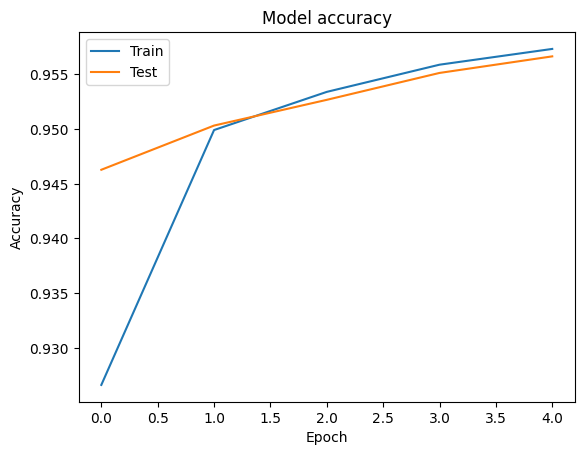

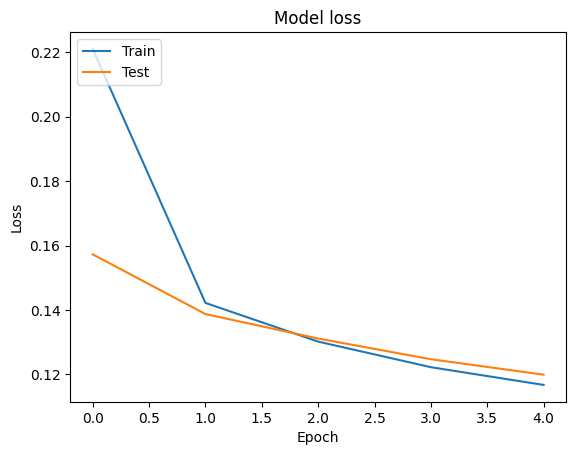

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 预测

我们可以获得验证数据的预测并检查混淆矩阵，以查看模型在 5 个类中的性能。由于 `tf.keras.Model.predict` 方法会返回每个类的概率的 N 维数组，因此可以使用 `np.argmax` 将其转换为类标签。

In [21]:
y_pred = model.predict(validation_data)

  1/294 [..............................] - ETA: 45s

  4/294 [..............................] - ETA: 5s 

  7/294 [..............................] - ETA: 5s

 10/294 [>.............................] - ETA: 5s

 13/294 [>.............................] - ETA: 5s

 16/294 [>.............................] - ETA: 5s

 19/294 [>.............................] - ETA: 5s

 22/294 [=>............................] - ETA: 4s

 25/294 [=>............................] - ETA: 4s

 28/294 [=>............................] - ETA: 4s

 31/294 [==>...........................] - ETA: 4s

 34/294 [==>...........................] - ETA: 4s

 37/294 [==>...........................] - ETA: 4s

 40/294 [===>..........................] - ETA: 4s

 43/294 [===>..........................] - ETA: 4s

 46/294 [===>..........................] - ETA: 4s

 49/294 [====>.........................] - ETA: 4s

 52/294 [====>.........................] - ETA: 4s

 55/294 [====>.........................] - ETA: 4s

 58/294 [====>.........................] - ETA: 4s

 61/294 [=====>........................] - ETA: 4s

 64/294 [=====>........................] - ETA: 4s

 67/294 [=====>........................] - ETA: 4s

 70/294 [======>.......................] - ETA: 4s

 73/294 [======>.......................] - ETA: 4s

 76/294 [======>.......................] - ETA: 3s

 79/294 [=======>......................] - ETA: 3s

 82/294 [=======>......................] - ETA: 3s

 85/294 [=======>......................] - ETA: 3s

 88/294 [=======>......................] - ETA: 3s

 91/294 [========>.....................] - ETA: 3s

 94/294 [========>.....................] - ETA: 3s

 97/294 [========>.....................] - ETA: 3s

100/294 [=========>....................] - ETA: 3s

103/294 [=========>....................] - ETA: 3s

106/294 [=========>....................] - ETA: 3s

109/294 [==========>...................] - ETA: 3s

112/294 [==========>...................] - ETA: 3s

115/294 [==========>...................] - ETA: 3s

118/294 [===========>..................] - ETA: 3s

121/294 [===========>..................] - ETA: 3s

124/294 [===========>..................] - ETA: 3s

127/294 [===========>..................] - ETA: 3s

130/294 [============>.................] - ETA: 2s

133/294 [============>.................] - ETA: 2s

136/294 [============>.................] - ETA: 2s

139/294 [=============>................] - ETA: 2s

142/294 [=============>................] - ETA: 2s

145/294 [=============>................] - ETA: 2s

148/294 [==============>...............] - ETA: 2s

151/294 [==============>...............] - ETA: 2s

154/294 [==============>...............] - ETA: 2s

157/294 [===============>..............] - ETA: 2s

160/294 [===============>..............] - ETA: 2s

163/294 [===============>..............] - ETA: 2s

166/294 [===============>..............] - ETA: 2s

169/294 [================>.............] - ETA: 2s

172/294 [================>.............] - ETA: 2s

175/294 [================>.............] - ETA: 2s

178/294 [=================>............] - ETA: 2s

181/294 [=================>............] - ETA: 2s

184/294 [=================>............] - ETA: 1s

187/294 [==================>...........] - ETA: 1s

190/294 [==================>...........] - ETA: 1s

193/294 [==================>...........] - ETA: 1s

196/294 [===================>..........] - ETA: 1s

199/294 [===================>..........] - ETA: 1s

202/294 [===================>..........] - ETA: 1s

205/294 [===================>..........] - ETA: 1s

208/294 [====================>.........] - ETA: 1s

211/294 [====================>.........] - ETA: 1s

214/294 [====================>.........] - ETA: 1s

217/294 [=====================>........] - ETA: 1s

220/294 [=====================>........] - ETA: 1s

223/294 [=====================>........] - ETA: 1s

226/294 [======================>.......] - ETA: 1s

229/294 [======================>.......] - ETA: 1s

232/294 [======================>.......] - ETA: 1s

235/294 [======================>.......] - ETA: 1s

238/294 [=======================>......] - ETA: 1s

241/294 [=======================>......] - ETA: 0s

244/294 [=======================>......] - ETA: 0s

247/294 [========================>.....] - ETA: 0s

250/294 [========================>.....] - ETA: 0s

253/294 [========================>.....] - ETA: 0s

256/294 [=========================>....] - ETA: 0s

259/294 [=========================>....] - ETA: 0s

262/294 [=========================>....] - ETA: 0s

265/294 [==========================>...] - ETA: 0s

268/294 [==========================>...] - ETA: 0s

271/294 [==========================>...] - ETA: 0s

274/294 [==========================>...] - ETA: 0s

277/294 [===========================>..] - ETA: 0s

280/294 [===========================>..] - ETA: 0s

283/294 [===========================>..] - ETA: 0s

286/294 [============================>.] - ETA: 0s

289/294 [============================>.] - ETA: 0s

292/294 [============================>.] - ETA: 0s

294/294 [==============================] - 5s 18ms/step


In [22]:
y_pred = np.argmax(y_pred, axis=1)

In [23]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[0])
  print("Predicted Class: ", dir_names[y_pred[i]])
  f.close()
  


রবীন্দ্রনাথ ছড়ার ছবি বইতে ‘মাধো’ নামের এক কিশোরের গল্প বলেছেন, যে বাড়ি পালিয়ে পাটকলে কাজ নেয়। পাটকল
True Class:  entertainment
Predicted Class:  state

সিটি করপোরেশন নির্বাচন শেষ হয়েছে প্রায় দুই বছর হলো। এই সময়ে রাজধানীর অনেক স্থানেই লেগেছে উন্নয়নের
True Class:  state
Predicted Class:  state

বিশ্বকাপ মানে যেন দক্ষিণ আফ্রিকার চিরস্থায়ী একটা দুঃখ। সেই দুঃখ কিছুটা হলেও ঘুচিয়ে দিয়েছিল প্রোট
True Class:  sports
Predicted Class:  state


## 比较性能

现在，我们可以从 `labels` 获得验证数据的正确标签，并与我们的预测进行比较，以获得 [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)。 

In [24]:
y_true = np.array(labels[train_size:])

In [25]:
print(classification_report(y_true, y_pred, target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.81      0.78      0.80      3897
       sports       0.99      0.98      0.99     10204
entertainment       0.91      0.94      0.92      6256
        state       0.97      0.97      0.97     48512
international       0.93      0.92      0.93      6377

     accuracy                           0.96     75246
    macro avg       0.92      0.92      0.92     75246
 weighted avg       0.96      0.96      0.96     75246



我们还可以将模型的性能与原始[论文](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset)中精度为 0.96 的发布结果进行比较。原作者描述了在数据集上完成的许多预处理步骤，例如删除标点和数字、去除前 25 个最常见的停用词等。正如我们在 `classification_report` 中所见，在仅训练了 5 个周期而没有进行任何预处理的情况下，我们也获得了 0.96 的精度和准确率！

在此示例中，当我们从嵌入向量模块创建 Keras 层时，我们设置了参数 `trainable=False`，这意味着训练期间不会更新嵌入向量权重。请尝试将此设置为 `True`，使用此数据集仅用 2 个周期即可达到 97% 的准确率。 